<a href="https://colab.research.google.com/github/vmalvarezcamarero/lets-go/blob/master/TFM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tratamiento de datos TFM

Vamos a analizar qué hay dentro de cada zip

In [ ]:
from zipfile import ZipFile
import os

# Montar Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Rutas a los archivos ZIP
rutas_zip = [
    '/content/drive/MyDrive/Data/Tratado_Datos/licitacionesPerfilesContratanteCompleto3_2020.zip',
    '/content/drive/MyDrive/Data/Tratado_Datos/licitacionesPerfilesContratanteCompleto3_2021.zip',
    '/content/drive/MyDrive/Data/Tratado_Datos/licitacionesPerfilesContratanteCompleto3_2022.zip',
    '/content/drive/MyDrive/Data/Tratado_Datos/licitacionesPerfilesContratanteCompleto3_2023.zip',
    '/content/drive/MyDrive/Data/Tratado_Datos/licitacionesPerfilesContratanteCompleto3_2024.zip',
    '/content/drive/MyDrive/Data/Tratado_Datos/licitacionesPerfilesContratanteCompleto3_2025.zip',
]

# Explorar el contenido de cada ZIP
for ruta in rutas_zip:
    print(f"\n📦 Contenido de: {os.path.basename(ruta)}")
    with ZipFile(ruta, 'r') as zipf:
        zipf.printdir()


Dentro de los .zip encontramos numerosos archivos .atom. Vamos a averiguar el contenido de dichos archivos, tomando como referencia el año 2020

In [ ]:
import xml.etree.ElementTree as ET
from zipfile import ZipFile

# Ruta del ZIP a analizar (puedes cambiar el año si lo deseas)
zip_path = '/content/drive/MyDrive/Data/Tratado_Datos/licitacionesPerfilesContratanteCompleto3_2020.zip'

# Extraemos y leemos uno de los archivos .atom
with ZipFile(zip_path, 'r') as zipf:
    # Elegimos el primer archivo .atom
    lista_archivos = zipf.namelist()
    archivo_atom = lista_archivos[0]  # puedes cambiar el índice si deseas otro archivo

    print(f"📄 Leyendo archivo: {archivo_atom}")
    with zipf.open(archivo_atom) as file:
        tree = ET.parse(file)
        root = tree.getroot()

# Mostrar las etiquetas principales del documento XML
for child in root[:5]:  # muestra los primeros 5 elementos
    print(f"🔹 Tag: {child.tag} | Atributos: {child.attrib}")


Para llegar al contenido útil (las licitaciones), necesitamos iterar sobre los elementos "entry" dentro del archivo XML. Ahí es donde estarán los campos que nos interesan: título, descripción, CPV, fechas, etc.

In [ ]:
# Definir el namespace de Atom (importante para encontrar etiquetas correctamente)
ns = {'atom': 'http://www.w3.org/2005/Atom'}

# Buscar todos los elementos <entry>
entries = root.findall('atom:entry', ns)
print(f"🧾 Total de licitaciones encontradas: {len(entries)}")

# Mostrar las etiquetas de la primera licitación
primer_entry = entries[0]
print("\n📌 Campos dentro de la primera licitación (entry):")
for elem in primer_entry:
    print(f"🔸 Tag: {elem.tag} | Atributos: {elem.attrib}")


Cada licitación está en una etiqueta entry.

Dentro de cada entry aparecen:

- title: título de la licitación.

- summary: breve resumen (probablemente útil para contexto).

- link: URL directa a la ficha de la licitación.

- updated: fecha de actualización.

- ContractFolderStatus: un nodo complejo que probablemente contiene detalles importantes como CPV, importe, fechas, etc.

In [ ]:
# Namespace extendido para poder acceder a ContractFolderStatus y sus campos
ns = {
    'atom': 'http://www.w3.org/2005/Atom',
    'cac': 'urn:dgpe:names:draft:codice-place-ext:schema:xsd:CommonAggregateComponents-2'
}

# Tomamos la primera licitación
primer_entry = entries[0]

# Localizamos el nodo ContractFolderStatus
cfs = primer_entry.find('cac:ContractFolderStatus', ns)

# Listamos las etiquetas internas dentro de ContractFolderStatus
print("\n🔍 Explorando ContractFolderStatus:")
for elem in cfs:
    print(f"🔸 Tag: {elem.tag} | Atributos: {elem.attrib}")


El nodo 🔸 Tag: {urn:dgpe:names:draft:codice:schema:xsd:CommonAggregateComponents-2}ProcurementProject es clave, porque dentro de él es donde usualmente se encuentra el código CPV, el nombre del proyecto, y a veces más detalles del objeto del contrato.
Vamos a ver qué contiene ese nodo


In [ ]:
# Namespace extendido
ns.update({
    'cbc': 'urn:dgpe:names:draft:codice:schema:xsd:CommonBasicComponents-2',
    'cac_ext': 'urn:dgpe:names:draft:codice-place-ext:schema:xsd:CommonAggregateComponents-2',
    'cac': 'urn:dgpe:names:draft:codice:schema:xsd:CommonAggregateComponents-2'
})

# Accedemos a <cac:ProcurementProject> dentro de ContractFolderStatus
procurement_project = cfs.find('cac:ProcurementProject', ns)

# Mostramos etiquetas dentro de ProcurementProject
print("\n📦 Explorando ProcurementProject:")
for elem in procurement_project:
    print(f"🔸 Tag: {elem.tag} | Atributos: {elem.attrib} | Texto: {elem.text}")


archivo .atom contiene las licitaciones en <entry>, y dentro de cada <entry> el nodo <cac:ContractFolderStatus> → <cac:ProcurementProject> es donde están los datos clave, incluyendo:

🔹 Name: nombre de la licitación.

🔹 BudgetAmount: presupuesto.

🔹 RequiredCommodityClassification: aquí es muy probable que esté el código CPV que necesitamos.



In [ ]:
# Buscar RequiredCommodityClassification dentro de ProcurementProject
classification = procurement_project.find('cac:RequiredCommodityClassification', ns)

# Explorarlo
print("\n🔍 Contenido de RequiredCommodityClassification:")
for elem in classification:
    print(f"🔸 Tag: {elem.tag} | Texto: {elem.text}")


Hacemos un script que:
- Recorra todos los archivos .zip que tienes para 2020-2025.

- Extraiga cada .atom dentro.

- Para cada .atom, lea todas las licitaciones (<entry>).

- Para cada licitación, extraiga los campos clave:

  ID

  Título

  Resumen

  Fecha (updated)

  Enlace (link)

  CPV (ItemClassificationCode)

  Presupuesto (BudgetAmount si está disponible)

- Filtre las licitaciones que tengan CPV en tu lista de interés.

- Genere un DataFrame con esas filas.



In [ ]:
import zipfile
import xml.etree.ElementTree as ET
import pandas as pd
import os

# Lista de CPVs que nos interesan
cpvs_interes = {'33124130', '33124110', '33141625', '33696000', '38434000', '38434500'}

# Namespaces para el XML
ns = {
    'atom': 'http://www.w3.org/2005/Atom',
    'cbc': 'urn:dgpe:names:draft:codice:schema:xsd:CommonBasicComponents-2',
    'cac': 'urn:dgpe:names:draft:codice:schema:xsd:CommonAggregateComponents-2',
    'cac_ext': 'urn:dgpe:names:draft:codice-place-ext:schema:xsd:CommonAggregateComponents-2'
}

# Ruta base donde están los zip
base_path = '/content/drive/MyDrive/Data/Tratado_Datos/'

# Lista para almacenar resultados
resultados = []

# Función para procesar un archivo .atom en bytes
def procesar_atom(data):
    root = ET.fromstring(data)
    entries = root.findall('atom:entry', ns)
    for entry in entries:
        # Campos básicos
        lic_id = entry.find('atom:id', ns).text if entry.find('atom:id', ns) is not None else None
        title = entry.find('atom:title', ns).text if entry.find('atom:title', ns) is not None else None
        summary = entry.find('atom:summary', ns).text if entry.find('atom:summary', ns) is not None else None
        updated = entry.find('atom:updated', ns).text if entry.find('atom:updated', ns) is not None else None
        link_elem = entry.find('atom:link', ns)
        link = link_elem.attrib.get('href') if link_elem is not None else None

        # ContractFolderStatus
        cfs = entry.find('cac_ext:ContractFolderStatus', ns)
        if cfs is None:
            continue

        # ProcurementProject
        procurement = cfs.find('cac:ProcurementProject', ns)
        if procurement is None:
            continue

        # CPV
        classification = procurement.find('cac:RequiredCommodityClassification', ns)
        cpv_code = None
        if classification is not None:
            cpv_elem = classification.find('cbc:ItemClassificationCode', ns)
            if cpv_elem is not None and cpv_elem.text is not None:
                cpv_code = cpv_elem.text.strip()

        # Filtrar por CPV de interés
        if cpv_code not in cpvs_interes:
            continue

        # Presupuesto (BudgetAmount)
        budget = procurement.find('cac:BudgetAmount', ns)
        budget_text = budget.text.strip() if budget is not None and budget.text is not None else None

        # Guardar resultado
        resultados.append({
            'ID': lic_id,
            'Título': title,
            'Resumen': summary,
            'Fecha_Actualización': updated,
            'Enlace': link,
            'CPV': cpv_code,
            'Presupuesto': budget_text
        })

# Iterar los años y zip
for year in range(2020, 2026):
    zip_path = os.path.join(base_path, f'licitacionesPerfilesContratanteCompleto3_{year}.zip')
    print(f'Procesando archivo: {zip_path}')
    with zipfile.ZipFile(zip_path, 'r') as z:
        for filename in z.namelist():
            if filename.endswith('.atom'):
                print(f'  Leyendo {filename}...')
                with z.open(filename) as f:
                    data = f.read()
                    procesar_atom(data)


# Guardar el DataFrame en un CSV en tu Google Drive


# Crear DataFrame final
df = pd.DataFrame(resultados)
print(f'\n🎉 Licitaciones filtradas: {len(df)}')

csv_path = '/content/drive/MyDrive/Data/licitaciones_filtradas_IVD.csv'
df.to_csv(csv_path, index=False, encoding='utf-8-sig')

print(f'Archivo CSV guardado en: {csv_path}')


Procesando archivo: /content/drive/MyDrive/Data/Tratado_Datos/licitacionesPerfilesContratanteCompleto3_2020.zip
  Leyendo licitacionesPerfilesContratanteCompleto3.atom...
  Leyendo licitacionesPerfilesContratanteCompleto3_20200712_150726.atom...
  Leyendo licitacionesPerfilesContratanteCompleto3_20200712_150726_1.atom...
  Leyendo licitacionesPerfilesContratanteCompleto3_20200712_150726_2.atom...
  Leyendo licitacionesPerfilesContratanteCompleto3_20200712_160000.atom...
  Leyendo licitacionesPerfilesContratanteCompleto3_20200712_160000_1.atom...


KeyboardInterrupt: 

Vamos a analizar el año 2020 para tratar de encontrar el presupuesto

Prueba para el año 2020 con códigos CPV y sus "hijos"

In [ ]:
import zipfile
import xml.etree.ElementTree as ET
import pandas as pd
import re

# 📁 Rutas
zip_path   = '/content/drive/MyDrive/Data/Tratado_Datos/licitacionesPerfilesContratanteCompleto3_2020.zip'
output_csv = '/content/drive/MyDrive/Data/licitaciones_filtradas_IVD_2020.csv'

# 🌐 Espacios de nombres CODICE/ATOM
ns = {
    'atom':    'http://www.w3.org/2005/Atom',
    'cbc':     'urn:dgpe:names:draft:codice:schema:xsd:CommonBasicComponents-2',
    'cac':     'urn:dgpe:names:draft:codice:schema:xsd:CommonAggregateComponents-2',
    'cac_ext': 'urn:dgpe:names:draft:codice-place-ext:schema:xsd:CommonAggregateComponents-2'
}

# 🎯 CPV de interés (8 dígitos “limpios”)
CPVS_INTERES = {'33124130', '33124110', '33141625', '33696000', '38434000', '38434500'}

# ──────────────────────────────────────────────────────────────────────────────
# Utilidades
# ──────────────────────────────────────────────────────────────────────────────
def canonicaliza_cpv(cpv_raw: str) -> str | None:
    """Devuelve los primeros 8 dígitos del CPV o None si no hay formato válido."""
    m = re.match(r'(\d{8})', cpv_raw or '')
    return m.group(1) if m else None


def parse_importe(txt: str) -> float | None:
    """
    Convierte una cadena con importe en formato español, anglosajón
    o sin separadores a float.  Ejemplos válidos:
      '1.163.318,94'  '1,163,318.94'  '1163318,94'  '1163318.94'  '1000'
    Devuelve None si no hay dígitos parsables.
    """
    if not txt or not re.search(r'\d', txt):
        return None

    s = txt.strip().replace('\u202f', '').replace(' ', '').replace(' ', '')  # quita NBSP/espacios

    # Decide cuál es el decimal (coma o punto)
    if ',' in s and '.' in s:
        dec = ',' if s.rfind(',') > s.rfind('.') else '.'
    elif ',' in s:
        dec = ',' if len(s.rsplit(',', 1)[-1]) in (2, 3) else None
    elif '.' in s:
        dec = '.' if len(s.rsplit('.', 1)[-1]) in (2, 3) else None
    else:
        dec = None

    if dec:
        miles = '.' if dec == ',' else ','
        s = s.replace(miles, '')     # quita separador de miles
        s = s.replace(dec, '.')      # normaliza a punto decimal
    else:
        s = re.sub(r'[^\d]', '', s)  # deja solo dígitos

    try:
        return float(s)
    except ValueError:
        return None


def first_numeric_amount(elem) -> float | None:
    """Devuelve el primer importe numérico razonable dentro de ContractFolderStatus."""
    for e in elem.iter():
        tag = e.tag.split('}')[-1].lower()
        if ("amount" in tag or "value" in tag) and e.text:
            imp = parse_importe(e.text)
            if imp is not None:
                return imp
    return None

# ──────────────────────────────────────────────────────────────────────────────
# Extracción principal
# ──────────────────────────────────────────────────────────────────────────────
resultados = []

with zipfile.ZipFile(zip_path, 'r') as z:
    for nombre_archivo in z.namelist():
        if not nombre_archivo.endswith('.atom'):
            continue

        with z.open(nombre_archivo) as f:
            tree  = ET.parse(f)
            root  = tree.getroot()
            entries = root.findall('atom:entry', ns)

            for entry in entries:
                cfs = entry.find('cac_ext:ContractFolderStatus', ns)
                if cfs is None:
                    continue

                # 🔍 Recorremos todas las clasificaciones declaradas
                procurement = cfs.find('cac:ProcurementProject', ns)
                if procurement is None:
                    continue
                classifications = procurement.findall('cac:RequiredCommodityClassification', ns)

                cpv_hit = None
                for cls in classifications:
                    raw_code   = cls.findtext('cbc:ItemClassificationCode', default='', namespaces=ns).strip()
                    clean_code = canonicaliza_cpv(raw_code)
                    if clean_code and clean_code in CPVS_INTERES:
                        cpv_hit = clean_code
                        break         # basta con la primera coincidencia

                if cpv_hit is None:
                    continue          # ningún CPV relevante → siguiente entrada

                # 📑 Campos básicos
                lic_id  = entry.findtext('atom:id',      default='', namespaces=ns).strip()
                title   = entry.findtext('atom:title',   default='', namespaces=ns).strip()
                summary = entry.findtext('atom:summary', default='', namespaces=ns).strip()
                updated = entry.findtext('atom:updated', default='', namespaces=ns).strip()
                link_el = entry.find('atom:link', ns)
                link    = link_el.attrib.get('href', '') if link_el is not None else ''

                # 💶 Importe
                amount  = first_numeric_amount(cfs)

                resultados.append({
                    'ID': lic_id,
                    'Título': title,
                    'Resumen': summary,
                    'Fecha_Actualización': updated,
                    'Enlace': link,
                    'CPV': cpv_hit,          # código limpio de 8 dígitos
                    'Presupuesto': amount
                })

# ──────────────────────────────────────────────────────────────────────────────
# Guardar CSV
# ──────────────────────────────────────────────────────────────────────────────
df = pd.DataFrame(resultados)
df.to_csv(output_csv, index=False, encoding='utf-8-sig')

print(f'✅ CSV guardado en: {output_csv}')
print(f'📊 Total de licitaciones filtradas: {len(df)}')
print(df.head())


Ahora lo hacemos con todos los años

In [ ]:
import zipfile
import xml.etree.ElementTree as ET
import pandas as pd
import re

# 📁 Rutas
zip_path   = '/content/drive/MyDrive/Data/Tratado_Datos/licitacionesPerfilesContratanteCompleto3_2021.zip'
output_csv = '/content/drive/MyDrive/Data/licitaciones_filtradas_IVD_2021.csv'

# 🌐 Espacios de nombres CODICE/ATOM
ns = {
    'atom':    'http://www.w3.org/2005/Atom',
    'cbc':     'urn:dgpe:names:draft:codice:schema:xsd:CommonBasicComponents-2',
    'cac':     'urn:dgpe:names:draft:codice:schema:xsd:CommonAggregateComponents-2',
    'cac_ext': 'urn:dgpe:names:draft:codice-place-ext:schema:xsd:CommonAggregateComponents-2'
}

# 🎯 CPV de interés (8 dígitos “limpios”)
CPVS_INTERES = {'33124130', '33124110', '33141625', '33696000', '38434000', '38434500'}

# ──────────────────────────────────────────────────────────────────────────────
# Utilidades
# ──────────────────────────────────────────────────────────────────────────────
def canonicaliza_cpv(cpv_raw: str) -> str | None:
    """Devuelve los primeros 8 dígitos del CPV o None si no hay formato válido."""
    m = re.match(r'(\d{8})', cpv_raw or '')
    return m.group(1) if m else None


def parse_importe(txt: str) -> float | None:
    """
    Convierte una cadena con importe en formato español, anglosajón
    o sin separadores a float.  Ejemplos válidos:
      '1.163.318,94'  '1,163,318.94'  '1163318,94'  '1163318.94'  '1000'
    Devuelve None si no hay dígitos parsables.
    """
    if not txt or not re.search(r'\d', txt):
        return None

    s = txt.strip().replace('\u202f', '').replace(' ', '').replace(' ', '')  # quita NBSP/espacios

    # Decide cuál es el decimal (coma o punto)
    if ',' in s and '.' in s:
        dec = ',' if s.rfind(',') > s.rfind('.') else '.'
    elif ',' in s:
        dec = ',' if len(s.rsplit(',', 1)[-1]) in (2, 3) else None
    elif '.' in s:
        dec = '.' if len(s.rsplit('.', 1)[-1]) in (2, 3) else None
    else:
        dec = None

    if dec:
        miles = '.' if dec == ',' else ','
        s = s.replace(miles, '')     # quita separador de miles
        s = s.replace(dec, '.')      # normaliza a punto decimal
    else:
        s = re.sub(r'[^\d]', '', s)  # deja solo dígitos

    try:
        return float(s)
    except ValueError:
        return None


def first_numeric_amount(elem) -> float | None:
    """Devuelve el primer importe numérico razonable dentro de ContractFolderStatus."""
    for e in elem.iter():
        tag = e.tag.split('}')[-1].lower()
        if ("amount" in tag or "value" in tag) and e.text:
            imp = parse_importe(e.text)
            if imp is not None:
                return imp
    return None

# ──────────────────────────────────────────────────────────────────────────────
# Extracción principal
# ──────────────────────────────────────────────────────────────────────────────
resultados = []

with zipfile.ZipFile(zip_path, 'r') as z:
    for nombre_archivo in z.namelist():
        if not nombre_archivo.endswith('.atom'):
            continue

        with z.open(nombre_archivo) as f:
            tree  = ET.parse(f)
            root  = tree.getroot()
            entries = root.findall('atom:entry', ns)

            for entry in entries:
                cfs = entry.find('cac_ext:ContractFolderStatus', ns)
                if cfs is None:
                    continue

                # 🔍 Recorremos todas las clasificaciones declaradas
                procurement = cfs.find('cac:ProcurementProject', ns)
                if procurement is None:
                    continue
                classifications = procurement.findall('cac:RequiredCommodityClassification', ns)

                cpv_hit = None
                for cls in classifications:
                    raw_code   = cls.findtext('cbc:ItemClassificationCode', default='', namespaces=ns).strip()
                    clean_code = canonicaliza_cpv(raw_code)
                    if clean_code and clean_code in CPVS_INTERES:
                        cpv_hit = clean_code
                        break         # basta con la primera coincidencia

                if cpv_hit is None:
                    continue          # ningún CPV relevante → siguiente entrada

                # 📑 Campos básicos
                lic_id  = entry.findtext('atom:id',      default='', namespaces=ns).strip()
                title   = entry.findtext('atom:title',   default='', namespaces=ns).strip()
                summary = entry.findtext('atom:summary', default='', namespaces=ns).strip()
                updated = entry.findtext('atom:updated', default='', namespaces=ns).strip()
                link_el = entry.find('atom:link', ns)
                link    = link_el.attrib.get('href', '') if link_el is not None else ''

                # 💶 Importe
                amount  = first_numeric_amount(cfs)

                resultados.append({
                    'ID': lic_id,
                    'Título': title,
                    'Resumen': summary,
                    'Fecha_Actualización': updated,
                    'Enlace': link,
                    'CPV': cpv_hit,          # código limpio de 8 dígitos
                    'Presupuesto': amount
                })

# ──────────────────────────────────────────────────────────────────────────────
# Guardar CSV
# ──────────────────────────────────────────────────────────────────────────────
df = pd.DataFrame(resultados)
df.to_csv(output_csv, index=False, encoding='utf-8-sig')

print(f'✅ CSV guardado en: {output_csv}')
print(f'📊 Total de licitaciones filtradas: {len(df)}')
print(df.head())

Ahora buscamos la región

In [ ]:
import zipfile
import xml.etree.ElementTree as ET
import pandas as pd
import re

# ─────────────────────────────────────────────────────────────────────────────
# Configuración
# ─────────────────────────────────────────────────────────────────────────────
zip_path     = '/content/drive/MyDrive/Data/Tratado_Datos/licitacionesPerfilesContratanteCompleto3_2025.zip'
output_path  = '/content/drive/MyDrive/Data/Licitaciones_IVD_2025_con_region.csv'

# Espacios de nombres CODICE/ATOM
ns = {
    'atom':    'http://www.w3.org/2005/Atom',
    'cbc':     'urn:dgpe:names:draft:codice:schema:xsd:CommonBasicComponents-2',
    'cac':     'urn:dgpe:names:draft:codice:schema:xsd:CommonAggregateComponents-2',
    'cac_ext': 'urn:dgpe:names:draft:codice-place-ext:schema:xsd:CommonAggregateComponents-2'
}

# 🎯 CPV “limpios” (8 dígitos – sin guion)
CPVS_INTERES = {'33124130', '33124110', '33141625', '33696000', '38434000', '38434500'}

# ─────────────────────────────────────────────────────────────────────────────
# Utilidades
# ─────────────────────────────────────────────────────────────────────────────
def canonicaliza_cpv(cpv_raw: str) -> str | None:
    """Devuelve los 8 dígitos iniciales o None si no hay formato válido."""
    m = re.match(r'(\d{8})', cpv_raw or '')
    return m.group(1) if m else None


def parse_importe(txt: str) -> float | None:
    """Convierte importe europeo / anglosajón / sin separadores a float."""
    if not txt or not re.search(r'\d', txt):
        return None
    s = txt.strip().replace('\u202f', '').replace(' ', '')
    # determina qué símbolo es el decimal
    if ',' in s and '.' in s:
        dec = ',' if s.rfind(',') > s.rfind('.') else '.'
    elif ',' in s:
        dec = ',' if len(s.rsplit(',', 1)[-1]) in (2, 3) else None
    elif '.' in s:
        dec = '.' if len(s.rsplit('.', 1)[-1]) in (2, 3) else None
    else:
        dec = None

    if dec:
        miles = '.' if dec == ',' else ','
        s = s.replace(miles, '').replace(dec, '.')
    else:
        s = re.sub(r'[^\d]', '', s)
    try:
        return float(s)
    except ValueError:
        return None


def first_numeric_amount(elem) -> float | None:
    """Busca el primer nodo Amount/Value con número válido y lo devuelve como float."""
    for e in elem.iter():
        tag = e.tag.split('}')[-1].lower()
        if ("amount" in tag or "value" in tag) and e.text:
            imp = parse_importe(e.text)
            if imp is not None:
                return imp
    return None


# ─────────────────────────────────────────────────────────────────────────────
# Extracción
# ─────────────────────────────────────────────────────────────────────────────
datos = []

with zipfile.ZipFile(zip_path, 'r') as z:
    for nombre_archivo in z.namelist():
        if not nombre_archivo.endswith('.atom'):
            continue
        with z.open(nombre_archivo) as f:
            try:
                tree = ET.parse(f)
                root = tree.getroot()
            except ET.ParseError:
                print(f"⚠️ Error al parsear {nombre_archivo}, se omite.")
                continue

            for entry in root.findall('atom:entry', ns):
                cfs = entry.find('cac_ext:ContractFolderStatus', ns)
                if cfs is None:
                    continue

                procurement = cfs.find('cac:ProcurementProject', ns)
                if procurement is None:
                    continue

                # ── CPV: recorre todos y acepta el primero que coincida ──────────
                cpv_hit = None
                for cls in procurement.findall('cac:RequiredCommodityClassification', ns):
                    raw = cls.findtext('cbc:ItemClassificationCode', default='', namespaces=ns).strip()
                    clean = canonicaliza_cpv(raw)
                    if clean and clean in CPVS_INTERES:
                        cpv_hit = clean
                        break
                if cpv_hit is None:
                    continue   # no nos interesa este expediente

                # ── Campos básicos ────────────────────────────────────────────
                lic_id  = entry.findtext('atom:id', default='',  namespaces=ns).strip()
                title   = entry.findtext('atom:title', default='', namespaces=ns).strip()
                updated = entry.findtext('atom:updated', default='', namespaces=ns).strip()
                summary = entry.findtext('atom:summary', default='', namespaces=ns).strip()

                link_el = entry.find('atom:link', ns)
                enlace  = link_el.attrib.get('href', '') if link_el is not None else ''

                # ── Importe ───────────────────────────────────────────────────
                amount = first_numeric_amount(cfs)

                # ── Región / Ciudad ──────────────────────────────────────────
                region = ''
                rutas = [
                    'cac_ext:LocatedContractingParty/cac:Party/cac:PostalAddress/cbc:Region',
                    'cac_ext:LocatedContractingParty/cac:Party/cac:PostalAddress/cbc:CityName',
                    'cac:RealizedLocation/cac:Location/cac:Address/cbc:Region',
                    'cac:RealizedLocation/cac:Location/cac:Address/cbc:CityName'
                ]
                for r in rutas:
                    nodo = cfs.find(r, ns)
                    if nodo is not None and nodo.text:
                        region = nodo.text.strip()
                        break

                datos.append({
                    'ID': lic_id,
                    'Título': title,
                    'Fecha': updated,
                    'Resumen': summary,
                    'Enlace': enlace,
                    'CPV': cpv_hit,
                    'Presupuesto': amount,
                    'Región': region
                })

# ─────────────────────────────────────────────────────────────────────────────
# Guardar CSV
# ─────────────────────────────────────────────────────────────────────────────
df = pd.DataFrame(datos)
df.to_csv(output_path, index=False, encoding='utf-8-sig')

print(f'✅ CSV guardado con {len(df)} entradas en:\n{output_path}')


Ahora necesitamos eliminar todos los duplicados (licitaciones modificadas) que existen, quedándonos con el precio más alto

In [ ]:
import pandas as pd
import os

# Rango de años
anios = range(2020, 2026)

# Ruta base
input_folder = '/content/drive/MyDrive/Data'
output_folder = '/content/drive/MyDrive/Data/Limpios'
os.makedirs(output_folder, exist_ok=True)

for anio in anios:
    input_path = os.path.join(input_folder, f'Licitaciones_IVD_{anio}_con_region.csv')
    output_path = os.path.join(output_folder, f'Licitaciones_IVD_{anio}_limpio.csv')

    try:
        df = pd.read_csv(input_path)

        # Convertir presupuesto a numérico (maneja errores y símbolos)
        df['Presupuesto'] = pd.to_numeric(df['Presupuesto'].astype(str).str.replace(r'[^\d.]', '', regex=True), errors='coerce')

        # Quitar duplicados por ID conservando el presupuesto máximo
        df_limpio = df.sort_values('Presupuesto', ascending=False).drop_duplicates(subset='ID', keep='first')

        # Guardar limpio
        df_limpio.to_csv(output_path, index=False, encoding='utf-8-sig')
        print(f'✅ Año {anio}: {len(df_limpio)} registros guardados en {output_path}')

    except Exception as e:
        print(f'❌ Error procesando {anio}: {e}')


Creamos una lista de nombres de regiones común para todos los años. Para ello sacamos nombres únicos y los asociamos a una ccaa.

In [ ]:
import pandas as pd
import os

# Ruta a los archivos ya limpios
input_folder = '/content/drive/MyDrive/Data/Limpios'

# Almacén para los valores únicos por año
regiones_por_anio = {}

# Años a analizar
anios = range(2020, 2026)

for anio in anios:
    path = os.path.join(input_folder, f'Licitaciones_IVD_{anio}_limpio.csv')
    try:
        df = pd.read_csv(path)

        # Asegurarse de que la columna de región existe y es texto
        if 'Región' in df.columns:
            regiones_unicas = sorted(df['Región'].dropna().astype(str).unique())
            regiones_por_anio[anio] = regiones_unicas
            print(f'\n📅 {anio} - {len(regiones_unicas)} regiones encontradas:')
            for r in regiones_unicas:
                print(f'   - {r}')
        else:
            print(f'⚠️ {anio}: No se encontró la columna "Region"')
    except Exception as e:
        print(f'❌ Error al procesar {anio}: {e}')


In [ ]:
# Diccionario de conversión de localidad a CCAA
localidad_a_ccaa = {
    # Andalucía
    "Sevilla": "Andalucía", "Málaga": "Andalucía", "Córdoba": "Andalucía", "Granada": "Andalucía",
    "Huelva": "Andalucía", "Almería": "Andalucía", "Jaén": "Andalucía", "Chiclana de la Frontera": "Andalucía",
    "Benalmádena": "Andalucía", "San Fernando": "Andalucía", "Marbella": "Andalucía",
    "Torremolinos": "Andalucía", "Cádiz": "Andalucía", "Rota (Cádiz)": "Andalucía",

    # Aragón
    "Zaragoza": "Aragón", "Teruel": "Aragón", "Calatayud": "Aragón", "ALCAÑIZ": "Aragón",

    # Asturias
    "Oviedo": "Asturias", "Langreo": "Asturias",

    # Baleares
    "Palma": "Islas Baleares", "Palma de Mallorca": "Islas Baleares", "La Palma": "Islas Baleares",

    # Canarias
    "Santa Cruz de Tenerife": "Canarias", "Las Palmas de Gran Canaria": "Canarias",
    "Arona": "Canarias", "Puerto del Rosario": "Canarias", "Arrecife": "Canarias",
    "San Sebastián de la Gomera": "Canarias", "Valverde": "Canarias", "Gáldar": "Canarias",
    "San Cristóbal de la Laguna": "Canarias",

    # Cantabria
    "Santander": "Cantabria", "Torrelavega": "Cantabria",

    # Castilla y León
    "León": "Castilla y León", "Salamanca": "Castilla y León", "Segovia": "Castilla y León",
    "Soria": "Castilla y León", "Valladolid": "Castilla y León", "Zamora": "Castilla y León",
    "Cubillos del Sil (León)": "Castilla y León", "Arroyo de la Encomienda": "Castilla y León",
    "Palencia": "Castilla y León",

    # Castilla-La Mancha
    "Ciudad Real": "Castilla-La Mancha", "Toledo": "Castilla-La Mancha", "Albacete": "Castilla-La Mancha",
    "Puertollano": "Castilla-La Mancha",

    # Cataluña
    "Barcelona": "Cataluña", "Lleida": "Cataluña", "Girona": "Cataluña", "Tarragona": "Cataluña",
    "Vinaròs": "Cataluña",

    # Ceuta y Melilla
    "Ceuta": "Ceuta", "Melilla": "Melilla",

    # Comunidad Valenciana
    "Valencia": "Comunidad Valenciana", "Castellón": "Comunidad Valenciana", "Alicante": "Comunidad Valenciana",
    "San Vicente Raspeig (Alicante)": "Comunidad Valenciana", "Santa Pola": "Comunidad Valenciana",
    "Burjassot": "Comunidad Valenciana", "Elda (Alicante)": "Comunidad Valenciana", "Orihuela": "Comunidad Valenciana",
    "Alcoy": "Comunidad Valenciana",

    # Extremadura
    "Badajoz": "Extremadura", "Cáceres": "Extremadura", "Mérida": "Extremadura", "Navalmoral de la Mata": "Extremadura",
    "Don Benito": "Extremadura",

    # Galicia
    "Vigo": "Galicia",

    # Comunidad de Madrid
    "Madrid": "Madrid", "Pozuelo de Alarcón": "Madrid", "Móstoles": "Madrid", "Getafe": "Madrid",
    "Alcorcón": "Madrid", "Torrejón de Ardoz, Madrid": "Madrid", "Rivas-Vaciamadrid": "Madrid",
    "Majadahonda": "Madrid", "Alcalá de Henares": "Madrid",

    # Murcia
    "Murcia": "Murcia", "Cartagena (Murcia)": "Murcia", "Cartagena": "Murcia",
    "Espinardo": "Murcia", "El Palmar (Murcia)": "Murcia", "Lorca": "Murcia",

    # País Vasco
    "Loiu": "País Vasco",
        "Estepona": "Andalucía",
    "Fuengirola": "Andalucía",
    "Gines": "Andalucía",
    "Mijas": "Andalucía",
    "Ubrique": "Andalucía",
    "Écija": "Andalucía",

    # ––– Aragón –––––––––––––
    "Caspe": "Aragón",
    "Canfranc Estación": "Aragón",

    # ––– Asturias –––––––––––
    "Castrillón": "Asturias",

    # ––– Illes Balears ––––––
    "Santa Ponça(Calviá)": "Islas Baleares",

    # ––– Canarias –––––––––––
    "Santa Úrsula": "Canarias",
    "Telde": "Canarias",

    # ––– Castilla-La Mancha –
    "Tomelloso": "Castilla-La Mancha",
    "Alcázar de San Juan": "Castilla-La Mancha",

    # ––– Castilla y León ––––
    "Aranda de Duero": "Castilla y León",

    # ––– Comunidad de Madrid –
    "Collado Villalba (Madrid)": "Madrid",

    # ––– Comunidad Valenciana –
    "Sagunto": "Comunidad Valenciana",
    "Moncada": "Comunidad Valenciana",
    "Elche": "Comunidad Valenciana",
    "Paterna": "Comunidad Valenciana",
    "Xátiva": "Comunidad Valenciana",
    "Algemesí": "Comunidad Valenciana",
    "Monóvar": "Comunidad Valenciana",
    "Requena": "Comunidad Valenciana",
    "Sant Joan d'Alacant": "Comunidad Valenciana",
    "València": "Comunidad Valenciana",   # variante con ‘à’
    "Alicante": "Comunidad Valenciana",   # por si aún no estaba

    # ––– Extremadura ––––––––
    "Coria": "Extremadura",

    # ––– Galicia ––––––––––––
    "A Coruña": "Galicia",
    "Las Torres de Cotillas": "Murcia",
}


import pandas as pd
import os

# Ruta de entrada y salida
input_folder = '/content/drive/MyDrive/Data/Limpios'
output_folder = '/content/drive/MyDrive/Data/Definitivos'

# Asegurar carpeta de salida
os.makedirs(output_folder, exist_ok=True)

# Años a procesar
anios = range(2020, 2026)

for anio in anios:
    input_path = os.path.join(input_folder, f'Licitaciones_IVD_{anio}_limpio.csv')
    output_path = os.path.join(output_folder, f'Licitaciones_IVD_{anio}_Definitivo.csv')

    df = pd.read_csv(input_path)

    if 'Región' not in df.columns:
        print(f'⚠️ Año {anio}: no se encuentra la columna "Region".')
        continue

    # Aplicar normalización
    df['CCAA'] = df['Región'].map(localidad_a_ccaa)

    # Mostrar valores no mapeados (opcional)
    no_mapeadas = df[df['CCAA'].isna()]['Región'].unique()
    if len(no_mapeadas) > 0:
        print(f'🔍 Año {anio}: {len(no_mapeadas)} regiones no mapeadas:')
        for r in no_mapeadas:
            print(f'   - {r}')

    # Guardar resultado
    df.to_csv(output_path, index=False)
    print(f'✅ Archivo guardado: {output_path}')


## Cataluña

In [ ]:
# ⬇️ Si aún no lo has hecho en tu notebook
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import glob, os, re

# 1. Localiza todos los Excel
RUTA_XLSX = '/content/drive/MyDrive/Data/PSCP_Cataluna/*.xlsx'
files = glob.glob(RUTA_XLSX)

def normaliza_importe(valor):
    """
    Convierte '1.234.567,89' -> 1234567.89 (float) o deja None si no hay dato
    """
    if pd.isna(valor):
        return None
    if isinstance(valor, (int, float)):
        return float(valor)
    # Quita espacios, puntos de millar y cambia la coma decimal
    limpio = (
        str(valor)
        .replace(' ', '')        # espacio duro HTML
        .replace('.', '')
        .replace(',', '.')
        .strip()
    )
    try:
        return float(limpio)
    except ValueError:
        return None

def construye_resumen(row):
    base = [
        f"Código: {row['Código del expediente']}",
        f"Órgano: {row['Órgano de contratación']}",
    ]
    importe = row['Importe de adjudicación'] or row['Presupuesto de licitación']
    if importe:
        base.append(f"Importe: {importe} EUR")
    if pd.notna(row['Fase de publicación']):
        base.append(f"Fase: {row['Fase de publicación']}")
    return '; '.join(base)

dfs = []

for file in files:
    df_raw = pd.read_excel(file, dtype=str)          # usa openpyxl por defecto
    df_raw = df_raw.applymap(lambda x: x.strip() if isinstance(x, str) else x)

    # 2. Crea las columnas destino
    df = pd.DataFrame({
        'ID': df_raw['Código del expediente'],
        'Título': df_raw['Denominación'],
        'Fecha': df_raw['Fecha de la última publicación'],
        'Resumen': df_raw.apply(construye_resumen, axis=1),
        'Enlace': df_raw['Enlace de la última publicación'],
        'CPV': df_raw['CPV'],
        'Presupuesto': df_raw['Importe de adjudicación'].combine_first(
            df_raw['Presupuesto de licitación']
        ).apply(normaliza_importe),
        'Región': df_raw['Lugares de ejecución'].str.split(',').str[0].str.strip(),
        'CCAA': 'Cataluña',
    })

    dfs.append(df)

# 3. Une todo y exporta
out_path = '/content/drive/MyDrive/Data/Definitivos/Licitaciones_IVD_Cataluna_Definitivo.csv'
pd.concat(dfs, ignore_index=True).to_csv(out_path, index=False)

print(f'✅ CSV generado en: {out_path}')


Dividimos las licitaciones de Cataluña en los años

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd, os

CSV_CATALUNA = '/content/drive/MyDrive/Data/Definitivos/Cataluña/Licitaciones_IVD_Cataluna_Definitivo.csv'
OUT_DIR      = '/content/drive/MyDrive/Data/Definitivos/Cataluña'
os.makedirs(OUT_DIR, exist_ok=True)

# 1️⃣  Carga y sanea columnas
df = pd.read_csv(CSV_CATALUNA, dtype=str)
df.columns = df.columns.str.strip()                 # quita espacios invisibles

# 2️⃣  Convierte la columna Fecha con un fallback robusto
def parse_fecha(s):
    """Devuelve datetime o NaT; acepta formatos con 'T' y con zona horaria."""
    if pd.isna(s):
        return pd.NaT
    # recorta a los primeros 19 caracteres ('AAAA-MM-DD hh:mm:ss')
    core = str(s).strip()[:19]
    try:
        return pd.to_datetime(core, format='%Y-%m-%d %H:%M:%S')
    except ValueError:
        # prueba genérica (maneja 'T', zona, etc.)
        return pd.to_datetime(s, errors='coerce', utc=True)

df['Fecha_dt'] = df['Fecha'].apply(parse_fecha)

# 3️⃣  Diagnóstico rápido: cuántas fechas válidas por año
cuenta = df['Fecha_dt'].dt.year.value_counts(dropna=True).sort_index()
print('👉 Registros por año detectados:\n', cuenta, '\n')

# 4️⃣  Exporta 2020-2025
for year in range(2020, 2026):
    df_year = df[df['Fecha_dt'].dt.year == year]
    out_path = f'{OUT_DIR}/Licitaciones_IVD_Cataluna_{year}.csv'
    df_year.to_csv(out_path, index=False)
    print(f'✅ {year}: {len(df_year):>4} registros -> {out_path}')



Eliminamos la "Fecha_dt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd, glob, os

CARPETA = '/content/drive/MyDrive/Data/Definitivos/Cataluña'
PATRON  = os.path.join(CARPETA, 'Licitaciones_IVD_Cataluna_*.csv')

for ruta in glob.glob(PATRON):
    df = pd.read_csv(ruta, encoding='utf-8-sig')
    if 'Fecha_dt' in df.columns:
        df.drop(columns=['Fecha_dt'], inplace=True)
        df.to_csv(ruta, index=False, encoding='utf-8-sig')
        print(f'🗑️  Eliminada Fecha_dt en → {os.path.basename(ruta)}')
    else:
        print(f'ℹ️  {os.path.basename(ruta)} ya no tenía la columna')


## Andalucía

Nos descargamos los datos del perfil de contratación andalúz y vemos su estructura

In [ ]:
# ── 0. Drive + imports ───────────────────────────────────────────────
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd, csv, chardet, os, struct

# ── 1. Función robusta: CSV o Excel ──────────────────────────────────
def smart_read(path):
    """Lee CSV del portal Sirec o XLS disfrazado de CSV."""
    # 0) ¿Empieza con firma de ZIP (xlsx) o de OLE (xls)?
    with open(path, 'rb') as fh:
        sig = fh.read(4)
    if sig[:2] == b'PK' or sig == b'\xD0\xCF\x11\xE0':      # ZIP u OLE
        df = pd.read_excel(path, header=0)
        return df

    # 1) detectar codificación
    raw = open(path, 'rb').read(40000)
    enc = chardet.detect(raw)['encoding'] or 'utf-8'

    # 2) detectar separador por frecuencia
    sample = raw.decode(enc, 'replace').splitlines()[:5]
    sep = max([',',';','\t','|'], key=lambda s: sum(line.count(s) for line in sample))

    # 3) intentar con motor C; si falla -> motor python, skip errores
    try:
        df = pd.read_csv(path, sep=sep, encoding=enc,
                         header=None, skiprows=1, engine='c')
    except Exception:
        df = pd.read_csv(path, sep=sep, encoding=enc,
                         header=None, skiprows=1,
                         engine='python', on_bad_lines='skip')

    # 4) fila-0 cabecera?
    hdr_tokens = ['expediente','título','contrato','importe','fecha']
    hits = sum(any(tok in str(c).lower() for tok in hdr_tokens) for c in df.iloc[0])
    if hits >= 3:
        df.columns = df.iloc[0].astype(str).str.strip()
        df = df.iloc[1:].reset_index(drop=True)
    else:
        df.columns = [f'col{i}' for i in range(df.shape[1])]

    return df

# ── 2. Prueba con los tres ficheros de Andalucía ────────────────────
FILES = [
    '/content/drive/MyDrive/Data/PSCP_Andalucia/PSCP_Andalucia_33696000.csv',
    '/content/drive/MyDrive/Data/PSCP_Andalucia/PSCP_Andalucia_38434000.csv',
    '/content/drive/MyDrive/Data/PSCP_Andalucia/PSCP_Andalucía_33124130.csv',
]

for fp in FILES:
    df = smart_read(fp)
    print('\n🗂️', os.path.basename(fp), '→', len(df), 'filas')
    print('Columnas:', list(df.columns))
    display(df.head(2))





Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

🗂️ PSCP_Andalucia_33696000.csv → 10 filas
Columnas: ['Nº de expediente y título', 'Tipo de contrato', 'Perfil del contratante', 'Importe licitación', 'Importe Adjudicación', 'Fecha fin de presentación', 'Estado']


0                          Nº de expediente y título Tipo de contrato  \
0   CONTR 2024 0000869240 - 0000081/2024 CONTR 20...      Suministros   
1   CONTR 2024 0001144313 - 0000458/2024 +6.+9DN4...      Suministros   

0     Perfil del contratante  Importe licitación Importe Adjudicación  \
0  Servicio Andaluz de Salud    45.344.237,78 €             ver lotes   
1  Servicio Andaluz de Salud   105.976.921,34 €             ver lotes   

0 Fecha fin de presentación      Estado  
0               10/03/2025   Evaluación  
1               06/02/2025   Evaluación


🗂️ PSCP_Andalucia_38434000.csv → 1 filas
Columnas: ['Nº de expediente y título', 'Tipo de contrato', 'Perfil del contratante', 'Importe licitación', 'Importe Adjudicación', 'Fecha fin de presentación', 'Estado']


0                          Nº de expediente y título Tipo de contrato  \
0   003_2023 - Suministro de un citómetro de fluj...      Suministros   

0                             Perfil del contratante Importe licitación  \
0  Fundación Pública Andaluza para la Investigaci...      260.000,00 €    

0 Importe Adjudicación Fecha fin de presentación    Estado  
0        259.637,00 €                28/12/2023   Resuelto


🗂️ PSCP_Andalucía_33124130.csv → 2 filas
Columnas: ['Nº de expediente y título', 'Tipo de contrato', 'Perfil del contratante', 'Importe licitación', 'Importe Adjudicación', 'Fecha fin de presentación', 'Estado']


0                          Nº de expediente y título Tipo de contrato  \
0   CONTR 2024 0000437612 - SMINISTRO MATERIAL FU...      Suministros   
1   CONTR 2023 0000081289 - ACUERDO MARCO PARA EL...      Suministros   

0                             Perfil del contratante Importe licitación  \
0  Agencia de Gestión Agraria y Pesquera de Andal...      119.447,92 €    
1  Agencia de Gestión Agraria y Pesquera de Andal...    1.309.245,70 €    

0 Importe Adjudicación Fecha fin de presentación    Estado  
0            ver lotes                            Resuelto  
1            ver lotes               20/10/2023   Resuelto

Metemos los datos en archivos por año, y un extra para los que no tengan fecha

In [ ]:
# ─────────── 0. MONTAR DRIVE ────────────────────────────────────────────────
from google.colab import drive
drive.mount('/content/drive')

# ─────────── 1. IMPORTS Y RUTAS ─────────────────────────────────────────────
import pandas as pd, os, re

SRC_FILES = [
    '/content/drive/MyDrive/Data/PSCP_Andalucia/PSCP_Andalucia_33696000.csv',
    '/content/drive/MyDrive/Data/PSCP_Andalucia/PSCP_Andalucia_38434000.csv',
    '/content/drive/MyDrive/Data/PSCP_Andalucia/PSCP_Andalucía_33124130.csv',
]
DEST_DIR = '/content/drive/MyDrive/Data/Definitivos/Andalucia'
os.makedirs(DEST_DIR, exist_ok=True)

# ─────────── 2. AUXILIARES ─────────────────────────────────────────────────
def fecha_es(txt):
    dt = pd.to_datetime(txt, dayfirst=True, errors='coerce')
    return dt.strftime('%Y-%m-%d') if not pd.isna(dt) else ''

def euros(txt):
    if pd.isna(txt) or 'ver lotes' in str(txt).lower():
        return None
    s = str(txt).replace('.', '').replace(',', '.')
    m = re.search(r'\d+(?:\.\d+)?', s)
    return float(m.group()) if m else None

# ─────────── 3. NORMALIZA CADA CSV ─────────────────────────────────────────
dfs, extra_rows = [], []
for path in SRC_FILES:
    df = pd.read_csv(path, encoding='utf-8-sig', sep=',', skiprows=1)

    # ID y Título
    id_title = df['Nº de expediente y título'].astype(str).str.split('-', n=1, expand=True)
    df['ID']     = id_title[0].str.strip()
    df['Título'] = id_title[1].str.strip()

    # Fecha ISO
    df['Fecha'] = df['Fecha fin de presentación'].apply(fecha_es)

    # CPV desde nombre de fichero
    cpv = re.search(r'(\d{8})', os.path.basename(path)).group(1)

    # Presupuesto
    bruto = df['Importe Adjudicación'].where(
                ~df['Importe Adjudicación'].str.contains('ver lotes', na=False),
                df['Importe licitación'])
    df['Presupuesto'] = bruto.apply(euros)

    clean = pd.DataFrame({
        'ID'         : df['ID'],
        'Título'     : df['Título'],
        'Fecha'      : df['Fecha'],
        'Resumen'    : '',
        'Enlace'     : '',
        'CPV'        : cpv,
        'Presupuesto': df['Presupuesto'],
        'Región'     : 'Andalucía',
        'CCAA'       : 'Andalucía'
    })

    # Separa los que no tienen fecha
    extra_rows.append(clean[clean['Fecha'] == ''])
    dfs.append(clean[clean['Fecha'] != ''])

# ─────────── 4. CONCATENA Y GUARDA ──────────────────────────────────────────
full = pd.concat(dfs, ignore_index=True)
full['year'] = full['Fecha'].str[:4]

for y in ['2023', '2024', '2025']:
    out = full[full['year'] == y].drop(columns='year')
    out.to_csv(f'{DEST_DIR}/Licitaciones_IVD_Andalucia_{y}.csv',
               index=False, encoding='utf-8-sig')
    print(f'✅ {y}: {len(out)} filas')

# Archivo «Extra» (sin fecha)
extra_df = pd.concat(extra_rows, ignore_index=True)
extra_df.to_csv(f'{DEST_DIR}/Licitaciones_IVD_Andalucia_Extra.csv',
                index=False, encoding='utf-8-sig')
print(f'✅ Extra: {len(extra_df)} filas sin fecha')






Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ 2023: 2 filas
✅ 2024: 0 filas
✅ 2025: 9 filas
✅ Extra: 2 filas sin fecha


## Comunidad de Madrid

En la plataforma de contratación de la Comunidad de Madrid podemos filtrar por código CPV. Los archivos descargados corresponderán por ende a cada CPV

In [ ]:
# ─────────────────── 0. IMPORTS ───────────────────────────────────────────────
import pandas as pd, csv, chardet, glob, os, re

# ─────────────────── 1. FUNCIÓN ROBUSTA smart_read ────────────────────────────
def smart_read(path):
    """
    Lee un CSV del portal madrileño:
      • Detecta codificación y separador
      • Omite la primera línea 'licitaciones'
      • Usa la segunda fila como cabecera real
    Devuelve: DataFrame
    """
    # 1) codificación y separador
    with open(path, 'rb') as fh:
        raw = fh.read(40000)
        enc = chardet.detect(raw)['encoding'] or 'utf-8'

    with open(path, 'r', encoding=enc, newline='') as fh:
        first = fh.readline()
        sep = csv.Sniffer().sniff(first, delimiters=',;|\t').delimiter

    # 2) lee todo sin header, saltando SÓLO la línea 'licitaciones'
    df = pd.read_csv(path, sep=sep, encoding=enc,
                     header=None, skiprows=1, engine='python')

    # 3) comprueba si la fila 0 parece cabecera
    hdr_tokens = ['expediente', 'título', 'contrato', 'importe', 'fecha']
    is_header = any(
        any(tok in str(cell).lower() for tok in hdr_tokens)
        for cell in df.iloc[0]
    )
    if is_header:
        df.columns = df.iloc[0].astype(str).str.strip()
        df = df.iloc[1:].reset_index(drop=True)
    else:
        df.columns = [f'col{i}' for i in range(df.shape[1])]

    return df

# ─────────────────── 2. PRUEBA RÁPIDA ─────────────────────────────────────────
FILES = glob.glob('/content/drive/MyDrive/Data/PSCP_Madrid/PSCP_Madrid_*.csv')

for fp in FILES:
    df_test = smart_read(fp)
    print('\n🗂️', os.path.basename(fp), '→', len(df_test), 'filas')
    print('Columnas:', list(df_test.columns)[:10])
    display(df_test.head(2))





🗂️ PSCP_Madrid_33124130-5.csv → 27 filas
Columnas: ['col0', 'col1', 'col2', 'col3', 'col4', 'col5', 'col6', 'col7', 'col8', 'col9']


col0                   col1  \
0  Convocatoria anunciada a licitación  Resuelta / Finalizada   
1  Convocatoria anunciada a licitación  Resuelta / Finalizada   

                                                col2               col3  \
0                 Hospital Universitario El Escorial  A/SUM-032763/2024   
1  Fundación para la Investigación Biomédica del ...           PAS 8-23   

    col4                                               col5         col6  \
0  C6847  Suministro, instalación y puesta en funcionami...  Suministros   
1  C3668  PAS 8-23 Suministro de radiofármacos trazadore...  Suministros   

                   col7     col8  col9       col10      col11  \
0  Abierto simplificado  60137.0   1.0    Resuelta  A28017143   
1  Abierto simplificado  41600.0   1.0  Adjudicada  A84603133   

                     col12                   col13      col14 col15 col16  \
0  PHILIPS IBÉRICA, S.A.U.  31 de octubre del 2024  58.927,00  0,00  0,00   
1        Curium Pharma S.A    26 de enero del 2024  38.896,00  0,00  0,00   

  col17  
0  0,00  
1  0,00


🗂️ PSCP_Madrid_33141625-7.csv → 71 filas
Columnas: ['col0', 'col1', 'col2', 'col3', 'col4', 'col5', 'col6', 'col7', 'col8', 'col9']


col0        col1                   col2  \
0  Convocatoria anunciada a licitación  Adjudicada  Consejería de Sanidad   
1                                  NaN         NaN                    NaN   

                            col3   col4  \
0  18LT/2025 (A/SUM-012263/2025)  C8905   
1                            NaN    NaN   

                                                col5         col6     col7  \
0  Suministro de pruebas rápidas para el diagnóst...  Suministros  Abierto   
1                                                NaN          NaN      NaN   

       col8  col9       col10      col11  \
0  214908.1   1.0  Adjudicada  B58882952   
1       NaN   1.0         NaN  B84952829   

                                         col12                 col13  \
0  ABBOTT RAPID DIAGNOSTICS HEALTHCARE, S.L.U.  30 de junio del 2025   
1                              PERFELENA, S.L.                   NaN   

       col14 col15 col16 col17  
0  90.024,00  0,00  0,00  0,00  
1  77.137,50  0,00  0,00  0,00


🗂️ PSCP_Madrid_38434000-6.csv → 12 filas
Columnas: ['col0', 'col1', 'col2', 'col3', 'col4', 'col5', 'col6', 'col7', 'col8', 'col9']


col0                   col1  \
0  Convocatoria anunciada a licitación  Resuelta / Finalizada   
1  Convocatoria anunciada a licitación  Resuelta / Finalizada   

                                                col2               col3  \
0    Hospital General Universitario Gregorio Marañón  A/SUM-017012/2025   
1  Fundación para la Investigación Biomédica del ...           PAS 6-25   

    col4                                               col5         col6  \
0  C9372  Suministro e instalación de un Equipo Dosimétr...  Suministros   
1  C9366  PAS 6-25 contrato de suministro de un analizad...  Suministros   

                   col7      col8  col9     col10      col11  \
0  Abierto simplificado  72598.79   1.0  Resuelta  B45671187   
1  Abierto simplificado  61710.00   1.0  Resuelta  B86907128   

                           col12                 col13      col14 col15 col16  \
0    FIMECORP INTERNATIONAL S.L.  04 de julio del 2025  72.479,00  0,00  0,00   
1  Agilent Tecnologies Spain S.L  28 de julio del 2025  61.602,92  0,00  0,00   

  col17  
0  0,00  
1  0,00


🗂️ PSCP_Madrid_33696000-5.csv → 135 filas
Columnas: ['Convocatoria anunciada a licitación', 'Pendiente de adjudicación', 'Fundación para la Investigación Biomédica del Hospital Universitario La Paz', 'PAS 32-2025', 'C9354', 'contrato de suministro de material para la extracción de miarns procedentes de vesículas extracelulares y la realización de qpcrs para el laboratorio de terapias experimentales y nuevos biomarcadores en cáncer, para la fundación para la investigación biomédica del hospital universitario la paz, a adjudicar por procedimiento abierto simplificado con pluralidad de criterios. El Proyecto CPP2022-009545 está financiado por El Instituto de Salud Carlos III (ISCIII) y los fondos de Next Generation EU, que financian las actuaciones del Mecanismo para la Recuperación y la Resiliencia (MRR). Expediente PAS 32-2025.', 'Suministros', 'Abierto simplificado', '29775.68', 'nan']


0  Convocatoria anunciada a licitación  Pendiente de adjudicación  \
0  Convocatoria anunciada a licitación  Pendiente de adjudicación   
1  Convocatoria anunciada a licitación      Resuelta / Finalizada   

0 Fundación para la Investigación Biomédica del Hospital Universitario La Paz  \
0  Fundación para la Investigación Biomédica del ...                            
1  Fundación para la Investigación Biomédica del ...                            

0  PAS 32-2025  C9354  \
0  PAS 25-2025  C9100   
1  PAS 17-2025  C8770   

0 contrato de suministro de material para la extracción de miarns procedentes de vesículas extracelulares y la realización de qpcrs para el laboratorio de terapias experimentales y nuevos biomarcadores en cáncer, para la fundación para la investigación biomédica del hospital universitario la paz, a adjudicar por procedimiento abierto simplificado con pluralidad de criterios. El Proyecto CPP2022-009545 está financiado por El Instituto de Salud Carlos III (ISCIII) y los fondos de Next Generation EU, que financian las actuaciones del Mecanismo para la Recuperación y la Resiliencia (MRR). Expediente PAS 32-2025.  \
0  Contrato de suministro de material fungible pa...                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      
1  Suministro de marcadores de daño/reparación y ...                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      

0  Suministros  Abierto simplificado  29775.68  nan  \
0  Suministros  Abierto simplificado   9937.45  NaN   
1  Suministros  Abierto simplificado  15555.76  2.0   

0  Pendiente de adjudicación        nan         nan                   nan  \
0  Pendiente de adjudicación        NaN         NaN                   NaN   
1                   Resuelta  A58118928  LABCLINICS  30 de junio del 2025   

0      0,00  0,00  0,00  0,00  
0      0,00  0,00  0,00  0,00  
1  1.751,11  0,00  0,00  0,00

In [ ]:
# ── cabeceras oficiales del portal CM ─────────────────────────────────────────
CM_HEADERS = [
    'Tipo publicación', 'Estado portal', 'Entidad adjudicadora',
    'Nº Expediente', 'Referencia', 'Título del contrato', 'Tipo contrato',
    'Procedimiento', 'Importe licitación', 'Nº ofertas', 'Resultado',
    'NIF adjudicatario', 'Adjudicatario', 'Fecha publicación',
    'Importe adjudicación', 'Importe modificaciones',
    'Importe prórrogas', 'Importe liquidación'
]

# ── función robusta ──────────────────────────────────────────────────────────
def smart_read(path):
    """
    CSV Comunidad de Madrid → DataFrame con cabeceras reales.
    1) Detecta codificación y separador.
    2) Omite la línea 'licitaciones'.
    3) Si la primera fila contiene ≥3 tokens típicos de header,
       se usa como tal; en caso contrario se asigna CM_HEADERS.
    """
    # 1) codificación + separador
    raw = open(path, 'rb').read(40000)
    enc = chardet.detect(raw)['encoding'] or 'utf-8'
    with open(path, 'r', encoding=enc, newline='') as fh:
        sep = csv.Sniffer().sniff(fh.readline(), delimiters=',;|\t').delimiter

    # 2) lee sin header (skiprows=1 quita 'licitaciones')
    df = pd.read_csv(path, sep=sep, encoding=enc,
                     header=None, skiprows=1, engine='python')

    # 3) ¿fila-0 es cabecera?
    hdr_tokens = ['expediente', 'título', 'contrato',
                  'importe', 'fecha', 'tipo', 'entidad']
    hits = sum(any(tok in str(cell).lower() for tok in hdr_tokens)
               for cell in df.iloc[0])
    if hits >= 3:                       # umbral: ≥3 celdas parecen campo header
        df.columns = df.iloc[0].astype(str).str.strip()
        df = df.iloc[1:].reset_index(drop=True)
    else:
        df.columns = CM_HEADERS[:df.shape[1]]

    return df

# ────────────────── PRUEBA RÁPIDA ────────────────────────────────────────
FILES = glob.glob('/content/drive/MyDrive/Data/PSCP_Madrid/PSCP_Madrid_*.csv')

for fp in FILES:
    df_demo = smart_read(fp)
    print('\n🗂️', os.path.basename(fp), '→', len(df_demo), 'filas')
    print('Columnas asignadas:', list(df_demo.columns))
    display(df_demo.head(3))


🗂️ PSCP_Madrid_33124130-5.csv → 27 filas
Columnas asignadas: ['Tipo publicación', 'Estado portal', 'Entidad adjudicadora', 'Nº Expediente', 'Referencia', 'Título del contrato', 'Tipo contrato', 'Procedimiento', 'Importe licitación', 'Nº ofertas', 'Resultado', 'NIF adjudicatario', 'Adjudicatario', 'Fecha publicación', 'Importe adjudicación', 'Importe modificaciones', 'Importe prórrogas', 'Importe liquidación']


Tipo publicación          Estado portal  \
0  Convocatoria anunciada a licitación  Resuelta / Finalizada   
1  Convocatoria anunciada a licitación  Resuelta / Finalizada   
2  Convocatoria anunciada a licitación  Resuelta / Finalizada   

                                Entidad adjudicadora      Nº Expediente  \
0                 Hospital Universitario El Escorial  A/SUM-032763/2024   
1  Fundación para la Investigación Biomédica del ...           PAS 8-23   
2  Fundación para la Investigación Biomédica del ...           PAS 5-22   

  Referencia                                Título del contrato Tipo contrato  \
0      C6847  Suministro, instalación y puesta en funcionami...   Suministros   
1      C3668  PAS 8-23 Suministro de radiofármacos trazadore...   Suministros   
2    4821147                PA 5-22 Suministro de Radiofármacos   Suministros   

          Procedimiento  Importe licitación  Nº ofertas   Resultado  \
0  Abierto simplificado             60137.0         1.0    Resuelta   
1  Abierto simplificado             41600.0         1.0  Adjudicada   
2  Abierto simplificado             66066.0         NaN  Adjudicada   

  NIF adjudicatario            Adjudicatario       Fecha publicación  \
0         A28017143  PHILIPS IBÉRICA, S.A.U.  31 de octubre del 2024   
1         A84603133        Curium Pharma S.A    26 de enero del 2024   
2               NaN                      NaN    10 de enero del 2023   

  Importe adjudicación Importe modificaciones Importe prórrogas  \
0            58.927,00                   0,00              0,00   
1            38.896,00                   0,00              0,00   
2                 0,00                   0,00              0,00   

  Importe liquidación  
0                0,00  
1                0,00  
2                0,00


🗂️ PSCP_Madrid_33141625-7.csv → 71 filas
Columnas asignadas: ['Tipo publicación', 'Estado portal', 'Entidad adjudicadora', 'Nº Expediente', 'Referencia', 'Título del contrato', 'Tipo contrato', 'Procedimiento', 'Importe licitación', 'Nº ofertas', 'Resultado', 'NIF adjudicatario', 'Adjudicatario', 'Fecha publicación', 'Importe adjudicación', 'Importe modificaciones', 'Importe prórrogas', 'Importe liquidación']


Tipo publicación Estado portal   Entidad adjudicadora  \
0  Convocatoria anunciada a licitación    Adjudicada  Consejería de Sanidad   
1                                  NaN           NaN                    NaN   
2                                  NaN           NaN                    NaN   

                   Nº Expediente Referencia  \
0  18LT/2025 (A/SUM-012263/2025)      C8905   
1                            NaN        NaN   
2                            NaN        NaN   

                                 Título del contrato Tipo contrato  \
0  Suministro de pruebas rápidas para el diagnóst...   Suministros   
1                                                NaN           NaN   
2                                                NaN           NaN   

  Procedimiento  Importe licitación  Nº ofertas   Resultado NIF adjudicatario  \
0       Abierto            214908.1         1.0  Adjudicada         B58882952   
1           NaN                 NaN         1.0         NaN         B84952829   
2           NaN                 NaN         2.0         NaN         A59030411   

                                 Adjudicatario     Fecha publicación  \
0  ABBOTT RAPID DIAGNOSTICS HEALTHCARE, S.L.U.  30 de junio del 2025   
1                              PERFELENA, S.L.                   NaN   
2  TECNICAS CIENTIFICAS PARA LABORATORIO, S.A.                   NaN   

  Importe adjudicación Importe modificaciones Importe prórrogas  \
0            90.024,00                   0,00              0,00   
1            77.137,50                   0,00              0,00   
2             9.680,00                   0,00              0,00   

  Importe liquidación  
0                0,00  
1                0,00  
2                0,00


🗂️ PSCP_Madrid_38434000-6.csv → 12 filas
Columnas asignadas: ['Tipo publicación', 'Estado portal', 'Entidad adjudicadora', 'Nº Expediente', 'Referencia', 'Título del contrato', 'Tipo contrato', 'Procedimiento', 'Importe licitación', 'Nº ofertas', 'Resultado', 'NIF adjudicatario', 'Adjudicatario', 'Fecha publicación', 'Importe adjudicación', 'Importe modificaciones', 'Importe prórrogas', 'Importe liquidación']


Tipo publicación          Estado portal  \
0  Convocatoria anunciada a licitación  Resuelta / Finalizada   
1  Convocatoria anunciada a licitación  Resuelta / Finalizada   
2  Convocatoria anunciada a licitación  Resuelta / Finalizada   

                                Entidad adjudicadora      Nº Expediente  \
0    Hospital General Universitario Gregorio Marañón  A/SUM-017012/2025   
1  Fundación para la Investigación Biomédica del ...           PAS 6-25   
2                            Fundación IMDEA ENERGIA            2024/09   

  Referencia                                Título del contrato Tipo contrato  \
0      C9372  Suministro e instalación de un Equipo Dosimétr...   Suministros   
1      C9366  PAS 6-25 contrato de suministro de un analizad...   Suministros   
2      C7637  Contrato de suministro y montaje de un equipo ...   Suministros   

          Procedimiento  Importe licitación  Nº ofertas Resultado  \
0  Abierto simplificado            72598.79         1.0  Resuelta   
1  Abierto simplificado            61710.00         1.0  Resuelta   
2  Abierto simplificado            96800.00         2.0  Resuelta   

  NIF adjudicatario                  Adjudicatario       Fecha publicación  \
0         B45671187    FIMECORP INTERNATIONAL S.L.    04 de julio del 2025   
1         B86907128  Agilent Tecnologies Spain S.L    28 de julio del 2025   
2         A60631835        WATERS CROMATOGRAFÍA SA  27 de febrero del 2025   

  Importe adjudicación Importe modificaciones Importe prórrogas  \
0            72.479,00                   0,00              0,00   
1            61.602,92                   0,00              0,00   
2            94.622,00                   0,00              0,00   

  Importe liquidación  
0                0,00  
1                0,00  
2                0,00


🗂️ PSCP_Madrid_33696000-5.csv → 136 filas
Columnas asignadas: ['Tipo publicación', 'Estado portal', 'Entidad adjudicadora', 'Nº Expediente', 'Referencia', 'Título del contrato', 'Tipo contrato', 'Procedimiento', 'Importe licitación', 'Nº ofertas', 'Resultado', 'NIF adjudicatario', 'Adjudicatario', 'Fecha publicación', 'Importe adjudicación', 'Importe modificaciones', 'Importe prórrogas', 'Importe liquidación']


Tipo publicación              Estado portal  \
0  Convocatoria anunciada a licitación  Pendiente de adjudicación   
1  Convocatoria anunciada a licitación  Pendiente de adjudicación   
2  Convocatoria anunciada a licitación      Resuelta / Finalizada   

                                Entidad adjudicadora Nº Expediente Referencia  \
0  Fundación para la Investigación Biomédica del ...   PAS 32-2025      C9354   
1  Fundación para la Investigación Biomédica del ...   PAS 25-2025      C9100   
2  Fundación para la Investigación Biomédica del ...   PAS 17-2025      C8770   

                                 Título del contrato Tipo contrato  \
0  contrato de suministro de material para la ext...   Suministros   
1  Contrato de suministro de material fungible pa...   Suministros   
2  Suministro de marcadores de daño/reparación y ...   Suministros   

          Procedimiento  Importe licitación  Nº ofertas  \
0  Abierto simplificado            29775.68         NaN   
1  Abierto simplificado             9937.45         NaN   
2  Abierto simplificado            15555.76         2.0   

                   Resultado NIF adjudicatario Adjudicatario  \
0  Pendiente de adjudicación               NaN           NaN   
1  Pendiente de adjudicación               NaN           NaN   
2                   Resuelta         A58118928    LABCLINICS   

      Fecha publicación Importe adjudicación Importe modificaciones  \
0                   NaN                 0,00                   0,00   
1                   NaN                 0,00                   0,00   
2  30 de junio del 2025             1.751,11                   0,00   

  Importe prórrogas Importe liquidación  
0              0,00                0,00  
1              0,00                0,00  
2              0,00                0,00

Ahora pasamos el formato al que habíamos definido con anterioridad

In [ ]:
# ─────────────── 0. IMPORTS Y DRIVE ───────────────────────────────────────────
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd, csv, chardet, glob, os, re
from datetime import datetime

# ─────────────── 1. CABECERAS OFICIALES CM ───────────────────────────────────
CM_HEADERS = [
    'Tipo publicación','Estado portal','Entidad adjudicadora','Nº Expediente',
    'Referencia','Título del contrato','Tipo contrato','Procedimiento',
    'Importe licitación','Nº ofertas','Resultado','NIF adjudicatario',
    'Adjudicatario','Fecha publicación','Importe adjudicación',
    'Importe modificaciones','Importe prórrogas','Importe liquidación'
]

# ─────────────── 2. FUNCIÓN smart_read (cabecera detectada) ──────────────────
def smart_read(path):
    raw = open(path, 'rb').read(40000)
    enc = chardet.detect(raw)['encoding'] or 'utf-8'
    with open(path, 'r', encoding=enc, newline='') as fh:
        sep = csv.Sniffer().sniff(fh.readline(), delimiters=',;|\t').delimiter

    df = pd.read_csv(path, sep=sep, encoding=enc,
                     header=None, skiprows=1, engine='python')

    hdr_tokens = ['expediente', 'título', 'contrato', 'importe', 'fecha']
    hits = sum(any(tok in str(c).lower() for tok in hdr_tokens) for c in df.iloc[0])
    if hits >= 3:
        df.columns = df.iloc[0].astype(str).str.strip()
        df = df.iloc[1:].reset_index(drop=True)
    else:
        df.columns = CM_HEADERS[:df.shape[1]]
    return df

# ─────────────── 3. AUXILIARES: fecha y € → float ────────────────────────────
MESES = {
    'enero':1,'febrero':2,'marzo':3,'abril':4,'mayo':5,'junio':6,
    'julio':7,'agosto':8,'septiembre':9,'octubre':10,'noviembre':11,'diciembre':12
}
def fecha_cm(txt):
    """
    '04 de julio del 2025' → '2025-07-04'
    """
    if pd.isna(txt): return ''
    m = re.search(r'(\d{1,2})\s+de\s+(\w+)\s+del?\s+(\d{4})', str(txt).lower())
    if not m: return ''
    dia, mes_str, año = int(m.group(1)), MESES.get(m.group(2), 1), int(m.group(3))
    return datetime(año, mes_str, dia).strftime('%Y-%m-%d')

def euros(txt):
    if pd.isna(txt) or 'ver lotes' in str(txt).lower(): return None
    s = str(txt).replace('.', '').replace(',', '.')
    m = re.search(r'\d+(?:\.\d+)?', s)
    return float(m.group()) if m else None

# ─────────────── 4. ETL Y EXPORTACIÓN ────────────────────────────────────────
ORIG  = '/content/drive/MyDrive/Data/PSCP_Madrid'
DEST  = f'{ORIG}/normalizados'
os.makedirs(DEST, exist_ok=True)

FILES = glob.glob(f'{ORIG}/PSCP_Madrid_*.csv')

for path in FILES:
    df = smart_read(path)

    # columnas
    id_col   = 'Nº Expediente'
    tit_col  = 'Título del contrato'
    fec_col  = 'Fecha publicación'
    imp_col  = 'Importe adjudicación'

    # CPV (ocho dígitos justo antes del guion en nombre de archivo)
    cpv = re.search(r'(\d{8})', os.path.basename(path)).group(1)

    df_out = pd.DataFrame({
        'ID'         : df[id_col].astype(str).str.strip(),
        'Título'     : df[tit_col].astype(str).str.strip(),
        'Fecha'      : df[fec_col].apply(fecha_cm),
        'Resumen'    : '',
        'Enlace'     : '',
        'CPV'        : cpv,
        'Presupuesto': df[imp_col].apply(euros),
        'Región'     : 'Madrid',
        'CCAA'       : 'Madrid'
    })

    out_name = os.path.basename(path).replace('PSCP_', 'Licitaciones_IVD_')
    out_path = f'{DEST}/{out_name}'
    df_out.to_csv(out_path, index=False, encoding='utf-8-sig')
    print(f'✅ {out_name} guardado — {len(df_out):,} filas')



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Licitaciones_IVD_Madrid_33124130-5.csv guardado — 27 filas
✅ Licitaciones_IVD_Madrid_33141625-7.csv guardado — 71 filas
✅ Licitaciones_IVD_Madrid_38434000-6.csv guardado — 12 filas
✅ Licitaciones_IVD_Madrid_33696000-5.csv guardado — 136 filas


El buscador de la Comunidad de Madrid sólo muestra la última publicación de cada expediente; el exportador CSV, en cambio, vuelca todas las publicaciones ligadas al expediente y, además, un mínimo desglose por lotes.
De ahí que un resultado “8 expedientes” en pantalla se convierta en 27 filas cuando descargas.

Nos quedamos con los datos porque se deben a "precio extra"


Tenemos ahora que ordenar los datos por años, del 2020 al 2025

In [ ]:
# 0 ────────────── MONTA DRIVE ──────────────────────────────────────────────
from google.colab import drive
drive.mount('/content/drive')

# 1 ────────────── LIBRERÍAS Y RUTAS ───────────────────────────────────────
import pandas as pd, glob, os

SRC  = '/content/drive/MyDrive/Data/PSCP_Madrid/normalizados'
DEST = '/content/drive/MyDrive/Data/Definitivos/Madrid'
os.makedirs(DEST, exist_ok=True)

YEARS = [str(y) for y in range(2020, 2026)]
year_bins = {y: [] for y in YEARS}
extra_rows = []                     # ID == nan  ⇒  “gastos no previstos”

# 2 ────────────── RECORRE TODOS LOS CSV NORMALIZADOS ──────────────────────
for fp in glob.glob(f'{SRC}/Licitaciones_IVD_*.csv'):
    df = pd.read_csv(fp, encoding='utf-8-sig')

    # 2.1  filas-extra (ID nan)  →  otro fichero
    mask_extra = df['ID'].isna()
    extra_rows.append(df[mask_extra])

    # 2.2  resto  →  agrupa por año
    df_valid = df[~mask_extra].copy()
    df_valid['year'] = df_valid['Fecha'].str[:4]

    for y in YEARS:
        year_bins[y].append(df_valid[df_valid['year'] == y]
                            .drop(columns='year'))

# 3 ────────────── GUARDA 6 CSV (2020-2025) + EXTRA ────────────────────────
for y in YEARS:
    out = pd.concat(year_bins[y], ignore_index=True) if year_bins[y] else pd.DataFrame()
    out.to_csv(f'{DEST}/Licitaciones_IVD_Madrid_{y}.csv',
               index=False, encoding='utf-8-sig')
    print(f'✅ {y}: {len(out):,} registros')

extra_df = pd.concat(extra_rows, ignore_index=True) if extra_rows else pd.DataFrame()
extra_df.to_csv(f'{DEST}/Licitaciones_IVD_Madrid_Extra.csv',
                index=False, encoding='utf-8-sig')
print(f'✅ Extra: {len(extra_df):,} filas “gastos no previstos”')



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ 2020: 0 registros
✅ 2021: 0 registros
✅ 2022: 1 registros
✅ 2023: 8 registros
✅ 2024: 15 registros
✅ 2025: 10 registros
✅ Extra: 152 filas “gastos no previstos”


# ANÁLSIS DE LOS DATOS

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

## Cálculo monetario por CCAA

En este cuaderno se combinan tres orígenes: PCSP nacional y los portales autonómicos de Cataluña, Madrid y Andalucía. Calculamos gasto anual agregado por CCAA y mostramos dos vistas: (i) las cuatro regiones con mayor peso (Madrid, Andalucía, Cataluña y Comunidad Valenciana) y (ii) el resto de CCAA que publican íntegramente en la PCSP. Para Madrid se pueden añadir los “gastos no previstos” (archivo Extra). Así comparamos la contribución de los grandes focos frente al conjunto restante.lumna de Presupuesto como referencia para el análisis económico.


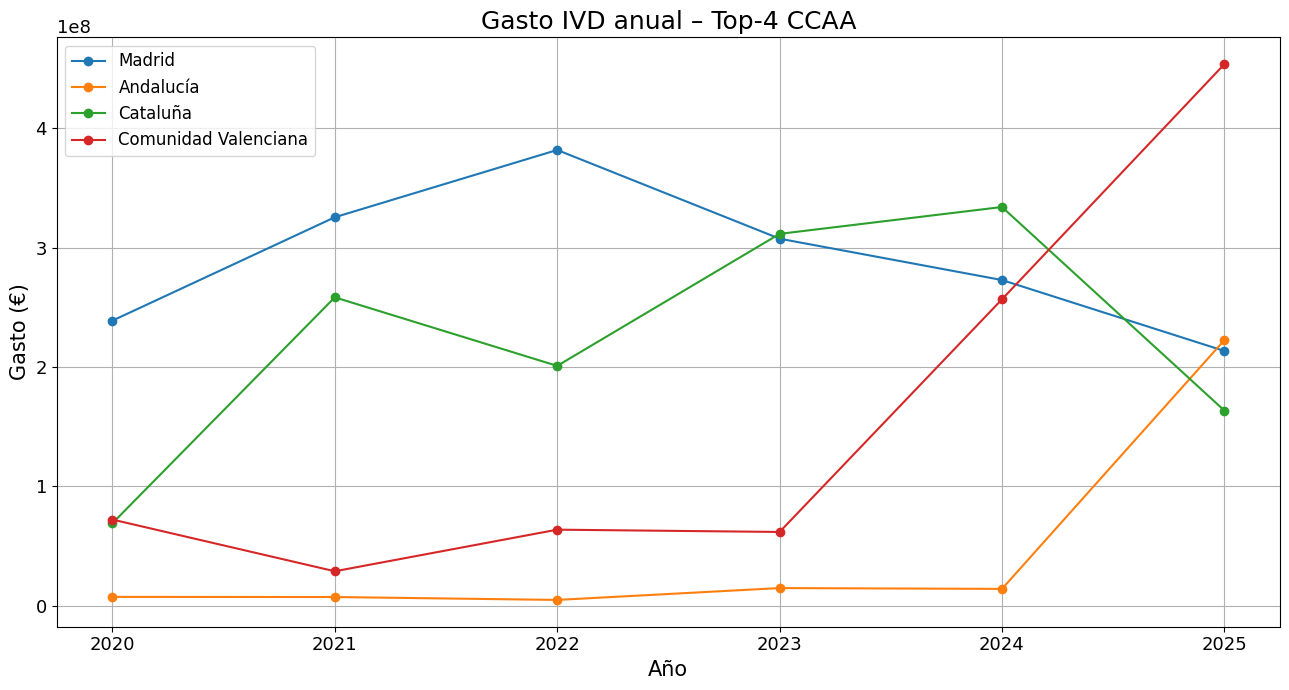

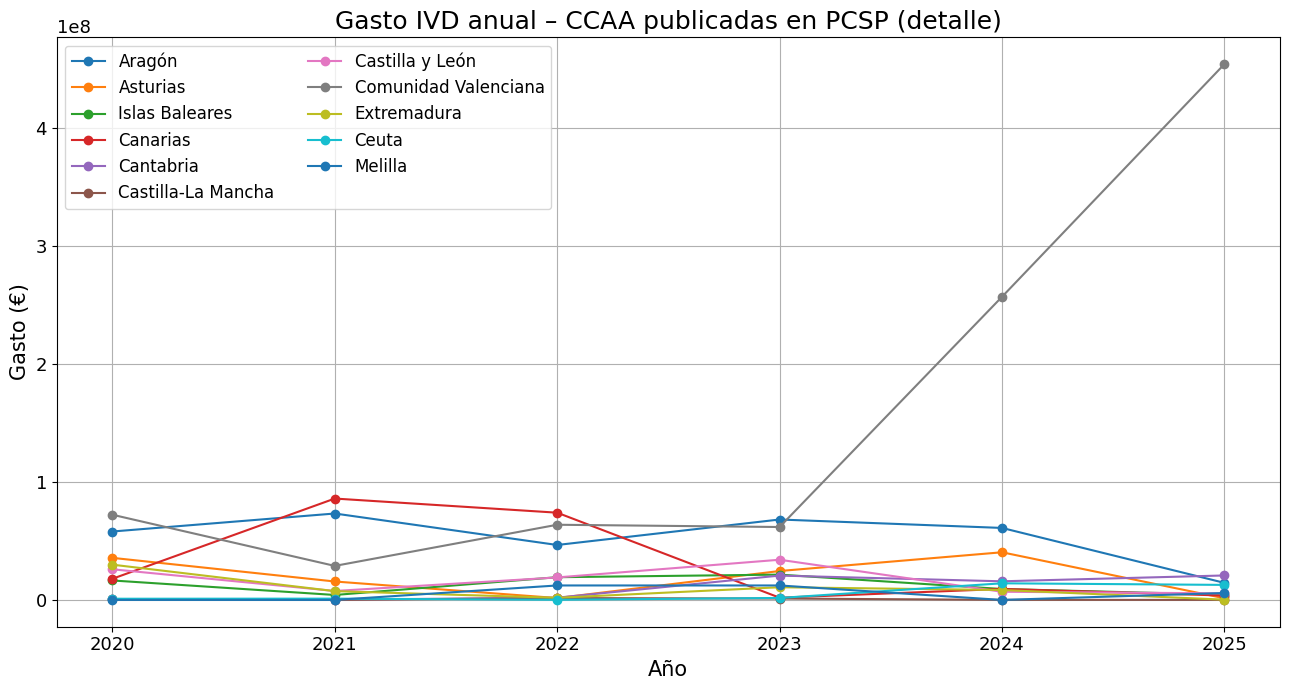

In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt

# ===================== Config =====================
YEARS = list(range(2020, 2026))
BASE_PCSP = "/content/drive/MyDrive/Data/Definitivos"              # Licitaciones_IVD_{YYYY}_Definitivo.csv
CAT_DIR   = "/content/drive/MyDrive/Data/Definitivos/Cataluña"    # Licitaciones_IVD_Cataluna_{YYYY}.csv
MAD_DIR   = "/content/drive/MyDrive/Data/Definitivos/Madrid"       # Licitaciones_IVD_Madrid_{YYYY}.csv
AND_DIR   = "/content/drive/MyDrive/Data/Definitivos/Andalucia"    # Licitaciones_IVD_Andalucia_{YYYY}.csv

MAD_EXTRA = f"{MAD_DIR}/Licitaciones_IVD_Madrid_Extra.csv"
AND_EXTRA = f"{AND_DIR}/Licitaciones_IVD_Andalucia_Extra.csv"

TOP4 = ["Madrid","Andalucía","Cataluña","Comunidad Valenciana"]
PCSP_CCAA = [
    "Aragón","Asturias","Islas Baleares","Canarias","Cantabria",
    "Castilla-La Mancha","Castilla y León","Comunidad Valenciana",
    "Extremadura","Región de Murcia","La Rioja","Ceuta","Melilla",
]

plt.rcParams.update({
    'figure.figsize': (13, 7), 'axes.grid': True,
    'axes.titlesize': 18, 'axes.labelsize': 15,
    'xtick.labelsize': 13, 'ytick.labelsize': 13, 'legend.fontsize': 12,
})

# ===================== Helpers =====================
def _read(path):
    """Lee CSV y asegura 'Presupuesto' numérico; NO toca 'Fecha' ni calcula 'Año'."""
    if not os.path.exists(path):
        return pd.DataFrame()
    df = pd.read_csv(path, encoding='utf-8-sig')
    if 'Presupuesto' in df.columns:
        df['Presupuesto'] = pd.to_numeric(df['Presupuesto'], errors='coerce').fillna(0.0)
    return df

def carga_pcsp_year(y):
    return _read(f"{BASE_PCSP}/Licitaciones_IVD_{y}_Definitivo.csv").assign(Año=y)

def carga_cat_year(y):
    return _read(f"{CAT_DIR}/Licitaciones_IVD_Cataluna_{y}.csv").assign(Año=y)

def carga_mad_year(y, include_extra=False):
    df = _read(f"{MAD_DIR}/Licitaciones_IVD_Madrid_{y}.csv").assign(Año=y)
    if include_extra and os.path.exists(MAD_EXTRA):
        extra = _read(MAD_EXTRA)
        # si el Extra no tiene 'Año', lo asignamos aquí para evitar .dt
        if 'Año' not in extra.columns:
            extra = extra.assign(Año=y)
        df = pd.concat([df, extra[extra['Año']==y]], ignore_index=True)
    return df

def carga_and_year(y):
    return _read(f"{AND_DIR}/Licitaciones_IVD_Andalucia_{y}.csv").assign(Año=y)

def total_extra_csv(path):
    if not os.path.exists(path): return 0.0
    df = _read(path)
    return df['Presupuesto'].sum() if 'Presupuesto' in df.columns else 0.0

# ===================== Construye df_ccaa_full UNA VEZ =====================
frames = []
for y in YEARS:
    for df in (carga_pcsp_year(y),
               carga_cat_year(y),
               carga_mad_year(y, include_extra=False),  # SIN extra (se suma después)
               carga_and_year(y)):
        if not df.empty:
            # tipado por seguridad
            if 'Presupuesto' in df.columns:
                df['Presupuesto'] = pd.to_numeric(df['Presupuesto'], errors='coerce').fillna(0.0)
            df['Año'] = y
            frames.append(df)

df_ccaa_full = pd.concat(frames, ignore_index=True) if frames else pd.DataFrame()
if df_ccaa_full.empty:
    raise RuntimeError("No se han encontrado datos para construir df_ccaa_full.")

# columna homogénea de gasto
df_ccaa_full['Gasto (€)'] = df_ccaa_full['Presupuesto'].astype(float)

# ===================== Aplica EXTRAS (misma cantidad a CADA año) =====================
tot_mad = total_extra_csv(MAD_EXTRA)
tot_and = total_extra_csv(AND_EXTRA)
for y in YEARS:
    df_ccaa_full.loc[(df_ccaa_full['CCAA']=='Madrid') & (df_ccaa_full['Año']==y), 'Gasto (€)']     += tot_mad
    df_ccaa_full.loc[(df_ccaa_full['CCAA']=='Andalucía') & (df_ccaa_full['Año']==y), 'Gasto (€)'] += tot_and

# ===================== Agregados por año =====================
df_top4 = (df_ccaa_full[df_ccaa_full['CCAA'].isin(TOP4)]
           .groupby(['Año','CCAA'], as_index=False)['Gasto (€)'].sum()
           .pivot(index='Año', columns='CCAA', values='Gasto (€)')
           .reindex(YEARS).fillna(0.0))

df_pcsp = (df_ccaa_full[df_ccaa_full['CCAA'].isin(PCSP_CCAA)]
           .groupby(['Año','CCAA'], as_index=False)['Gasto (€)'].sum()
           .pivot(index='Año', columns='CCAA', values='Gasto (€)')
           .reindex(YEARS).fillna(0.0))

# ===================== Plot =====================
# 1) Top-4 (líneas)
plt.figure()
for ccaa in TOP4:
    if ccaa in df_top4.columns:
        plt.plot(df_top4.index, df_top4[ccaa], marker='o', label=ccaa)
plt.title("Gasto IVD anual – Top-4 CCAA")
plt.xlabel("Año"); plt.ylabel("Gasto (€)")
plt.legend(); plt.tight_layout(); plt.show()

# 2) PCSP detalle (líneas)
plt.figure()
for ccaa in PCSP_CCAA:
    if ccaa in df_pcsp.columns:
        plt.plot(df_pcsp.index, df_pcsp[ccaa], marker='o', label=ccaa)
plt.title("Gasto IVD anual – CCAA publicadas en PCSP (detalle)")
plt.xlabel("Año"); plt.ylabel("Gasto (€)")
plt.legend(ncol=2, frameon=True); plt.tight_layout(); plt.show()






Vamos a crear gráficas a partir de los datos de de cada CCAA

Generamos gráficas variadas:

Gráficas de valores absolutos

## 4.2.1. Análisis territorial: distribución por Comunidad Autónoma
Gasto total en IVD por CCAA (2020–2025)

Número de licitaciones por CCAA (2020–2025)

Gasto medio por licitación por CCAA

Evolución del gasto por CCAA (líneas temporales)

Mapa de calor: distribución regional de gasto acumulado

In [ ]:
import os, re, pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter

# ---------------- Config ----------------
years = range(2020, 2026)
base_path = "/content/drive/MyDrive/Data/Definitivos/"
include_extras_all_years = True  # suma el total del Extra a CADA año

MAD_EXTRA = base_path + "Madrid/Licitaciones_IVD_Madrid_Extra.csv"
AND_EXTRA = base_path + "Andalucia/Licitaciones_IVD_Andalucia_Extra.csv"

TOP4 = ["Madrid", "Andalucía", "Cataluña", "Comunidad Valenciana"]
PCSP_CCAA = [
    "Aragón","Asturias","Islas Baleares","Canarias","Cantabria"
    ,"Castilla y León","Comunidad Valenciana",
    "Extremadura","Ceuta","Melilla",
]


###Gasto total IVD por CCAA (2020–2025)

/tmp/ipython-input-4028033409.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=top4_tot.values, y=top4_tot.index, orient='h', palette='Set2')


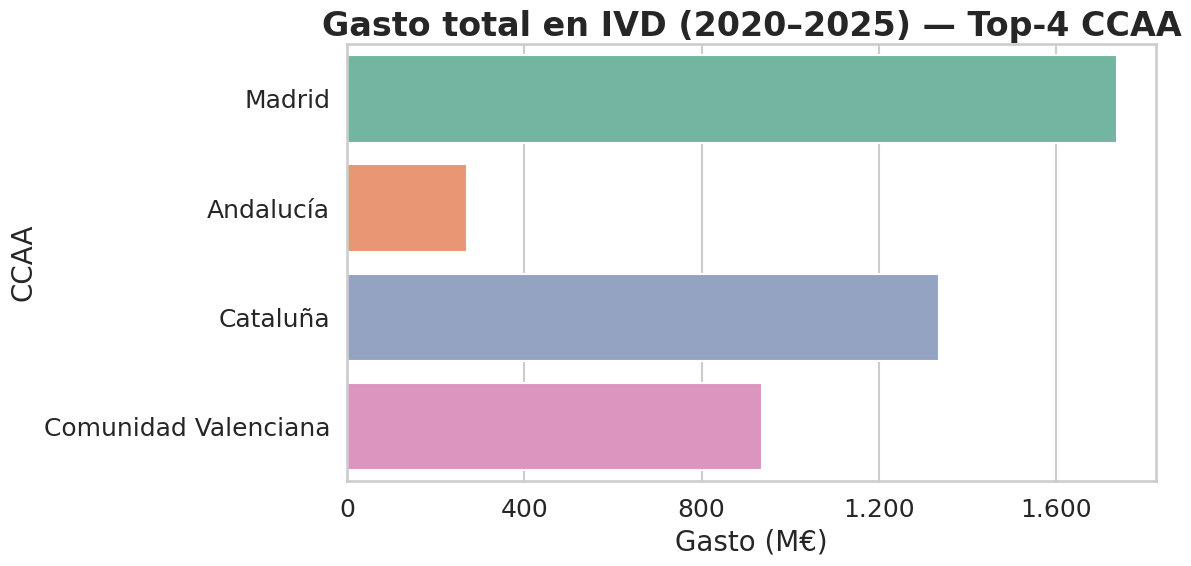

/tmp/ipython-input-4028033409.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


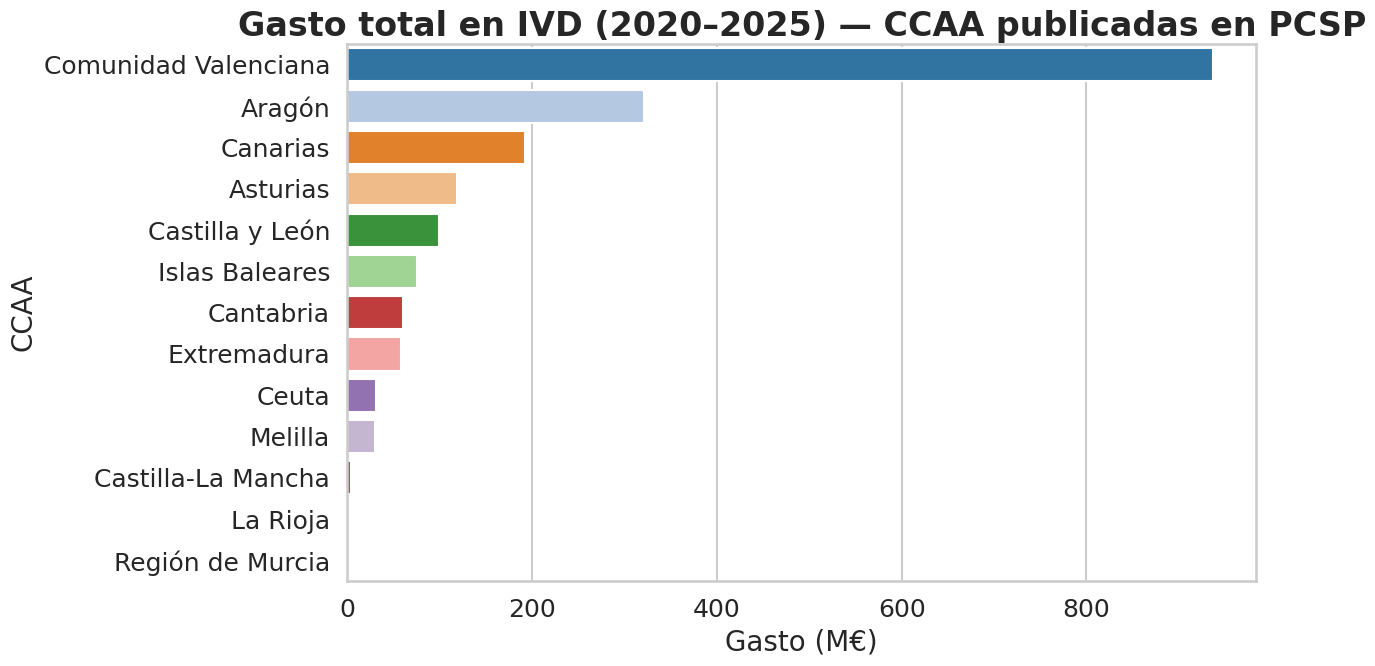

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib.ticker import FuncFormatter

sns.set_style("whitegrid")
sns.set_context("talk")  # dejamos valores por defecto y controlamos fuentes a mano

# Formateador a millones
fmt_millions = mticker.FuncFormatter(lambda x, pos: f"{x/1e6:,.0f}".replace(",", "."))

# Totales 2020–2025
gasto_total = df_ccaa_full.groupby('CCAA', as_index=True)['Gasto (€)'].sum()
top4_tot  = gasto_total.reindex(TOP4).fillna(0.0)
pcsp_tot  = gasto_total.reindex(PCSP_CCAA).fillna(0.0).sort_values(ascending=False)

# 1) Top-4 (barras)
plt.figure(figsize=(12,6))
ax = sns.barplot(x=top4_tot.values, y=top4_tot.index, orient='h', palette='Set2')

# títulos y etiquetas con fuente más grande
ax.set_title("Gasto total en IVD (2020–2025) — Top-4 CCAA", fontsize=24, weight='bold')
ax.set_xlabel("Gasto (M€)", fontsize=20)
ax.set_ylabel("CCAA", fontsize=20)

# ticks más grandes
ax.tick_params(axis='x', labelsize=18)
ax.tick_params(axis='y', labelsize=18)

# formato del eje x
ax.xaxis.set_major_locator(mticker.MaxNLocator(nbins=6))  # ~6 ticks
ax.xaxis.set_major_formatter(fmt_millions)

plt.tight_layout()
plt.show()

# 2) PCSP detalle (barras)
plt.figure(figsize=(13,7))
ax = sns.barplot(
    x=pcsp_tot.values, y=pcsp_tot.index, orient='h',
    palette=sns.color_palette("tab20", n_colors=len(pcsp_tot))
)

ax.set_title("Gasto total en IVD (2020–2025) — CCAA publicadas en PCSP", fontsize=24, weight='bold')
ax.set_xlabel("Gasto (M€)", fontsize=20)
ax.set_ylabel("CCAA", fontsize=20)

ax.tick_params(axis='x', labelsize=18)
ax.tick_params(axis='y', labelsize=18)

ax.xaxis.set_major_locator(mticker.MaxNLocator(nbins=6))
ax.xaxis.set_major_formatter(fmt_millions)

plt.tight_layout()
plt.show()



/tmp/ipython-input-2824383256.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=gasto_total.values, y=gasto_total.index, palette="viridis")


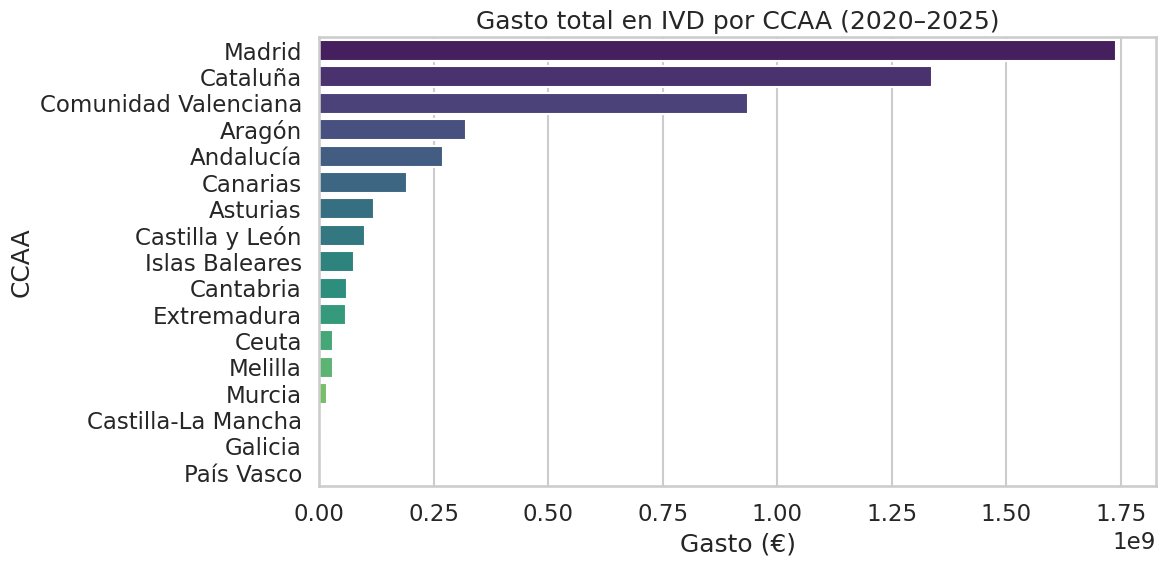

In [ ]:
gasto_total = df_ccaa_full.groupby("CCAA")["Gasto (€)"].sum().sort_values(ascending=False)
plt.figure(figsize=(12, 6))
sns.barplot(x=gasto_total.values, y=gasto_total.index, palette="viridis")
plt.title("Gasto total en IVD por CCAA (2020–2025)")
plt.xlabel("Gasto (€)")
plt.ylabel("CCAA")
plt.tight_layout()
plt.show()


###Evolución por CCAA (2020–2025)


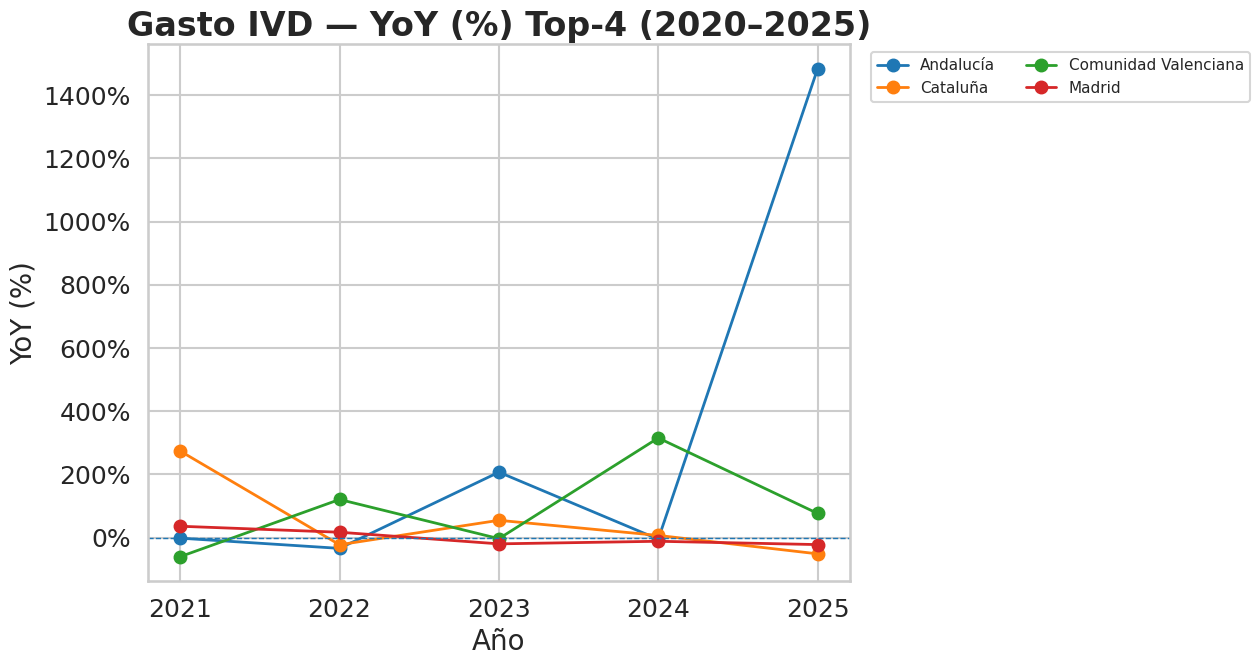

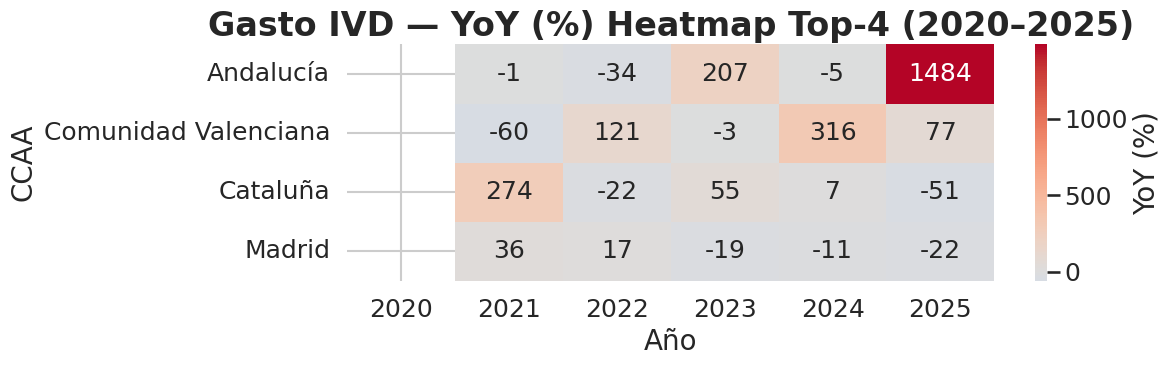

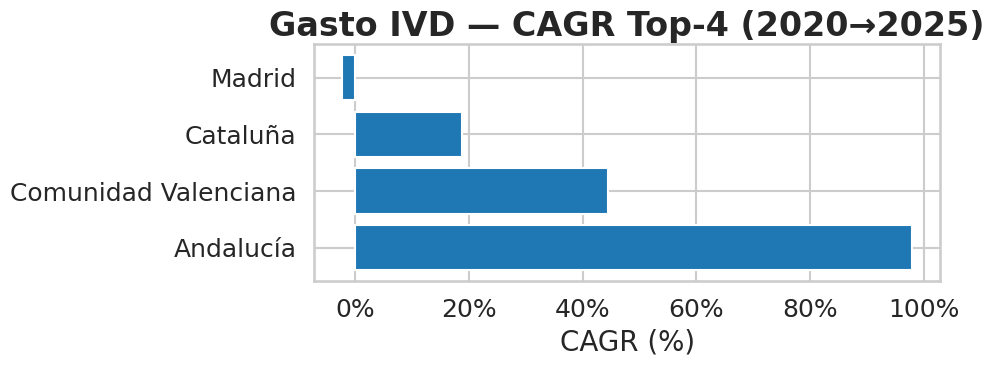

/tmp/ipython-input-1635760020.py:68: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  return pivot_df.replace(0, np.nan).pct_change()*100


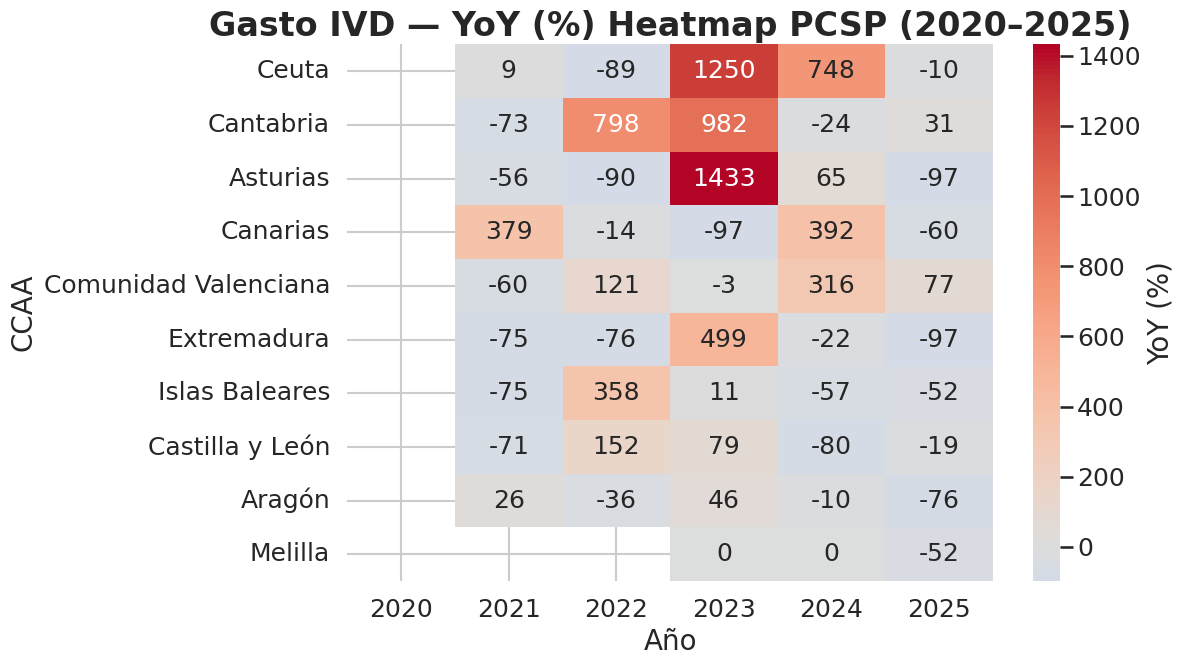

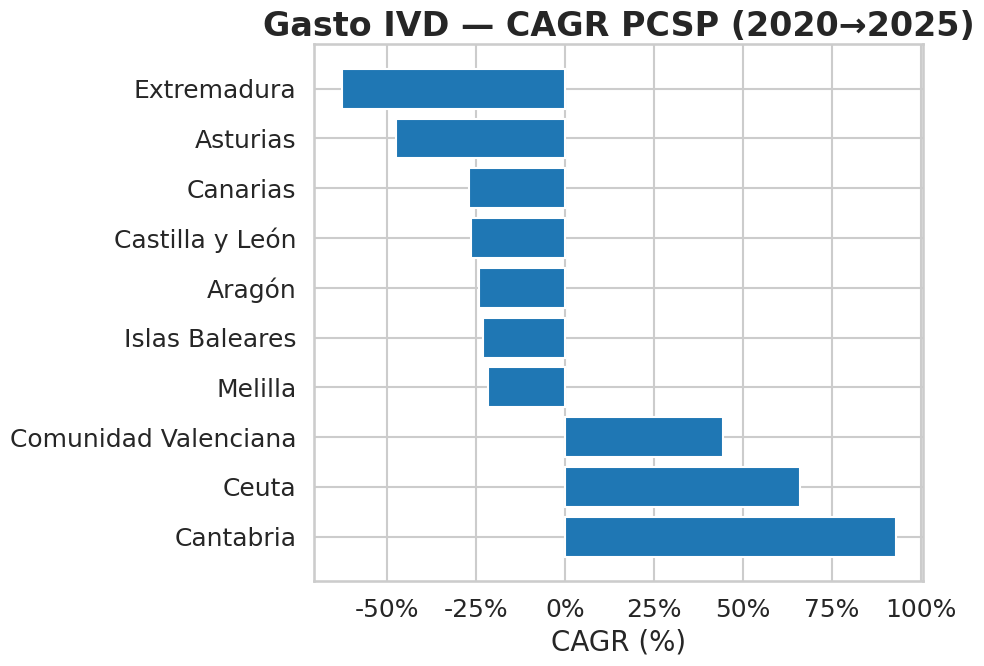

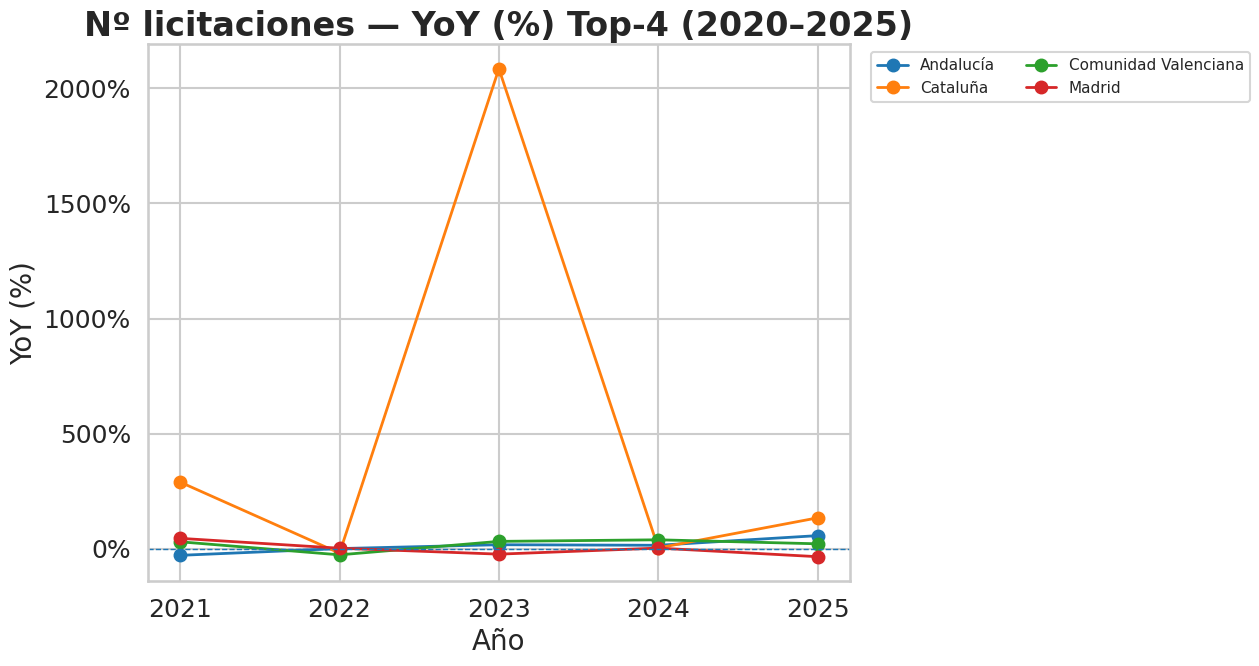

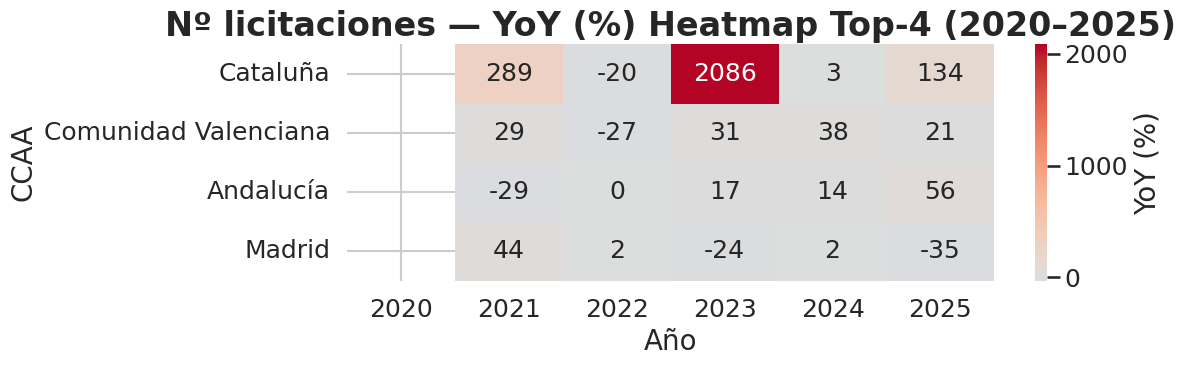

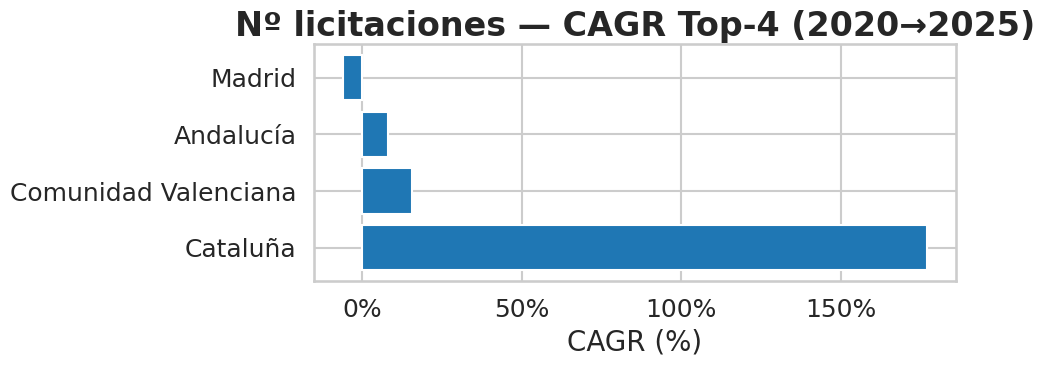

/tmp/ipython-input-1635760020.py:68: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  return pivot_df.replace(0, np.nan).pct_change()*100


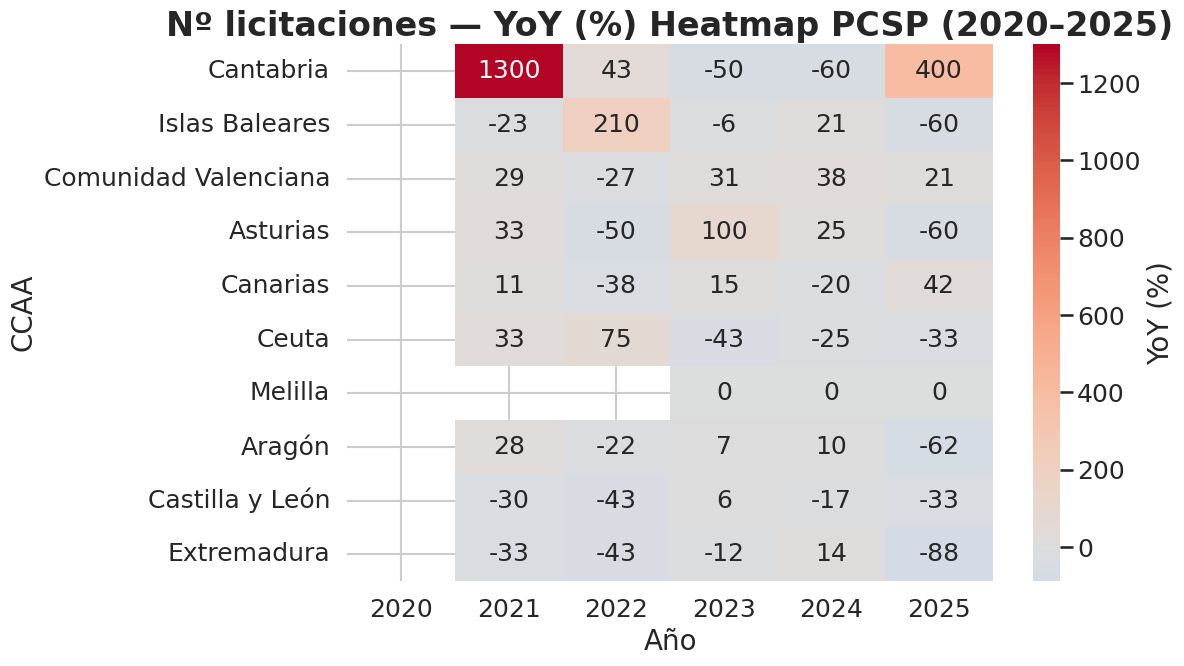

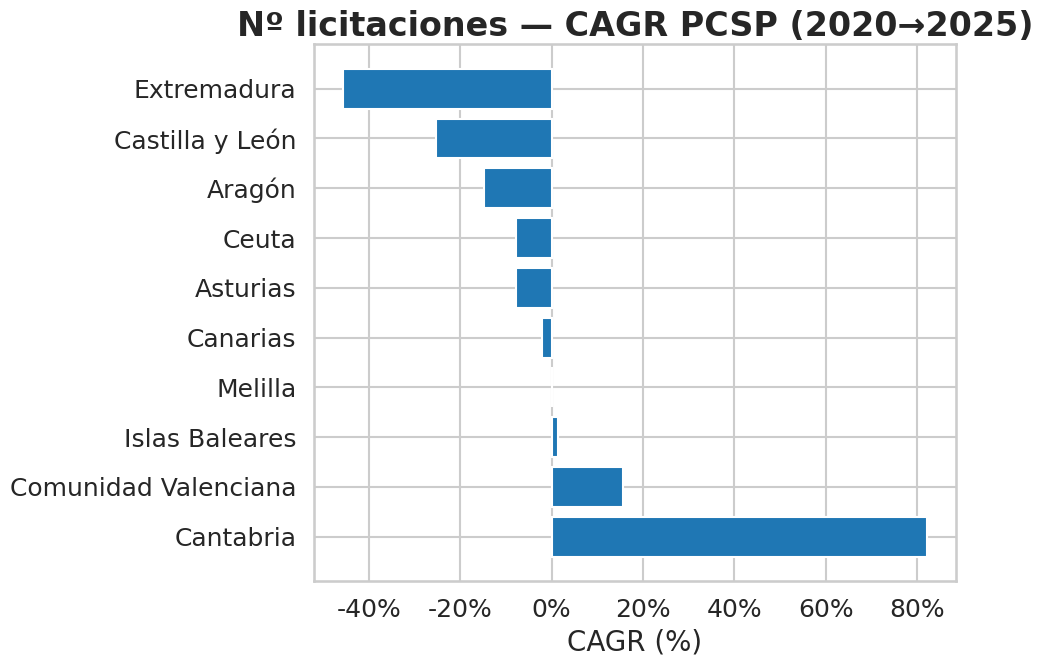

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import pandas as pd
import numpy as np
import seaborn as sns

# ================== Config global (MISMA FUENTE QUE TUS GRÁFICAS) ==================
FONT_TITLE = 24
FONT_LABEL = 20
FONT_TICKS = 18

plt.rcParams.update({
    "figure.figsize": (13, 7),
    "axes.grid": True,
    "axes.titlesize": FONT_TITLE,   # no siempre respeta, por eso forzamos en funciones
    "axes.labelsize": FONT_LABEL,
    "xtick.labelsize": FONT_TICKS,
    "ytick.labelsize": FONT_TICKS,
    "legend.fontsize": 11,
})
sns.set_style("whitegrid")

YEARS = list(range(2020, 2026))
fmt_pct = mticker.FuncFormatter(lambda x, _: f"{x:.0f}%")

# ================== Switches para no saturar ==================
PLOT_YOY_LINES_TOP4 = True      # líneas YoY solo para Top-4
PLOT_HEATMAP_ALL    = True      # heatmap YoY para todos los grupos
PLOT_CAGR_ALL       = True      # barras de CAGR para todos los grupos

# ================== Utilidades ==================
def pick_first_existing(df, candidates):
    for c in candidates:
        if c in df.columns:
            return c
    raise KeyError(f"No encuentro ninguna de estas columnas en el DataFrame: {candidates}")

def apply_axis_fonts(ax, title=None, xlabel=None, ylabel=None):
    """Aplica la misma tipografía que usas en el resto: título 24 bold, ejes 20, ticks 18."""
    if title is not None:
        ax.set_title(title, fontsize=FONT_TITLE, weight='bold')
    if xlabel is not None:
        ax.set_xlabel(xlabel, fontsize=FONT_LABEL)
    if ylabel is not None:
        ax.set_ylabel(ylabel, fontsize=FONT_LABEL)
    ax.tick_params(axis='both', labelsize=FONT_TICKS)

def pivot_sum_metric(df, ccaa_list, value_col):
    g = (df[df["CCAA"].isin(ccaa_list)]
         .groupby(["Año","CCAA"], as_index=False)[value_col].sum())
    p = (g.pivot(index="Año", columns="CCAA", values=value_col)
           .reindex(YEARS).fillna(0.0))
    return p

def pivot_count_metric(df, ccaa_list, id_col="ID"):
    sub = df[df["CCAA"].isin(ccaa_list)].copy()
    if id_col in sub.columns:
        g = (sub.groupby(["Año","CCAA"], as_index=False)[id_col].nunique()
               .rename(columns={id_col: "count"}))
    else:
        g = (sub.groupby(["Año","CCAA"], as_index=False).size()
               .rename(columns={"size": "count"}))
    p = (g.pivot(index="Año", columns="CCAA", values="count")
           .reindex(YEARS).fillna(0).astype(int))
    return p

def yoy_percent(pivot_df):
    return pivot_df.replace(0, np.nan).pct_change()*100

def cagr_percent(pivot_df):
    cagr = {}
    for c in pivot_df.columns:
        s = pivot_df[c].replace(0, np.nan).dropna()
        if len(s) >= 2:
            y0, yN = s.iloc[0], s.iloc[-1]
            n_years = s.index[-1] - s.index[0]
            if n_years > 0 and y0 > 0:
                cagr[c] = ((yN / y0)**(1/n_years) - 1) * 100
            else:
                cagr[c] = np.nan
        else:
            cagr[c] = np.nan
    return pd.Series(cagr).sort_values(ascending=False)

def classify_trend(pivot_df):
    trends = {}
    for c in pivot_df.columns:
        s = pivot_df[c].astype(float)
        x = s.index.values
        y = s.values
        if np.isfinite(y).sum() >= 2:
            slope = np.polyfit(x, y, 1)[0]
            trends[c] = "Creciente" if slope > 0 else ("Decreciente" if slope < 0 else "Plana")
        else:
            trends[c] = "Insuf. datos"
    return pd.Series(trends)

# ---- Plots (con fuentes uniformes) ----
def plot_yoy_lines(yoy_df, title):
    fig, ax = plt.subplots(figsize=(13,7))
    for c in yoy_df.columns:
        ax.plot(yoy_df.index, yoy_df[c], marker='o', linewidth=2, label=c)
    ax.axhline(0, linestyle='--', linewidth=1)
    apply_axis_fonts(ax, title=title, xlabel="Año", ylabel="YoY (%)")
    ax.xaxis.set_major_locator(mticker.MaxNLocator(integer=True))
    ax.yaxis.set_major_formatter(fmt_pct)
    ax.legend(ncol=2, bbox_to_anchor=(1.02, 1), loc="upper left")
    plt.tight_layout()
    plt.show()

def plot_yoy_heatmap(yoy_df, title):
    order = yoy_df.mean(skipna=True).sort_values(ascending=False).index
    fig, ax = plt.subplots(figsize=(12, 0.5*len(order)+2))
    sns.heatmap(yoy_df[order].T, cmap="coolwarm", center=0, annot=True, fmt=".0f",
                cbar_kws={"label": "YoY (%)"}, ax=ax)
    apply_axis_fonts(ax, title=title, xlabel="Año", ylabel="CCAA")
    plt.tight_layout()
    plt.show()

def plot_cagr_barh(cagr_s, title):
    fig, ax = plt.subplots(figsize=(10, 0.5*len(cagr_s)+2))
    ax.barh(cagr_s.index, cagr_s.values)
    apply_axis_fonts(ax, title=title, xlabel="CAGR (%)", ylabel=None)
    ax.xaxis.set_major_formatter(fmt_pct)
    plt.tight_layout()
    plt.show()

# ================== Listas de CCAA (ajusta según tu notebook) ==================
# TOP4 = ["Madrid","Andalucía","Cataluña","Comunidad Valenciana"]
# PCSP_CCAA = ["Aragón","Asturias","Islas Baleares","Canarias","Cantabria",
#              "Castilla y León","Comunidad Valenciana","Extremadura","Ceuta","Melilla"]

# ================== Columnas / datos base ==================
GASTO_COL = pick_first_existing(df_ccaa_full, ["Gasto (€)", "Gasto", "Importe", "Importe (€)"])

# ================== 1) GASTO ==================
for group_name, ccaa_list in [("Top-4", TOP4), ("PCSP", PCSP_CCAA)]:
    p_gasto = pivot_sum_metric(df_ccaa_full, ccaa_list, GASTO_COL)
    yoy_gasto = yoy_percent(p_gasto)
    cagr_gasto = cagr_percent(p_gasto)

    if group_name == "Top-4" and PLOT_YOY_LINES_TOP4:
        plot_yoy_lines(yoy_gasto, f"Gasto IVD — YoY (%) {group_name} (2020–2025)")

    if PLOT_HEATMAP_ALL:
        plot_yoy_heatmap(yoy_gasto, f"Gasto IVD — YoY (%) Heatmap {group_name} (2020–2025)")

    if PLOT_CAGR_ALL:
        plot_cagr_barh(cagr_gasto, f"Gasto IVD — CAGR {group_name} (2020→2025)")

    # Si quieres una tabla rápida de tendencia:
    # trend_gasto = classify_trend(p_gasto)
    # display(pd.DataFrame({"Tendencia (regresión lineal)": trend_gasto}))

# ================== 2) Nº DE LICITACIONES (conteo por año-CCAA) ==================
for group_name, ccaa_list in [("Top-4", TOP4), ("PCSP", PCSP_CCAA)]:
    p_cnt = pivot_count_metric(df_ccaa_full, ccaa_list, id_col="ID")
    yoy_cnt = yoy_percent(p_cnt)
    cagr_cnt = cagr_percent(p_cnt)

    if group_name == "Top-4" and PLOT_YOY_LINES_TOP4:
        plot_yoy_lines(yoy_cnt, f"Nº licitaciones — YoY (%) {group_name} (2020–2025)")

    if PLOT_HEATMAP_ALL:
        plot_yoy_heatmap(yoy_cnt, f"Nº licitaciones — YoY (%) Heatmap {group_name} (2020–2025)")

    if PLOT_CAGR_ALL:
        plot_cagr_barh(cagr_cnt, f"Nº licitaciones — CAGR {group_name} (2020→2025)")


###Gasto medio por licitación por CCAA

/tmp/ipython-input-2678365213.py:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


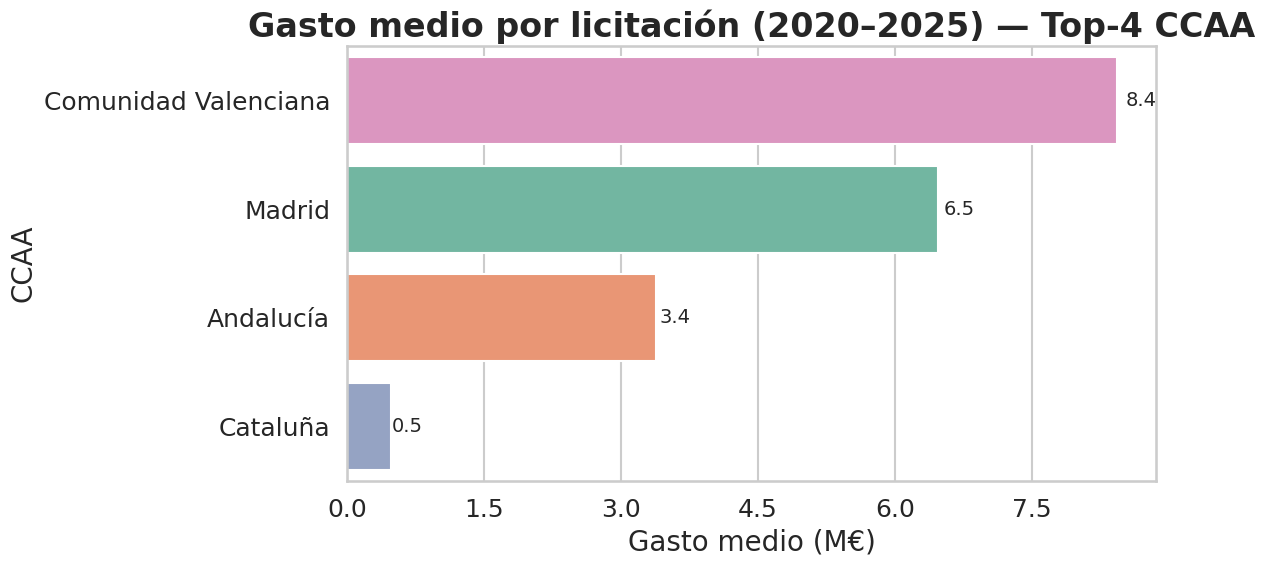

/tmp/ipython-input-2678365213.py:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


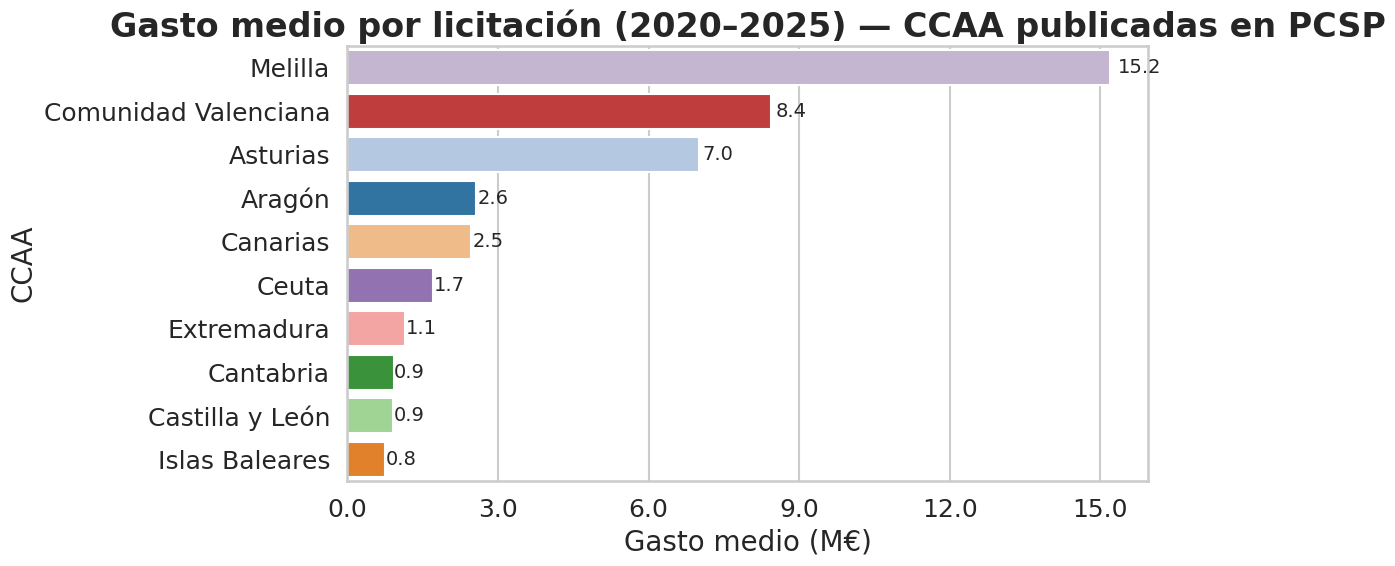

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import pandas as pd

# --- conteos y totales ---
if 'ID' in df_ccaa_full.columns:
    n_lic = df_ccaa_full.groupby('CCAA')['ID'].nunique()
else:
    n_lic = df_ccaa_full.groupby('CCAA').size()

gasto_tot = df_ccaa_full.groupby('CCAA')['Gasto (€)'].sum()

df_gasto_medio = (pd.concat([gasto_tot, n_lic.rename('N_Licitaciones')], axis=1)
                    .fillna(0))
# evita divisiones por 0
df_gasto_medio['Gasto Medio (€)'] = df_gasto_medio.apply(
    lambda r: r['Gasto (€)']/r['N_Licitaciones'] if r['N_Licitaciones']>0 else 0.0, axis=1
)

# --- subsets ordenados ---
top4_medio = (df_gasto_medio.reindex(TOP4)
                           .dropna(subset=['Gasto Medio (€)'])
                           .sort_values('Gasto Medio (€)', ascending=False))
pcsp_medio = (df_gasto_medio.reindex(PCSP_CCAA)
                           .dropna(subset=['Gasto Medio (€)'])
                           .sort_values('Gasto Medio (€)', ascending=False))

# --- estilo y formateo ---
sns.set_style("whitegrid")
sns.set_context("talk")

fmt_M = mticker.FuncFormatter(lambda x, _: f"{x/1e6:,.1f}".replace(",", "."))  # 1 decimal en M€

# --- paleta consistente con las gráficas anteriores ---
# Puedes ajustar aquí los colores que ya usaste (Set2 para Top4, tab20 para PCSP)
palette_top4 = dict(zip(TOP4, sns.color_palette("Set2", n_colors=len(TOP4))))
palette_pcsp = dict(zip(PCSP_CCAA, sns.color_palette("tab20", n_colors=len(PCSP_CCAA))))

def plot_bar_medio(s, title, palette):
    plt.figure(figsize=(12,6))
    ax = sns.barplot(
        x=s['Gasto Medio (€)'].values,
        y=s.index,
        orient='h',
        palette=[palette[ccaa] for ccaa in s.index]  # colores fijos por CCAA
    )

    # formato de títulos y ejes
    ax.set_title(title, fontsize=24, weight='bold')
    ax.set_xlabel("Gasto medio (M€)", fontsize=20)
    ax.set_ylabel("CCAA", fontsize=20)
    ax.tick_params(axis='x', labelsize=18)
    ax.tick_params(axis='y', labelsize=18)

    # formato de eje X
    ax.xaxis.set_major_locator(mticker.MaxNLocator(nbins=6))
    ax.xaxis.set_major_formatter(fmt_M)

    # anotaciones encima de las barras
    for p, val in zip(ax.patches, s['Gasto Medio (€)'].values):
        ax.text(p.get_width()*1.01, p.get_y()+p.get_height()/2,
                f"{val/1e6:,.1f}".replace(",", "."),
                va='center', ha='left', fontsize=14)

    plt.tight_layout()
    plt.show()

# --- gráficos ---
plot_bar_medio(top4_medio, "Gasto medio por licitación (2020–2025) — Top-4 CCAA", palette_top4)
plot_bar_medio(pcsp_medio, "Gasto medio por licitación (2020–2025) — CCAA publicadas en PCSP", palette_pcsp)




###Evolución del gasto por CCAA (líneas temporales)

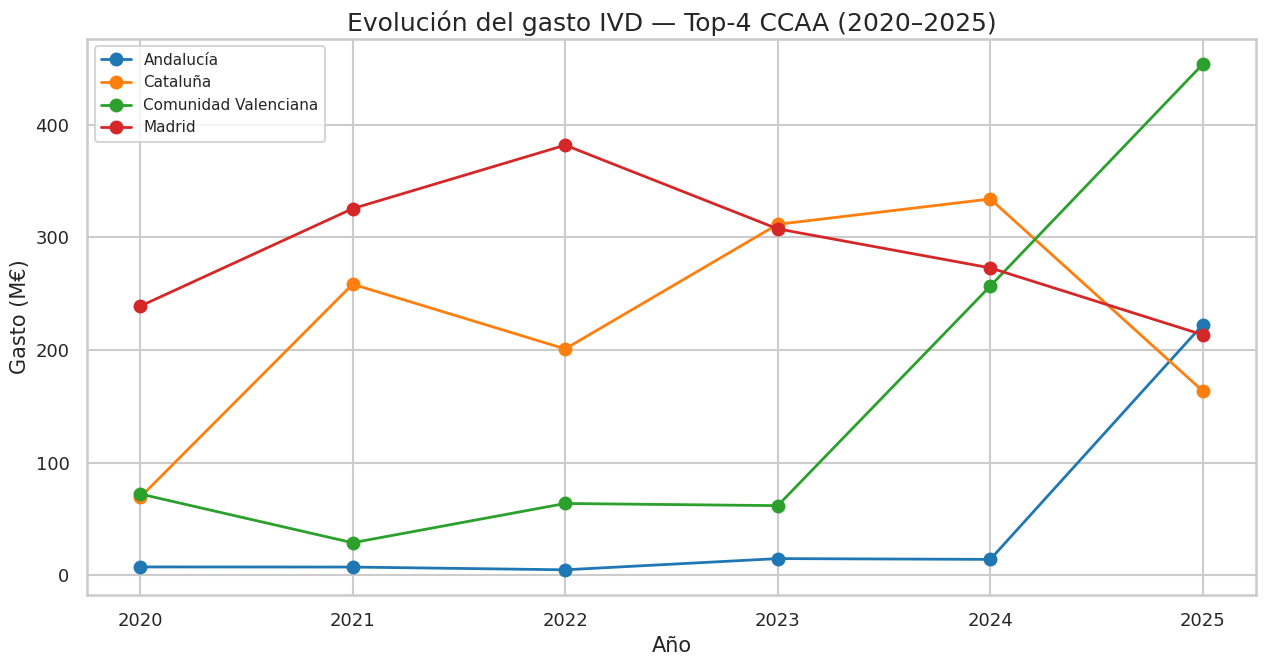

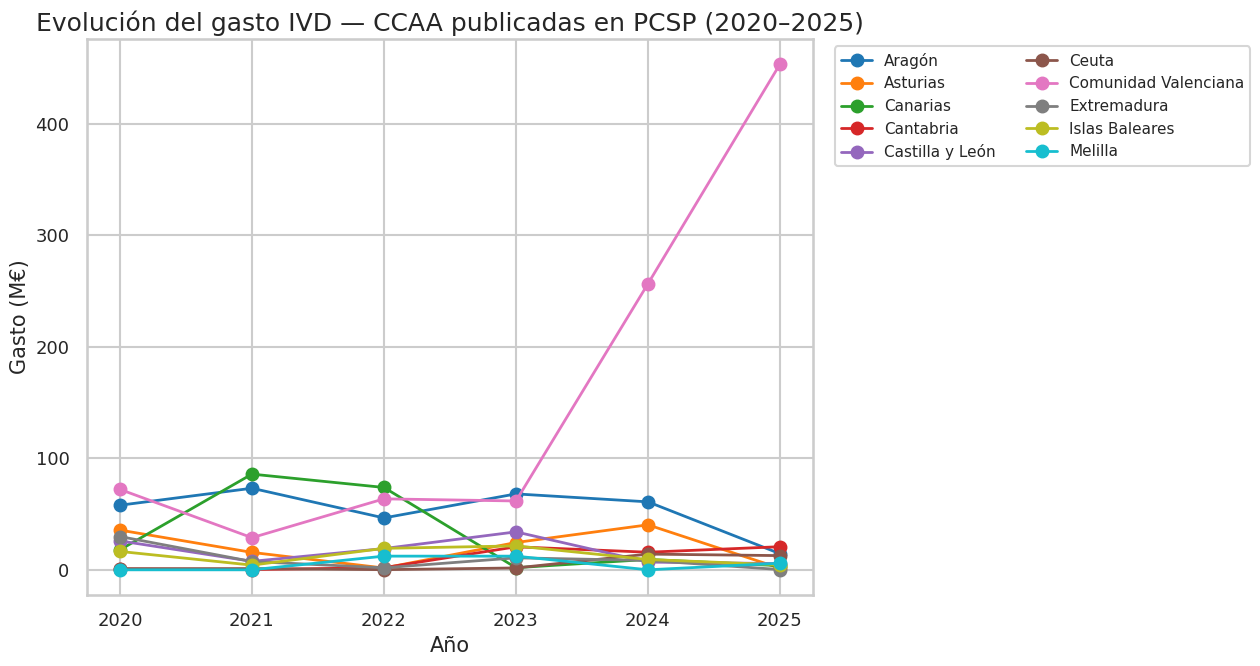

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import pandas as pd

# --- Config común ---
YEARS = list(range(2020, 2026))
plt.rcParams.update({
    "figure.figsize": (13, 7),
    "axes.grid": True,
    "axes.titlesize": 18,
    "axes.labelsize": 15,
    "xtick.labelsize": 13,
    "ytick.labelsize": 13,
    "legend.fontsize": 11,
})
fmt_M = mticker.FuncFormatter(lambda x, _: f"{x/1e6:,.0f}".replace(",", "."))

# --- Listas ya definidas en tu notebook ---
# TOP4 = ["Madrid","Andalucía","Cataluña","Comunidad Valenciana"]
# PCSP_CCAA = ["Aragón","Asturias","Islas Baleares","Canarias","Cantabria",
#              "Castilla-La Mancha","Castilla y León","Comunidad Valenciana",
#              "Extremadura","Región de Murcia","La Rioja","Ceuta","Melilla"]

def pivot_ccaa(df, ccaa_list):
    g = (df[df["CCAA"].isin(ccaa_list)]
         .groupby(["Año","CCAA"], as_index=False)["Gasto (€)"].sum())
    p = (g.pivot(index="Año", columns="CCAA", values="Gasto (€)")
           .reindex(YEARS).fillna(0.0))
    return p

# ================== Top-4 ==================
p_top4 = pivot_ccaa(df_ccaa_full, TOP4)

plt.figure()
for ccaa in p_top4.columns:
    plt.plot(p_top4.index, p_top4[ccaa], marker='o', linewidth=2, label=ccaa)
plt.title("Evolución del gasto IVD — Top-4 CCAA (2020–2025)")
plt.xlabel("Año"); plt.ylabel("Gasto (M€)")
plt.gca().yaxis.set_major_formatter(fmt_M)
plt.xticks(YEARS)
plt.legend(loc="upper left")
plt.tight_layout()
plt.show()

# ================== Resto PCSP ==================
p_pcsp = pivot_ccaa(df_ccaa_full, PCSP_CCAA)

plt.figure()
for ccaa in p_pcsp.columns:
    plt.plot(p_pcsp.index, p_pcsp[ccaa], marker='o', linewidth=2, label=ccaa)
plt.title("Evolución del gasto IVD — CCAA publicadas en PCSP (2020–2025)")
plt.xlabel("Año"); plt.ylabel("Gasto (M€)")
plt.gca().yaxis.set_major_formatter(fmt_M)
plt.xticks(YEARS)
plt.legend(ncol=2, bbox_to_anchor=(1.02, 1), loc="upper left")  # leyenda fuera
plt.tight_layout()
plt.show()



###Mapa de calor: distribución regional de gasto acumulado

/tmp/ipython-input-1967474948.py:32: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  annot = data.applymap(lambda v: "" if (pd.isna(v) or v == 0) else f"{v:.1f}")


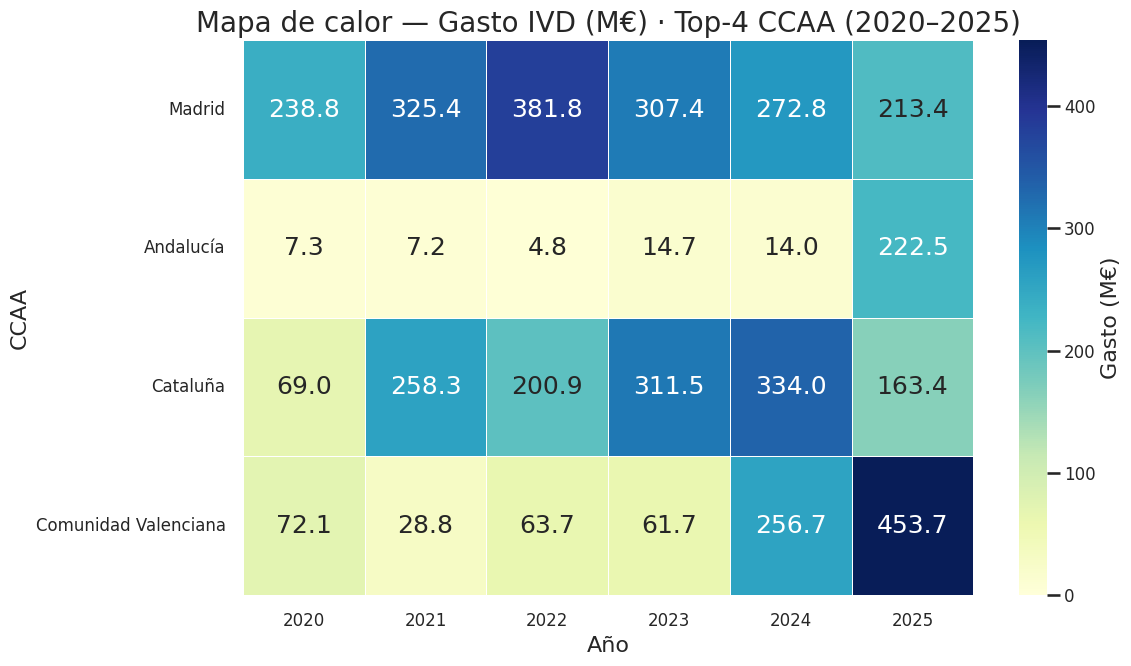

/tmp/ipython-input-1967474948.py:32: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  annot = data.applymap(lambda v: "" if (pd.isna(v) or v == 0) else f"{v:.1f}")


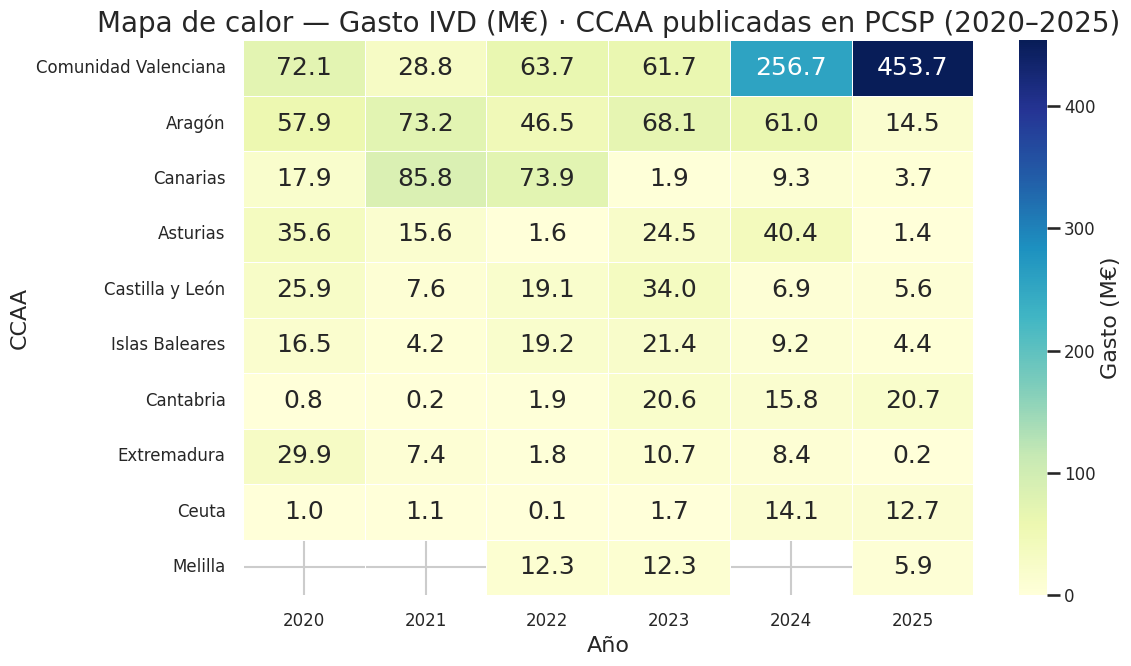

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Asumo que ya tienes:
# df_ccaa_full, YEARS, TOP4, PCSP_CCAA

sns.set_style("whitegrid")
sns.set_context("talk", rc={
    "axes.titlesize": 20, "axes.labelsize": 16,
    "xtick.labelsize": 12, "ytick.labelsize": 12
})

def pivot_ccaa_M(df, ccaa_list, years):
    """Pivot Año×CCAA con gasto en M€."""
    g = (df[df["CCAA"].isin(ccaa_list)]
         .groupby(["Año","CCAA"], as_index=False)["Gasto (€)"].sum())
    p = (g.pivot(index="CCAA", columns="Año", values="Gasto (€)")
           .reindex(ccaa_list)  # respeta el orden dado
           .reindex(columns=years))  # asegura columnas 2020–2025
    return p / 1e6  # a millones

def plot_heatmap(p_M, title, vmax=None, sort_rows=False):
    """Dibuja heatmap con anotaciones en M€ (1 decimal)."""
    data = p_M.copy()
    if sort_rows:
        # ordena filas por total descendente
        data["__total__"] = data.sum(axis=1, numeric_only=True)
        data = data.sort_values("__total__", ascending=False).drop(columns="__total__")
    # strings de anotación (vacías si NaN o 0)
    annot = data.applymap(lambda v: "" if (pd.isna(v) or v == 0) else f"{v:.1f}")
    plt.figure(figsize=(12, 7))
    ax = sns.heatmap(
        data, cmap="YlGnBu", annot=annot, fmt="",
        linewidths=0.5, linecolor="white",
        cbar_kws={"label": "Gasto (M€)"},
        vmin=0, vmax=vmax
    )
    ax.set_title(title)
    ax.set_xlabel("Año")
    ax.set_ylabel("CCAA")
    plt.xticks(rotation=0)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

# --- Pivots a M€ ---
p_top4_M  = pivot_ccaa_M(df_ccaa_full, TOP4, YEARS)
p_pcsp_M  = pivot_ccaa_M(df_ccaa_full, PCSP_CCAA, YEARS)

# --- Escala común para comparar ambos mapas ---
# --- Escala común para comparar ambos mapas (robusto) ---
arrs = [p_top4_M.values, p_pcsp_M.values]
flat = np.concatenate([a.ravel() for a in arrs if a.size > 0])

if flat.size == 0 or np.all(np.isnan(flat)):
    vmax_common = 0.0
else:
    vmax_common = float(np.nanmax(flat))


# --- Heatmap 1: Top-4 (en el orden TOP4) ---
plot_heatmap(p_top4_M, "Mapa de calor — Gasto IVD (M€) · Top-4 CCAA (2020–2025)",
             vmax=vmax_common, sort_rows=False)

# --- Heatmap 2: Resto PCSP (ordenado por total) ---
plot_heatmap(p_pcsp_M, "Mapa de calor — Gasto IVD (M€) · CCAA publicadas en PCSP (2020–2025)",
             vmax=vmax_common, sort_rows=True)


## 4.2.2. Análisis temporal: evolución anual y estacional

Evolución del gasto total anual en IVD

Evolución del número de licitaciones por año

Distribución mensual de licitaciones: patrones estacionales



In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# ===== 1. Cargar datos completos de licitaciones =====
years = range(2020, 2026)
base_path = "/content/drive/MyDrive/Data/Definitivos/"

df_licitaciones_full = pd.DataFrame()

for year in years:
    df = pd.read_csv(f"{base_path}Licitaciones_IVD_{year}_Definitivo.csv")
    df["Año"] = year
    df_licitaciones_full = pd.concat([df_licitaciones_full, df], ignore_index=True)

# ===== 2. Conversión de tipos y columnas auxiliares =====
df_licitaciones_full["Fecha"] = pd.to_datetime(df_licitaciones_full["Fecha"], errors="coerce", utc=True).dt.tz_convert(None)
df_licitaciones_full["Presupuesto"] = pd.to_numeric(df_licitaciones_full["Presupuesto"].astype(str).str.replace('[^0-9.]', '', regex=True), errors='coerce')
df_licitaciones_full["Mes"] = df_licitaciones_full["Fecha"].dt.month
df_licitaciones_full["MesTexto"] = df_licitaciones_full["Fecha"].dt.strftime('%b')


###Evolución del gasto total anual + licitaciones en IVD

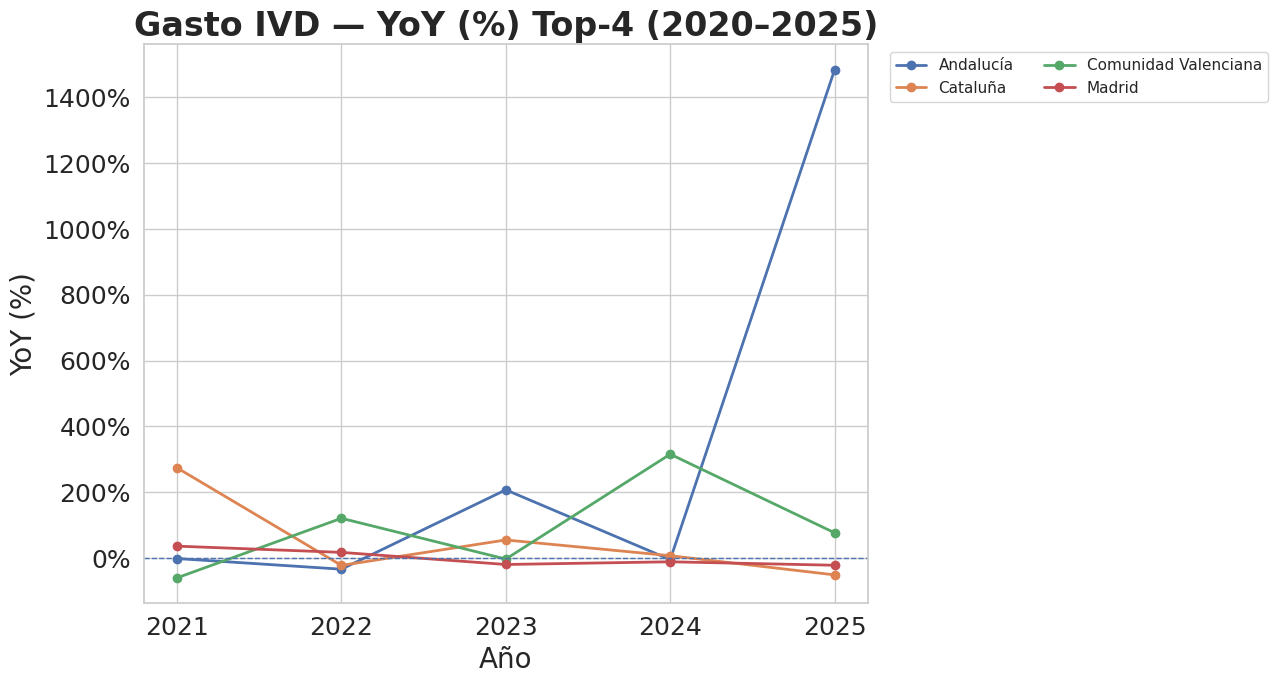

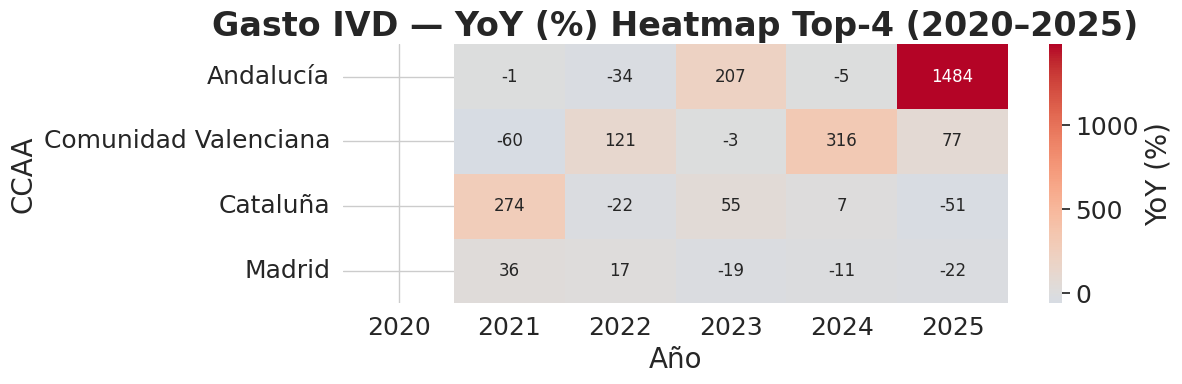

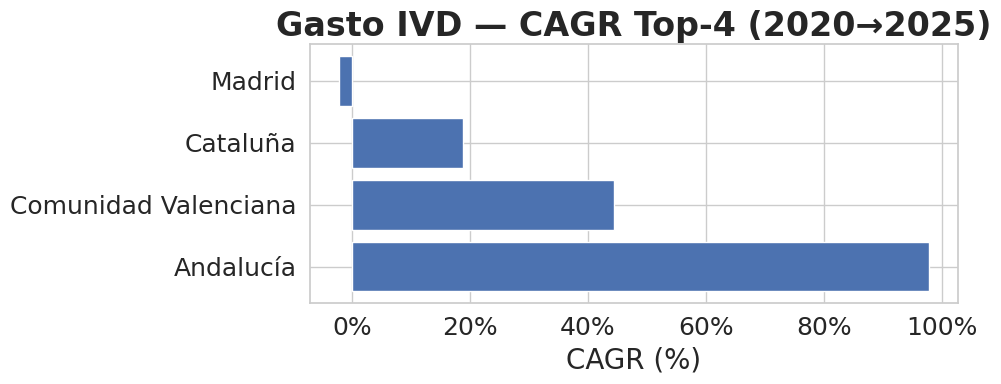

/tmp/ipython-input-1635760020.py:68: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  return pivot_df.replace(0, np.nan).pct_change()*100


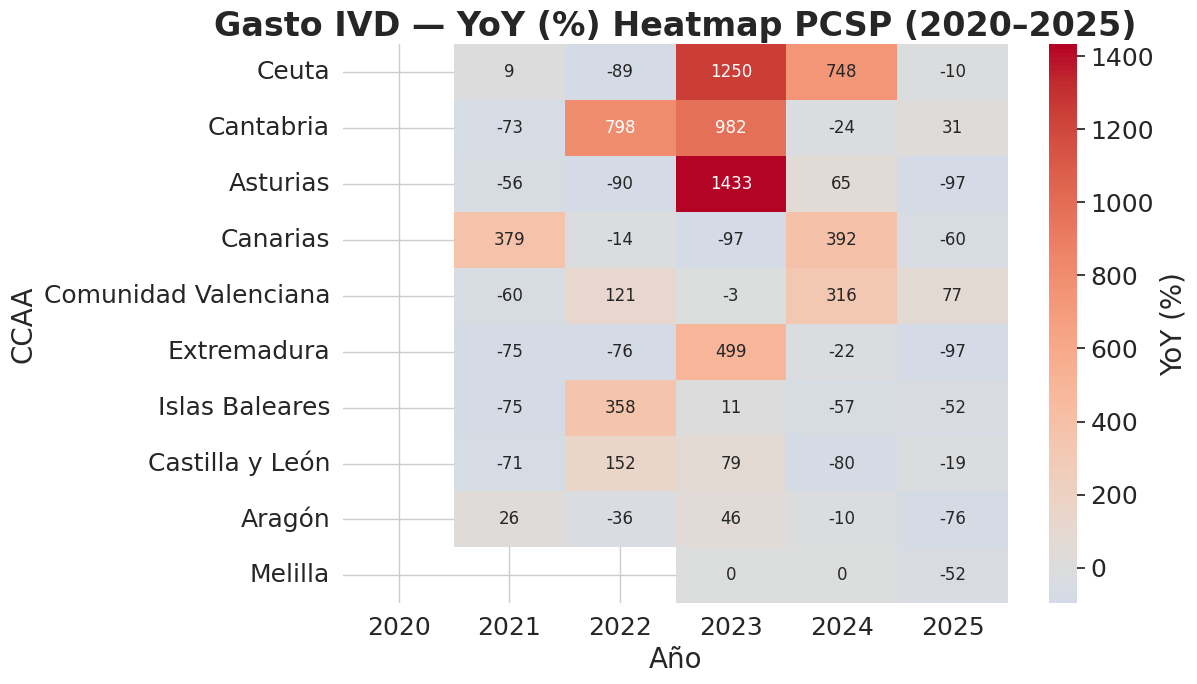

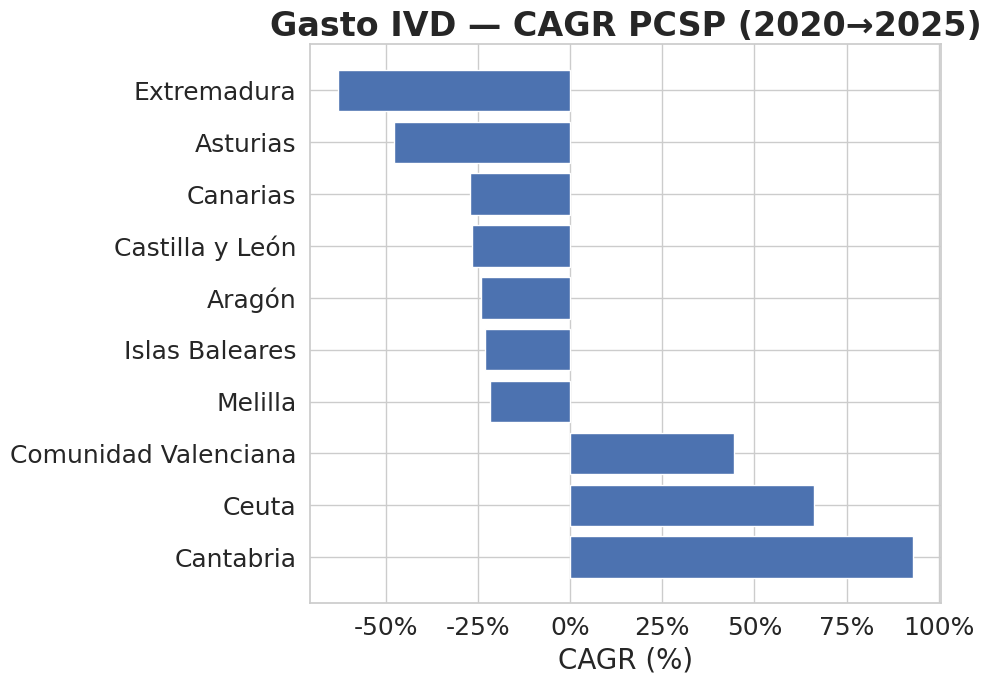

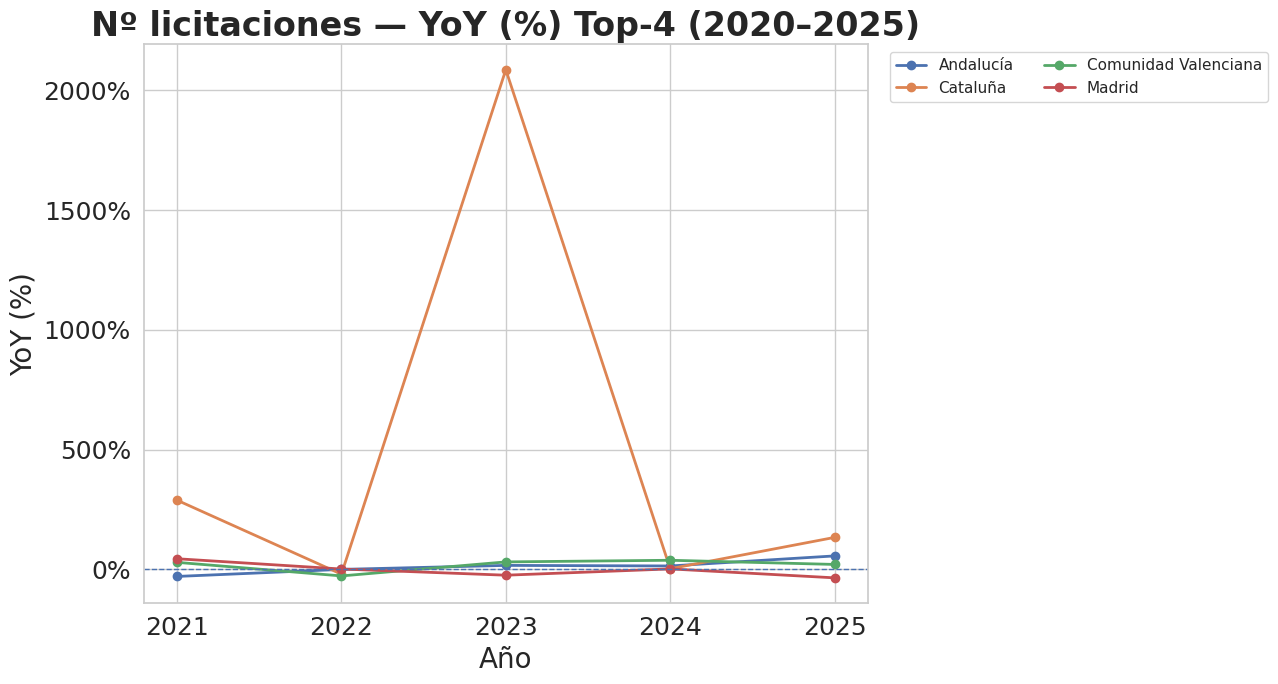

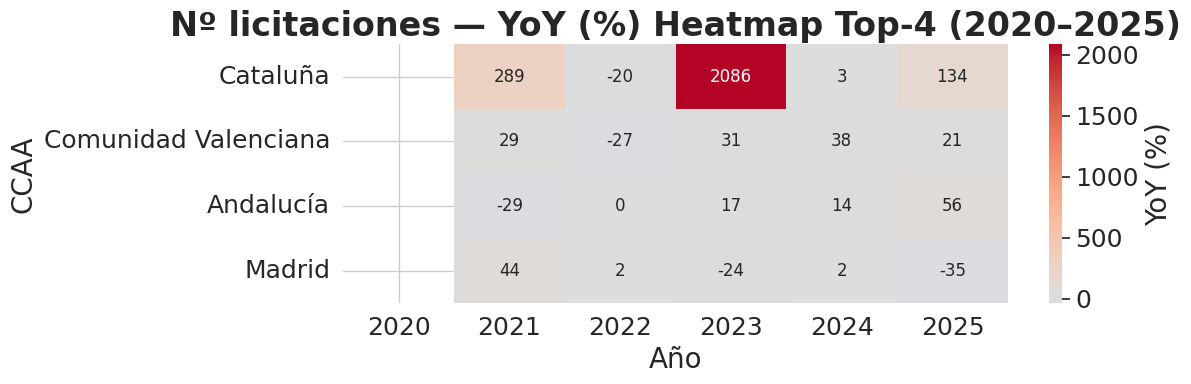

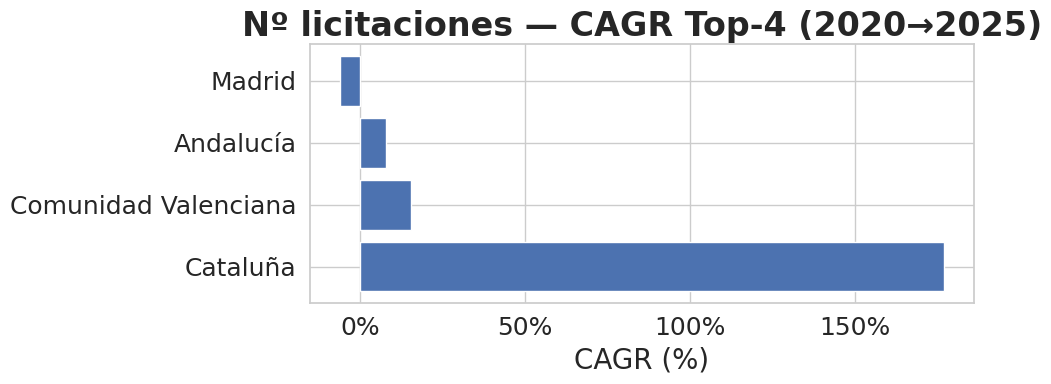

/tmp/ipython-input-1635760020.py:68: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  return pivot_df.replace(0, np.nan).pct_change()*100


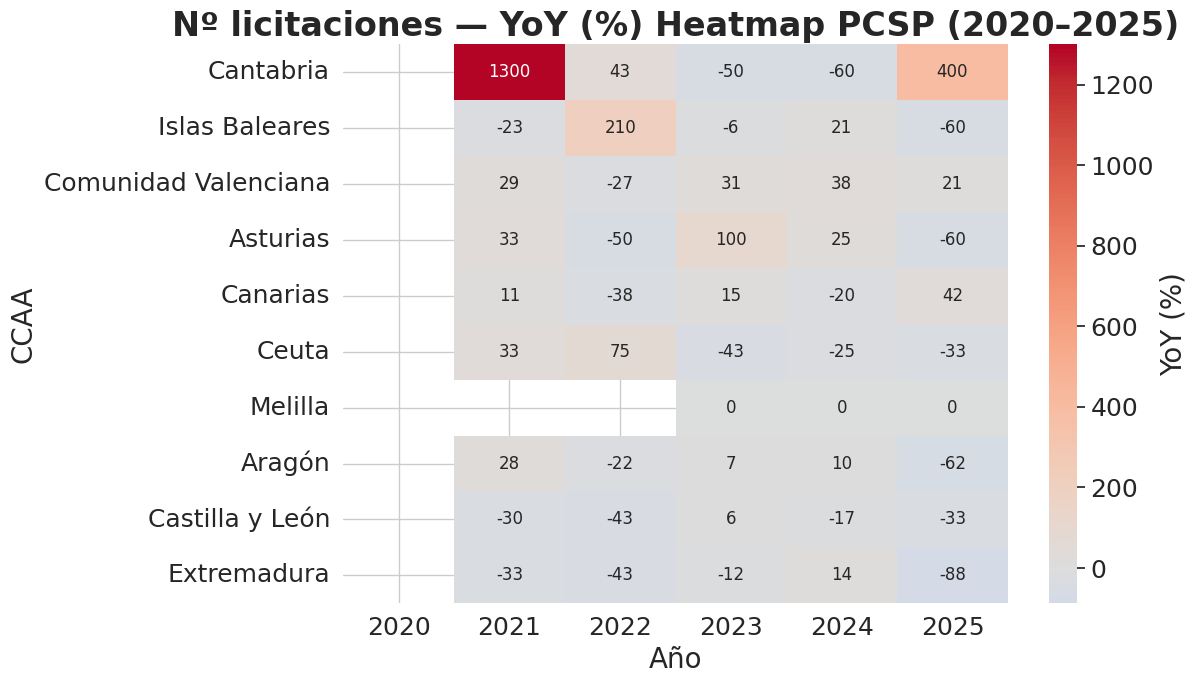

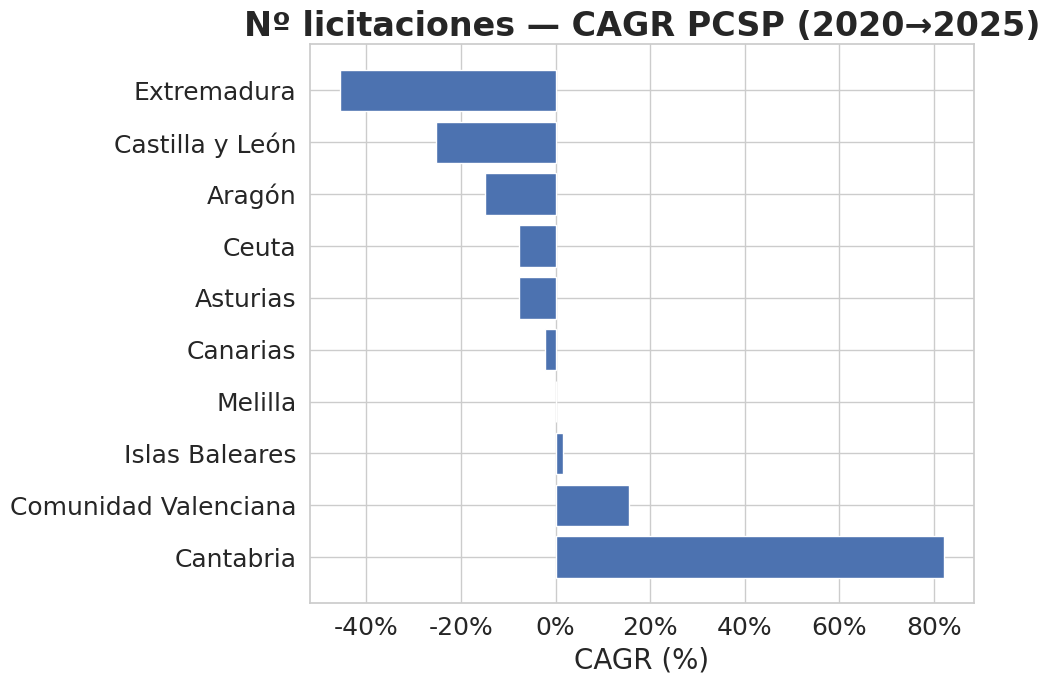

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import pandas as pd
import numpy as np
import seaborn as sns

# ================== Config global (MISMA FUENTE QUE TUS GRÁFICAS) ==================
FONT_TITLE = 24
FONT_LABEL = 20
FONT_TICKS = 18

plt.rcParams.update({
    "figure.figsize": (13, 7),
    "axes.grid": True,
    "axes.titlesize": FONT_TITLE,   # no siempre respeta, por eso forzamos en funciones
    "axes.labelsize": FONT_LABEL,
    "xtick.labelsize": FONT_TICKS,
    "ytick.labelsize": FONT_TICKS,
    "legend.fontsize": 11,
})
sns.set_style("whitegrid")

YEARS = list(range(2020, 2026))
fmt_pct = mticker.FuncFormatter(lambda x, _: f"{x:.0f}%")

# ================== Switches para no saturar ==================
PLOT_YOY_LINES_TOP4 = True      # líneas YoY solo para Top-4
PLOT_HEATMAP_ALL    = True      # heatmap YoY para todos los grupos
PLOT_CAGR_ALL       = True      # barras de CAGR para todos los grupos

# ================== Utilidades ==================
def pick_first_existing(df, candidates):
    for c in candidates:
        if c in df.columns:
            return c
    raise KeyError(f"No encuentro ninguna de estas columnas en el DataFrame: {candidates}")

def apply_axis_fonts(ax, title=None, xlabel=None, ylabel=None):
    """Aplica la misma tipografía que usas en el resto: título 24 bold, ejes 20, ticks 18."""
    if title is not None:
        ax.set_title(title, fontsize=FONT_TITLE, weight='bold')
    if xlabel is not None:
        ax.set_xlabel(xlabel, fontsize=FONT_LABEL)
    if ylabel is not None:
        ax.set_ylabel(ylabel, fontsize=FONT_LABEL)
    ax.tick_params(axis='both', labelsize=FONT_TICKS)

def pivot_sum_metric(df, ccaa_list, value_col):
    g = (df[df["CCAA"].isin(ccaa_list)]
         .groupby(["Año","CCAA"], as_index=False)[value_col].sum())
    p = (g.pivot(index="Año", columns="CCAA", values=value_col)
           .reindex(YEARS).fillna(0.0))
    return p

def pivot_count_metric(df, ccaa_list, id_col="ID"):
    sub = df[df["CCAA"].isin(ccaa_list)].copy()
    if id_col in sub.columns:
        g = (sub.groupby(["Año","CCAA"], as_index=False)[id_col].nunique()
               .rename(columns={id_col: "count"}))
    else:
        g = (sub.groupby(["Año","CCAA"], as_index=False).size()
               .rename(columns={"size": "count"}))
    p = (g.pivot(index="Año", columns="CCAA", values="count")
           .reindex(YEARS).fillna(0).astype(int))
    return p

def yoy_percent(pivot_df):
    return pivot_df.replace(0, np.nan).pct_change()*100

def cagr_percent(pivot_df):
    cagr = {}
    for c in pivot_df.columns:
        s = pivot_df[c].replace(0, np.nan).dropna()
        if len(s) >= 2:
            y0, yN = s.iloc[0], s.iloc[-1]
            n_years = s.index[-1] - s.index[0]
            if n_years > 0 and y0 > 0:
                cagr[c] = ((yN / y0)**(1/n_years) - 1) * 100
            else:
                cagr[c] = np.nan
        else:
            cagr[c] = np.nan
    return pd.Series(cagr).sort_values(ascending=False)

def classify_trend(pivot_df):
    trends = {}
    for c in pivot_df.columns:
        s = pivot_df[c].astype(float)
        x = s.index.values
        y = s.values
        if np.isfinite(y).sum() >= 2:
            slope = np.polyfit(x, y, 1)[0]
            trends[c] = "Creciente" if slope > 0 else ("Decreciente" if slope < 0 else "Plana")
        else:
            trends[c] = "Insuf. datos"
    return pd.Series(trends)

# ---- Plots (con fuentes uniformes) ----
def plot_yoy_lines(yoy_df, title):
    fig, ax = plt.subplots(figsize=(13,7))
    for c in yoy_df.columns:
        ax.plot(yoy_df.index, yoy_df[c], marker='o', linewidth=2, label=c)
    ax.axhline(0, linestyle='--', linewidth=1)
    apply_axis_fonts(ax, title=title, xlabel="Año", ylabel="YoY (%)")
    ax.xaxis.set_major_locator(mticker.MaxNLocator(integer=True))
    ax.yaxis.set_major_formatter(fmt_pct)
    ax.legend(ncol=2, bbox_to_anchor=(1.02, 1), loc="upper left")
    plt.tight_layout()
    plt.show()

def plot_yoy_heatmap(yoy_df, title):
    order = yoy_df.mean(skipna=True).sort_values(ascending=False).index
    fig, ax = plt.subplots(figsize=(12, 0.5*len(order)+2))
    sns.heatmap(yoy_df[order].T, cmap="coolwarm", center=0, annot=True, fmt=".0f",
                cbar_kws={"label": "YoY (%)"}, ax=ax)
    apply_axis_fonts(ax, title=title, xlabel="Año", ylabel="CCAA")
    plt.tight_layout()
    plt.show()

def plot_cagr_barh(cagr_s, title):
    fig, ax = plt.subplots(figsize=(10, 0.5*len(cagr_s)+2))
    ax.barh(cagr_s.index, cagr_s.values)
    apply_axis_fonts(ax, title=title, xlabel="CAGR (%)", ylabel=None)
    ax.xaxis.set_major_formatter(fmt_pct)
    plt.tight_layout()
    plt.show()

# ================== Listas de CCAA (ajusta según tu notebook) ==================
# TOP4 = ["Madrid","Andalucía","Cataluña","Comunidad Valenciana"]
# PCSP_CCAA = ["Aragón","Asturias","Islas Baleares","Canarias","Cantabria",
#              "Castilla y León","Comunidad Valenciana","Extremadura","Ceuta","Melilla"]

# ================== Columnas / datos base ==================
GASTO_COL = pick_first_existing(df_ccaa_full, ["Gasto (€)", "Gasto", "Importe", "Importe (€)"])

# ================== 1) GASTO ==================
for group_name, ccaa_list in [("Top-4", TOP4), ("PCSP", PCSP_CCAA)]:
    p_gasto = pivot_sum_metric(df_ccaa_full, ccaa_list, GASTO_COL)
    yoy_gasto = yoy_percent(p_gasto)
    cagr_gasto = cagr_percent(p_gasto)

    if group_name == "Top-4" and PLOT_YOY_LINES_TOP4:
        plot_yoy_lines(yoy_gasto, f"Gasto IVD — YoY (%) {group_name} (2020–2025)")

    if PLOT_HEATMAP_ALL:
        plot_yoy_heatmap(yoy_gasto, f"Gasto IVD — YoY (%) Heatmap {group_name} (2020–2025)")

    if PLOT_CAGR_ALL:
        plot_cagr_barh(cagr_gasto, f"Gasto IVD — CAGR {group_name} (2020→2025)")

    # Si quieres una tabla rápida de tendencia:
    # trend_gasto = classify_trend(p_gasto)
    # display(pd.DataFrame({"Tendencia (regresión lineal)": trend_gasto}))

# ================== 2) Nº DE LICITACIONES (conteo por año-CCAA) ==================
for group_name, ccaa_list in [("Top-4", TOP4), ("PCSP", PCSP_CCAA)]:
    p_cnt = pivot_count_metric(df_ccaa_full, ccaa_list, id_col="ID")
    yoy_cnt = yoy_percent(p_cnt)
    cagr_cnt = cagr_percent(p_cnt)

    if group_name == "Top-4" and PLOT_YOY_LINES_TOP4:
        plot_yoy_lines(yoy_cnt, f"Nº licitaciones — YoY (%) {group_name} (2020–2025)")

    if PLOT_HEATMAP_ALL:
        plot_yoy_heatmap(yoy_cnt, f"Nº licitaciones — YoY (%) Heatmap {group_name} (2020–2025)")

    if PLOT_CAGR_ALL:
        plot_cagr_barh(cagr_cnt, f"Nº licitaciones — CAGR {group_name} (2020→2025)")


###Distribución mensual de licitaciones: patrones estacionales

/tmp/ipython-input-1802002249.py:66: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


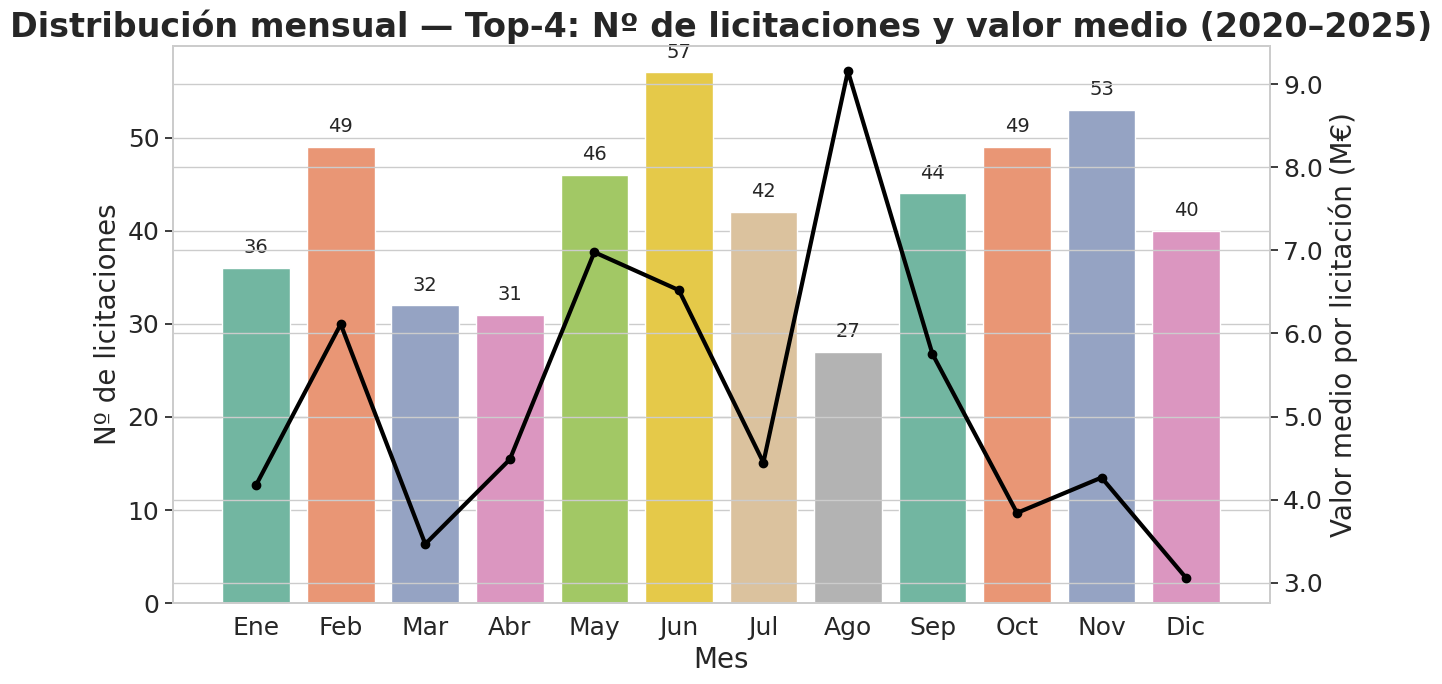

/tmp/ipython-input-1802002249.py:66: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


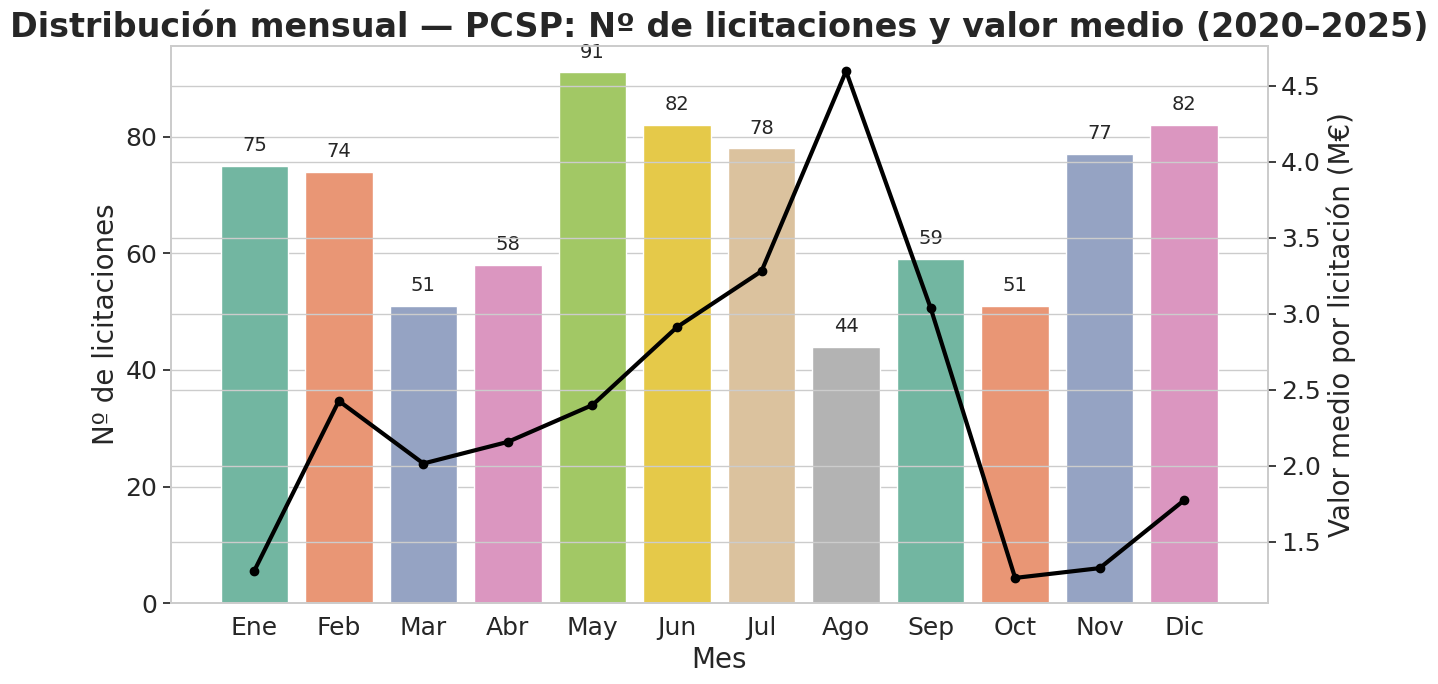

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

# ========= Estilo coherente con el resto =========
FONT_TITLE = 24
FONT_LABEL = 20
FONT_TICKS = 18
sns.set_style("whitegrid")

fmt_M   = mticker.FuncFormatter(lambda x, _: f"{x/1e6:,.1f}".replace(",", "."))  # millones con 1 decimal
fmt_int = mticker.FuncFormatter(lambda x, _: f"{int(x):d}")
MESES_CORTO_ES = ["Ene","Feb","Mar","Abr","May","Jun","Jul","Ago","Sep","Oct","Nov","Dic"]

# ========= Utilidades =========
def pick_first_existing(df, candidates):
    for c in candidates:
        if c in df.columns:
            return c
    raise KeyError(f"No encuentro ninguna columna entre: {candidates}")

def preparar_meses(df):
    if "Fecha" not in df.columns:
        raise ValueError("No existe la columna 'Fecha' en df_ccaa_full.")
    d = df.copy()
    fechas = pd.to_datetime(d["Fecha"], errors="coerce", utc=True)
    d["Mes"] = fechas.dt.month
    d = d[d["Mes"].notna()].copy()
    d["Mes"] = d["Mes"].astype(int)
    return d

def mensual_por_grupo(df, ccaa_list, gasto_col, id_col="ID"):
    """
    Filtra por CCAA del grupo y devuelve un dataframe mensual con:
    - N_Licitaciones (IDs únicos si hay ID; si no, número de filas)
    - ValorMedio (euros por licitación; agrega antes por (Mes, ID) si hay ID)
    """
    sub = df[df["CCAA"].isin(ccaa_list)].copy()

    # Si hay ID, primero agregamos por (Mes, ID) para consolidar cada licitación
    if id_col in sub.columns:
        agg_id = (sub.dropna(subset=[id_col])
                    .groupby(["Mes", id_col], as_index=False)[gasto_col].sum())
        res = (agg_id.groupby("Mes")
                      .agg(N_Licitaciones=(id_col, "nunique"),
                           ValorMedio=(gasto_col, "mean"))
                      .reindex(range(1, 13)))
    else:
        res = (sub.groupby("Mes")
                  .agg(N_Licitaciones=("Mes", "size"),
                       ValorMedio=(gasto_col, "mean"))
                  .reindex(range(1, 13)))

    res.index.name = "Mes"
    res = res.reset_index()
    res["MesTexto"] = MESES_CORTO_ES  # asegura orden y etiquetas
    res["N_Licitaciones"] = res["N_Licitaciones"].fillna(0).astype(int)
    return res

def plot_mensual_combo(mensual_df, titulo):
    """Barras (Nº licitaciones) + línea (valor medio en M€) con bordes negros."""
    valor_linea = mensual_df["ValorMedio"].fillna(0.0)

    plt.figure(figsize=(13, 7))
    ax = sns.barplot(
        data=mensual_df, x="MesTexto", y="N_Licitaciones",
        palette="Set2")
    ax2 = ax.twinx()
    ax2.plot(mensual_df["MesTexto"], valor_linea, marker="o", linewidth=3, color="black")

    ax.set_title(titulo, fontsize=FONT_TITLE, weight="bold")
    ax.set_xlabel("Mes", fontsize=FONT_LABEL)
    ax.set_ylabel("Nº de licitaciones", fontsize=FONT_LABEL)
    ax2.set_ylabel("Valor medio por licitación (M€)", fontsize=FONT_LABEL)

    ax.tick_params(axis="both", labelsize=FONT_TICKS)
    ax2.tick_params(axis="y", labelsize=FONT_TICKS)

    ax.yaxis.set_major_formatter(fmt_int)
    ax2.yaxis.set_major_formatter(fmt_M)

    ymax = mensual_df["N_Licitaciones"].max() if len(mensual_df) else 0
    for p, v in zip(ax.patches, mensual_df["N_Licitaciones"].values):
        ax.text(p.get_x() + p.get_width()/2,
                p.get_height() + (0.02 * (ymax if ymax > 0 else 1)),
                f"{v}", ha="center", va="bottom", fontsize=14)

    plt.tight_layout()
    plt.show()

# ========= Entradas de tu notebook =========
# TOP4 = ["Madrid","Andalucía","Cataluña","Comunidad Valenciana"]
# PCSP_CCAA = ["Aragón","Asturias","Islas Baleares","Canarias","Cantabria",
#              "Castilla-La Mancha","Castilla y León","Comunidad Valenciana",
#              "Extremadura","Región de Murcia","La Rioja","Ceuta","Melilla"]

# ========= Pipeline =========
dfm = preparar_meses(df_ccaa_full)
GASTO_COL = pick_first_existing(dfm, ["Gasto (€)", "Gasto", "Importe", "Importe (€)"])

# Top-4
mensual_top4 = mensual_por_grupo(dfm, TOP4, GASTO_COL, id_col="ID")
plot_mensual_combo(mensual_top4, "Distribución mensual — Top-4: Nº de licitaciones y valor medio (2020–2025)")

# Resto (PCSP)
mensual_pcsp = mensual_por_grupo(dfm, PCSP_CCAA, GASTO_COL, id_col="ID")
plot_mensual_combo(mensual_pcsp, "Distribución mensual — PCSP: Nº de licitaciones y valor medio (2020–2025)")



## 4.2.3. Análisis técnico: desglose por códigos CPV

Distribución del gasto por CPV

Número de licitaciones por CPV

Gasto medio por licitación según CPV

Evolución del gasto por CPV y año

Evolución del volumen por CPV y año

###Número de licitaciones por CPV

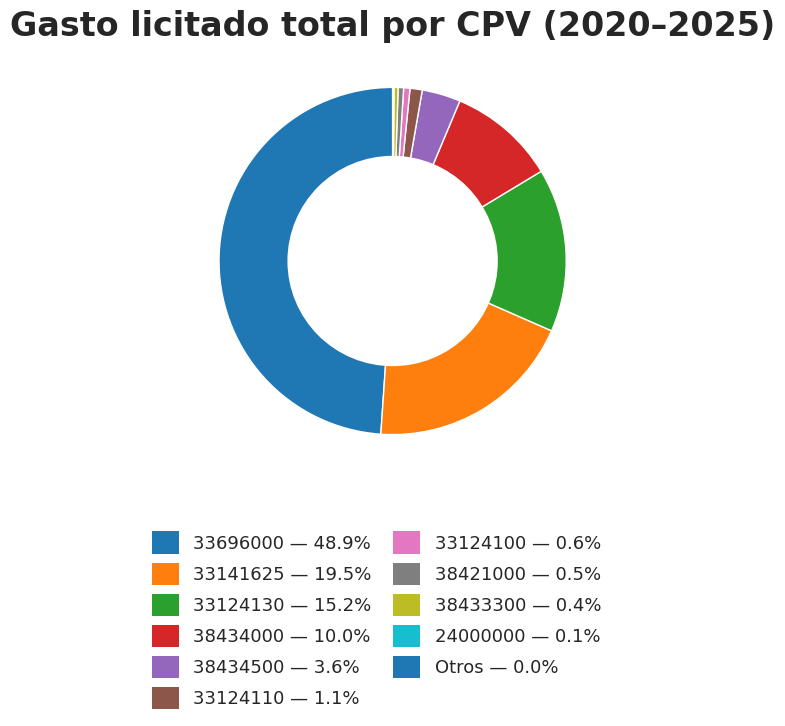

✅ Guardado: pie_gasto_por_cpv_leyenda_20250909_1254.png, pie_gasto_por_cpv_leyenda_20250909_1254.svg


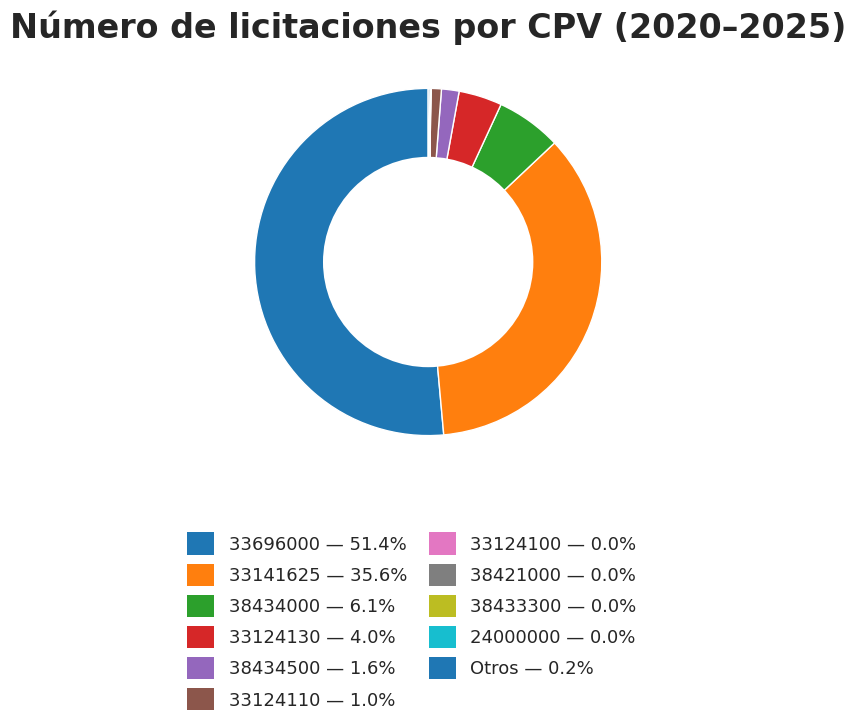

✅ Guardado: pie_nlicit_por_cpv_leyenda_20250909_1254.png, pie_nlicit_por_cpv_leyenda_20250909_1254.svg


/tmp/ipython-input-137664407.py:164: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=gasto_pct_top15, x="Porcentaje", y="CPV_clean", orient="h", palette="viridis", ax=ax)


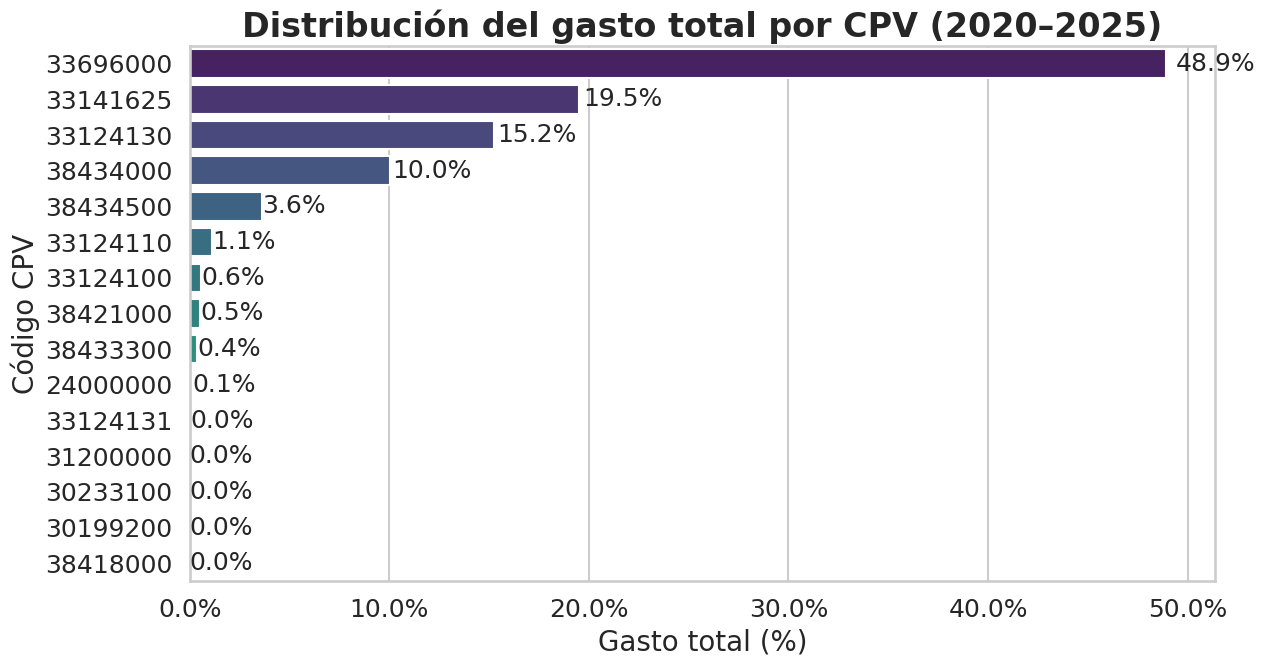

/tmp/ipython-input-137664407.py:180: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=nlicit_pct_top15, x="Porcentaje", y="CPV_clean", orient="h", palette="magma", ax=ax)


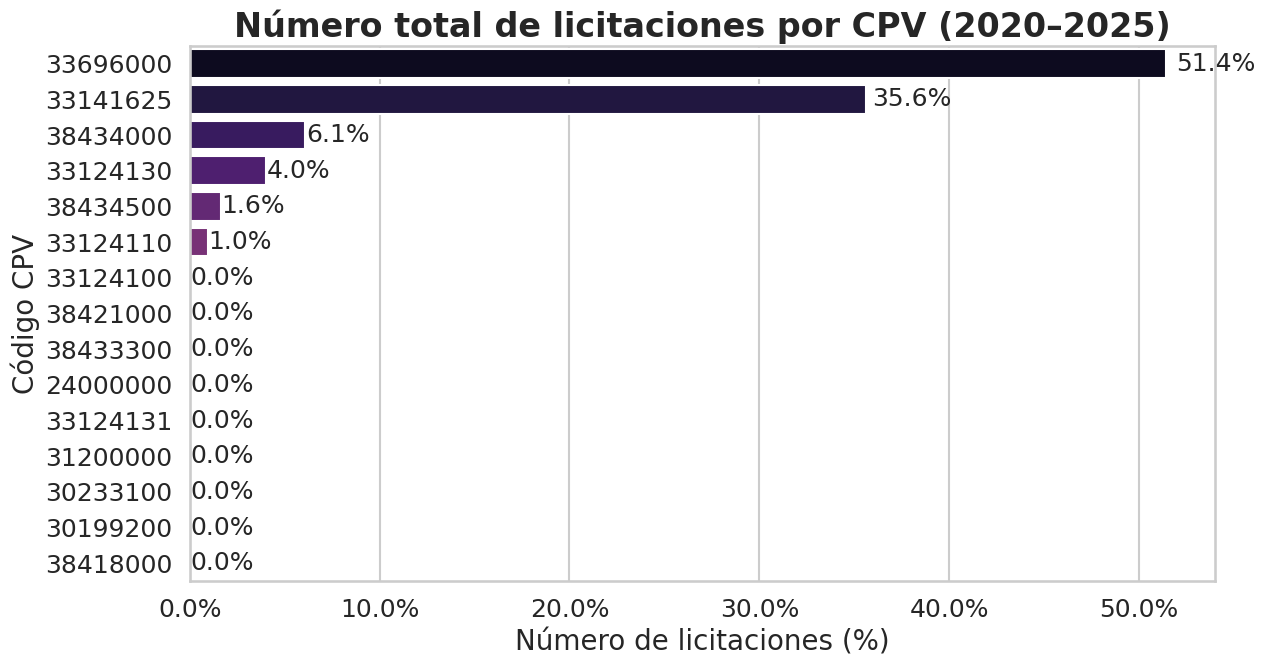

✅ Gráficas y tablas CPV generadas y guardadas con formato TFM.


In [ ]:
# =========================================
# Análisis por CPV (2020–2025) — Formato TFM unificado
# =========================================
import re
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib.patches import Patch
from matplotlib.ticker import MaxNLocator
from pathlib import Path

# ========= Config tipográfica global (igual que tus otras gráficas) =========
FONT_TITLE = 24
FONT_LABEL = 20
FONT_TICKS = 18

plt.rcParams.update({
    "figure.figsize": (13, 7),
    "axes.grid": True,
    "axes.titlesize": FONT_TITLE,   # reforzamos además desde la función helper
    "axes.labelsize": FONT_LABEL,
    "xtick.labelsize": FONT_TICKS,
    "ytick.labelsize": FONT_TICKS,
    "legend.fontsize": 11,
})
sns.set_style("whitegrid")

def apply_axis_fonts(ax, title=None, xlabel=None, ylabel=None):
    """Aplica la misma tipografía que el resto del TFM."""
    if title is not None:
        ax.set_title(title, fontsize=FONT_TITLE, weight='bold')
    if xlabel is not None:
        ax.set_xlabel(xlabel, fontsize=FONT_LABEL)
    if ylabel is not None:
        ax.set_ylabel(ylabel, fontsize=FONT_LABEL)
    ax.tick_params(axis='both', labelsize=FONT_TICKS)

fmt_pct = mticker.FuncFormatter(lambda x, _: f"{x:.1f}%".replace(",", "."))

# ========= 1) Preparación =========
df = df_ccaa_full.copy()
df["CPV_clean"] = df["CPV"].astype(str).str.extract(r"(\d{8})", expand=False)
df = df.dropna(subset=["CPV_clean"])

col_gasto = "Gasto (€)" if "Gasto (€)" in df.columns else "Presupuesto"
if col_gasto not in df.columns:
    raise ValueError("No encuentro columna de gasto ('Gasto (€)' o 'Presupuesto') en df_ccaa_full.")

# Agregados base (gasto y nº licitaciones)
if "ID" in df.columns:
    agg_base = (df.groupby("CPV_clean", as_index=False)
                  .agg(**{col_gasto: (col_gasto, "sum"),
                          "N_Licitaciones": ("ID", "nunique")}))
else:
    agg_base = (df.groupby("CPV_clean", as_index=False)
                  .agg(**{col_gasto: (col_gasto, "sum"),
                          "N_Licitaciones": ("CPV_clean", "size")}))

agg_base = agg_base.sort_values(col_gasto, ascending=False)
agg_base["Gasto (M€)"] = agg_base[col_gasto] / 1e6

# ========= 2) Helpers =========
def top_n_with_others(df_in, value_col, label_col="CPV_clean", n=10, otros_label="Otros"):
    df_sorted = df_in.sort_values(value_col, ascending=False)
    top = df_sorted.head(n).copy()
    rest = df_sorted.iloc[n:]
    if not rest.empty:
        otros_val = rest[value_col].sum()
        top = pd.concat([top, pd.DataFrame({label_col:[otros_label], value_col:[otros_val]})],
                        ignore_index=True)
    total = top[value_col].sum()
    top["%"] = 100 * top[value_col] / (total if total else 1)
    return top, total

def donut_con_leyenda_abajo(df_top, title, filename_prefix, output_dir, ts, ncol=None):
    """
    df_top: DataFrame con columnas ['CPV_clean', '%']
    title:  título del gráfico
    filename_prefix: prefijo de archivo
    output_dir: carpeta Path
    ts: timestamp string
    ncol: nº de columnas en la leyenda (auto si None)
    """
    labels = df_top["CPV_clean"].astype(str).tolist()
    sizes  = df_top["%"].values

    # Respetar tamaño global, pero hacemos el lienzo ligeramente más cuadrado para el donut
    fig, ax = plt.subplots(figsize=(13, 7))
    wedges, _ = ax.pie(
        sizes, labels=None, startangle=90,
        wedgeprops=dict(linewidth=1, edgecolor='white')
    )

    # Donut
    centre_circle = plt.Circle((0, 0), 0.60, fc='white')
    fig.gca().add_artist(centre_circle)

    # Título con tipografía del TFM
    ax.set_title(title, fontsize=FONT_TITLE, weight='bold')

    # Leyenda inferior (color + código + porcentaje)
    legend_labels = [f"{lab} — {pct:.1f}%".replace(",", ".") for lab, pct in zip(labels, sizes)]
    handles = [Patch(facecolor=w.get_facecolor(), edgecolor='none') for w in wedges]

    if ncol is None:
        n = len(labels)
        ncol = 3 if n >= 12 else (2 if n >= 7 else 1)

    fig.legend(
        handles, legend_labels,
        loc="lower center", bbox_to_anchor=(0.5, -0.08),
        ncol=ncol, frameon=False, handlelength=1.5, handleheight=1.5,
        columnspacing=1.2, borderaxespad=0.0, fontsize=FONT_TICKS-5
    )
    # Más margen inferior para que quepa la leyenda con la tipografía grande
    plt.subplots_adjust(bottom=0.26)

    # Guardado
    png = output_dir / f"{filename_prefix}_{ts}.png"
    svg = output_dir / f"{filename_prefix}_{ts}.svg"
    plt.savefig(png, dpi=200, bbox_inches="tight")
    plt.savefig(svg, bbox_inches="tight")
    plt.show()
    print(f"✅ Guardado: {png.name}, {svg.name}")

def annotate_bars_percent(ax, values, fmt="{:.1f}%"):
    for p, v in zip(ax.patches, values):
        ax.text(p.get_width()*1.01, p.get_y()+p.get_height()/2,
                fmt.format(v).replace(",", "."), va="center", ha="left", fontsize=FONT_TICKS)

# ========= 3) Configuración salida =========
OUTPUT_DIR = Path("/content/drive/MyDrive/Data/Resultados_IVD")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
ts = pd.Timestamp.now(tz="Europe/Madrid").strftime("%Y%m%d_%H%M")

# ========= 4) Pies/Donuts (formato TFM) =========
# Gasto
gasto_top, total_gasto = top_n_with_others(agg_base, col_gasto, n=10)
donut_con_leyenda_abajo(
    df_top=gasto_top,
    title="Gasto licitado total por CPV (2020–2025)",
    filename_prefix="pie_gasto_por_cpv_leyenda",
    output_dir=OUTPUT_DIR, ts=ts
)
gasto_top.to_csv(OUTPUT_DIR / f"porcentaje_gasto_por_cpv_top10_{ts}.csv", index=False)

# Nº de licitaciones
nlicit_top, total_nlicit = top_n_with_others(agg_base, "N_Licitaciones", n=10)
donut_con_leyenda_abajo(
    df_top=nlicit_top,
    title="Número de licitaciones por CPV (2020–2025)",
    filename_prefix="pie_nlicit_por_cpv_leyenda",
    output_dir=OUTPUT_DIR, ts=ts
)
nlicit_top.to_csv(OUTPUT_DIR / f"porcentaje_nlicit_por_cpv_top10_{ts}.csv", index=False)

# ========= 5) Barras horizontales en % (formato TFM) =========
# a) % del gasto por CPV (top-15)
gasto_pct = agg_base.assign(Porcentaje=lambda d: 100 * d[col_gasto]/d[col_gasto].sum())
gasto_pct_top15 = gasto_pct.nlargest(15, "Porcentaje").copy()

fig, ax = plt.subplots(figsize=(13, 7))
sns.barplot(data=gasto_pct_top15, x="Porcentaje", y="CPV_clean", orient="h", palette="viridis", ax=ax)
apply_axis_fonts(ax, title="Distribución del gasto total por CPV (2020–2025)",
                 xlabel="Gasto total (%)", ylabel="Código CPV")
ax.xaxis.set_major_locator(MaxNLocator(nbins=6))
ax.xaxis.set_major_formatter(fmt_pct)
annotate_bars_percent(ax, gasto_pct_top15["Porcentaje"].values, fmt="{:.1f}%")
plt.tight_layout()
plt.savefig(OUTPUT_DIR / f"bar_pct_gasto_por_cpv_top15_{ts}.png", dpi=200, bbox_inches="tight")
plt.savefig(OUTPUT_DIR / f"bar_pct_gasto_por_cpv_top15_{ts}.svg", bbox_inches="tight")
plt.show()

# b) % del nº de licitaciones por CPV (top-15)
nlicit_pct = agg_base.assign(Porcentaje=lambda d: 100 * d["N_Licitaciones"]/d["N_Licitaciones"].sum())
nlicit_pct_top15 = nlicit_pct.nlargest(15, "Porcentaje").copy()

fig, ax = plt.subplots(figsize=(13, 7))
sns.barplot(data=nlicit_pct_top15, x="Porcentaje", y="CPV_clean", orient="h", palette="magma", ax=ax)
apply_axis_fonts(ax, title="Número total de licitaciones por CPV (2020–2025)",
                 xlabel="Número de licitaciones (%)", ylabel="Código CPV")
ax.xaxis.set_major_locator(MaxNLocator(nbins=6))
ax.xaxis.set_major_formatter(fmt_pct)
annotate_bars_percent(ax, nlicit_pct_top15["Porcentaje"].values, fmt="{:.1f}%")
plt.tight_layout()
plt.savefig(OUTPUT_DIR / f"bar_pct_nlicit_por_cpv_top15_{ts}.png", dpi=200, bbox_inches="tight")
plt.savefig(OUTPUT_DIR / f"bar_pct_nlicit_por_cpv_top15_{ts}.svg", bbox_inches="tight")
plt.show()

print("✅ Gráficas y tablas CPV generadas y guardadas con formato TFM.")




###Distribución del gasto por CPV

/tmp/ipython-input-1695807408.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


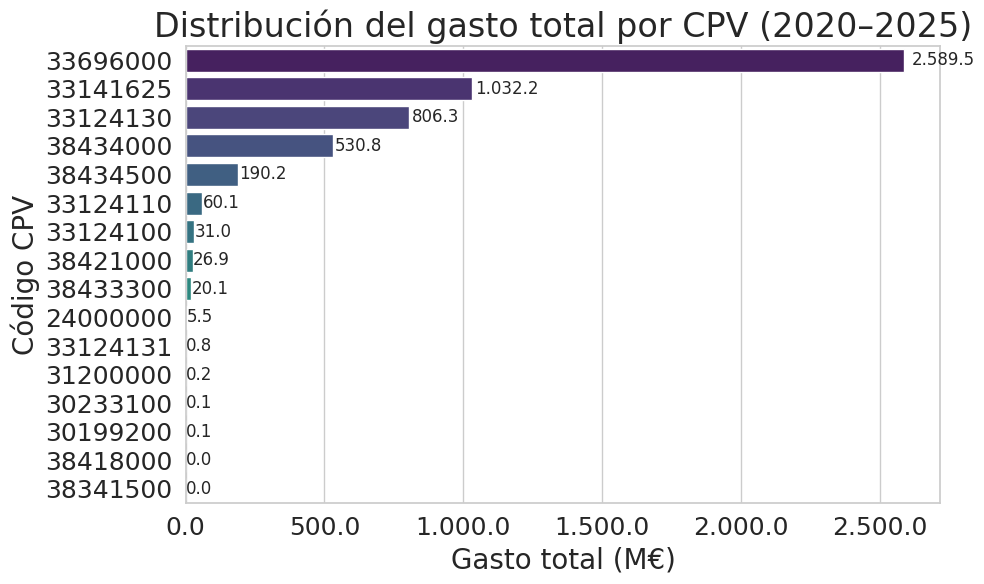

In [ ]:
import re
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

# --- preparar y agrupar ---
df = df_ccaa_full.copy()

# CPV limpio (primeros 8 dígitos; ignora sufijos tipo "-5")
df["CPV_clean"] = df["CPV"].astype(str).str.extract(r"(\d{8})", expand=False)
df = df.dropna(subset=["CPV_clean"])

# gasto total por CPV (y nº licitaciones por si lo quieres usar)
if "ID" in df.columns:
    gasto_por_cpv = (df.groupby("CPV_clean", as_index=False)
                       .agg(**{"Gasto (€)": ("Gasto (€)", "sum"),
                               "N_Licitaciones": ("ID", "nunique")}))
else:
    gasto_por_cpv = (df.groupby("CPV_clean", as_index=False)
                       .agg(**{"Gasto (€)": ("Gasto (€)", "sum"),
                               "N_Licitaciones": ("CPV_clean", "size")}))

gasto_por_cpv = gasto_por_cpv.sort_values("Gasto (€)", ascending=False)
gasto_por_cpv["Gasto (M€)"] = gasto_por_cpv["Gasto (€)"] / 1e6

# --- gráfico ---
sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))
ax = sns.barplot(
    data=gasto_por_cpv, x="Gasto (M€)", y="CPV_clean",
    orient="h", palette="viridis"
)
ax.set_title("Distribución del gasto total por CPV (2020–2025)")
ax.set_xlabel("Gasto total (M€)")
ax.set_ylabel("Código CPV")
ax.xaxis.set_major_locator(mticker.MaxNLocator(nbins=6))
ax.xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f"{x:,.1f}".replace(",", ".")))

# anotar valores al final de cada barra
for p, v in zip(ax.patches, gasto_por_cpv["Gasto (M€)"].values):
    ax.text(p.get_width()*1.01, p.get_y()+p.get_height()/2,
            f"{v:,.1f}".replace(",", "."), va="center", ha="left")

plt.tight_layout()
plt.show()



In [ ]:
# primeras 5 filas
print(df_ccaa_full.head())

# primeras 10 filas
print(df_ccaa_full.head(10))

# últimas filas
print(df_ccaa_full.tail())


                                                  ID  \
0  https://contrataciondelestado.es/sindicacion/l...   
1  https://contrataciondelestado.es/sindicacion/l...   
2  https://contrataciondelestado.es/sindicacion/l...   
3  https://contrataciondelestado.es/sindicacion/l...   
4  https://contrataciondelestado.es/sindicacion/l...   

                                              Título  \
0  Acuerdo Marco para suministrar a las Fundacion...   
1  material para hacer frente a la pandemia COVID-19   
2  Suministro de material necesario para la reali...   
3  Sistema Flash monitorización de glucosa inters...   
4  Suministro de kits de detección anticuerpos Co...   

                           Fecha  \
0  2020-01-15T10:17:22.849+01:00   
1  2020-11-26T13:43:45.768+01:00   
2  2020-03-05T11:01:37.240+01:00   
3  2020-11-25T11:12:10.347+01:00   
4  2020-10-27T08:48:07.958+01:00   

                                             Resumen  \
0  Id licitación: AM 01-2019; Órgano de Contratac... 

###Número de licitaciones por CPV

/tmp/ipython-input-1898039089.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=nlicit_por_cpv, x="N_Licitaciones", y="CPV_clean", orient="h", palette="magma")


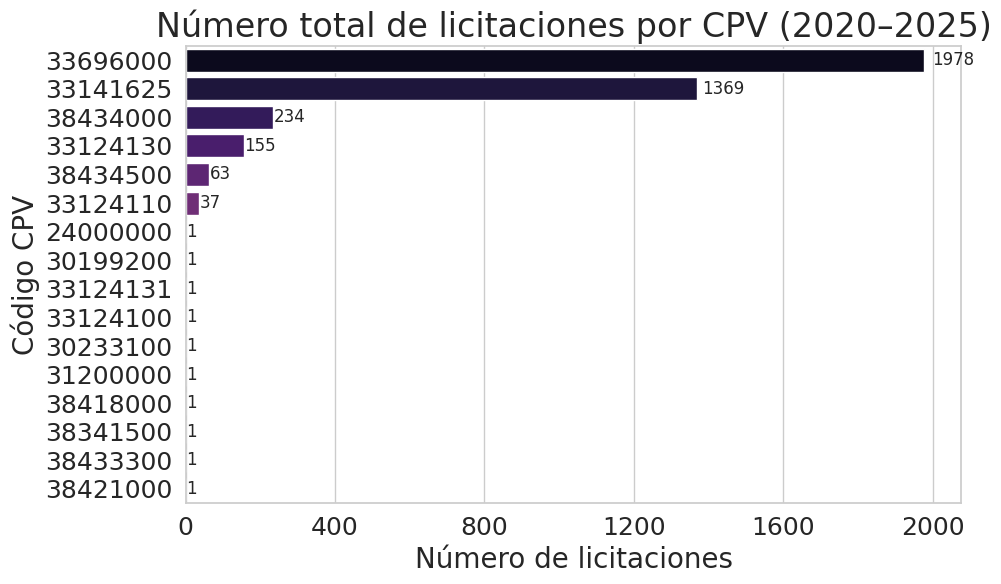

In [ ]:
import re
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

# === preparar datos ===
df = df_ccaa_full.copy()

# CPV a 8 dígitos (ignora sufijos tipo "-5")
df["CPV_clean"] = df["CPV"].astype(str).str.extract(r"(\d{8})", expand=False)
df = df.dropna(subset=["CPV_clean"])

# Nº licitaciones por CPV (IDs únicos si existe 'ID')
if "ID" in df.columns:
    nlicit_por_cpv = df.dropna(subset=["ID"]).groupby("CPV_clean")["ID"].nunique()
else:
    nlicit_por_cpv = df.groupby("CPV_clean").size()

nlicit_por_cpv = nlicit_por_cpv.sort_values(ascending=False).astype(int).reset_index(name="N_Licitaciones")

# === gráfico ===
sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))
ax = sns.barplot(data=nlicit_por_cpv, x="N_Licitaciones", y="CPV_clean", orient="h", palette="magma")
ax.set_title("Número total de licitaciones por CPV (2020–2025)")
ax.set_xlabel("Número de licitaciones")
ax.set_ylabel("Código CPV")
ax.xaxis.set_major_locator(MaxNLocator(integer=True, nbins=6))

# anotar valores al final de cada barra
for p, v in zip(ax.patches, nlicit_por_cpv["N_Licitaciones"].values):
    ax.text(p.get_width()*1.01, p.get_y()+p.get_height()/2,
            f"{v}", va="center", ha="left")

plt.tight_layout()
plt.show()


###Gasto medio por licitación según CPV

/tmp/ipython-input-1872022635.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


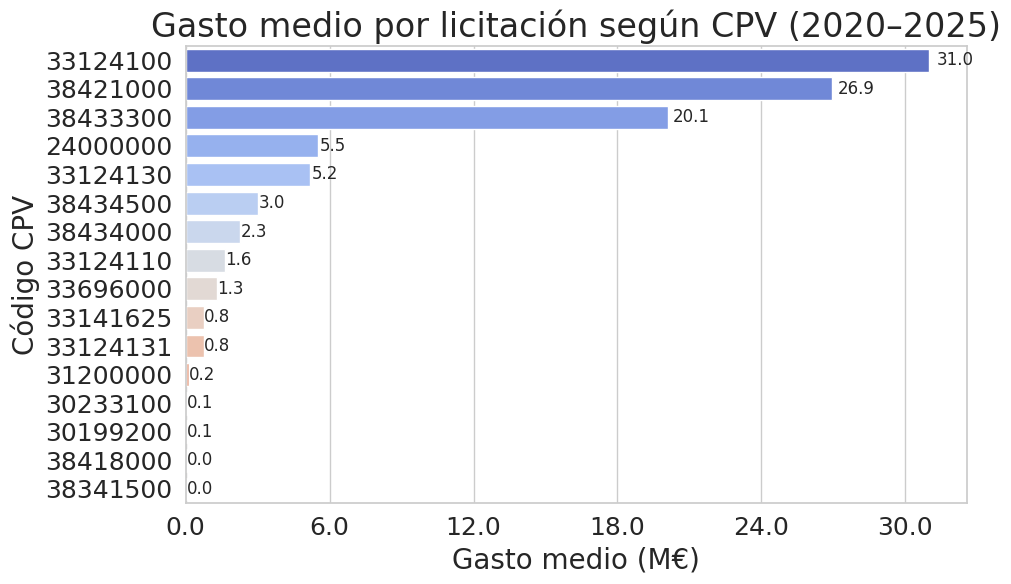

In [ ]:
import re
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

# ===== preparar datos =====
df = df_ccaa_full.copy()

# CPV limpio a 8 dígitos (ignora sufijos tipo "-5")
df["CPV_clean"] = df["CPV"].astype(str).str.extract(r"(\d{8})", expand=False)
df = df.dropna(subset=["CPV_clean"])

# Totales por CPV y nº licitaciones (IDs únicos si existe 'ID')
if "ID" in df.columns:
    agg = df.groupby("CPV_clean").agg(
        Gasto_total=("Gasto (€)", "sum"),
        N_Licitaciones=("ID", "nunique")
    )
else:
    agg = df.groupby("CPV_clean").agg(
        Gasto_total=("Gasto (€)", "sum"),
        N_Licitaciones=("CPV_clean", "size")
    )

# Gasto medio por licitación (evita división por 0)
agg["Gasto medio (€)"] = agg.apply(
    lambda r: r["Gasto_total"] / r["N_Licitaciones"] if r["N_Licitaciones"] > 0 else 0.0,
    axis=1
)

# Ordenar y pasar a M€
agg = agg.sort_values("Gasto medio (€)", ascending=False)
agg["Gasto medio (M€)"] = agg["Gasto medio (€)"] / 1e6

# ===== gráfico =====
sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))
ax = sns.barplot(
    data=agg.reset_index(),
    x="Gasto medio (M€)", y="CPV_clean",
    orient="h", palette="coolwarm"
)
ax.set_title("Gasto medio por licitación según CPV (2020–2025)")
ax.set_xlabel("Gasto medio (M€)")
ax.set_ylabel("Código CPV")
ax.xaxis.set_major_locator(mticker.MaxNLocator(nbins=6))
ax.xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f"{x:,.1f}".replace(",", ".")))

# anotar valores al final de cada barra
for p, v in zip(ax.patches, agg["Gasto medio (M€)"].values):
    ax.text(p.get_width()*1.01, p.get_y()+p.get_height()/2,
            f"{v:,.1f}".replace(",", "."), va="center", ha="left")

plt.tight_layout()
plt.show()



###Evolución del gasto por CPV y año

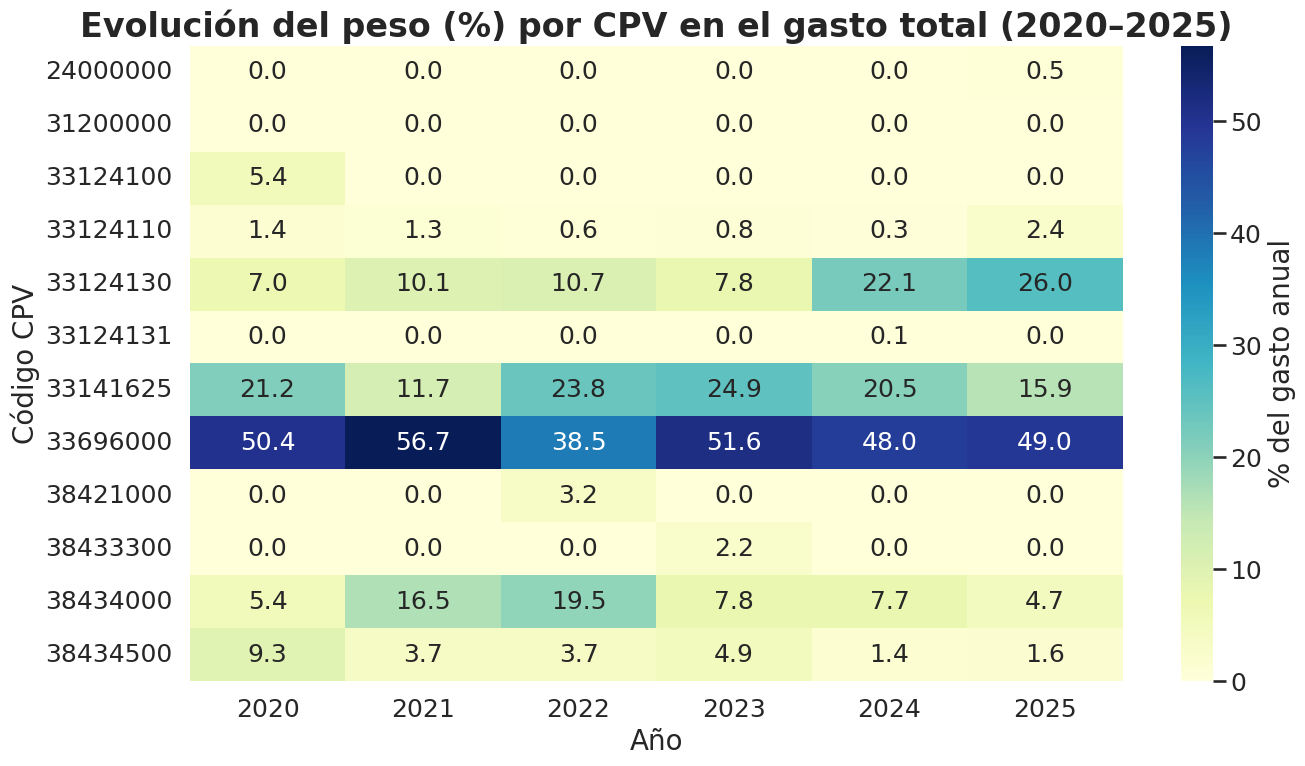

In [ ]:
# ================== Imports y config ==================
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

FONT_TITLE = 24
FONT_LABEL = 20
FONT_TICKS = 18

plt.rcParams.update({
    "figure.figsize": (13, 7),
    "axes.grid": True,
    "axes.titlesize": FONT_TITLE,
    "axes.labelsize": FONT_LABEL,
    "xtick.labelsize": FONT_TICKS,
    "ytick.labelsize": FONT_TICKS,
    "legend.fontsize": 11,
})
sns.set_style("whitegrid")

YEARS = list(range(2020, 2026))
fmt_pct = mticker.FuncFormatter(lambda x, _: f"{x:.0f}%")

def apply_axis_fonts(ax, title=None, xlabel=None, ylabel=None):
    if title is not None:
        ax.set_title(title, fontsize=FONT_TITLE, weight='bold')
    if xlabel is not None:
        ax.set_xlabel(xlabel, fontsize=FONT_LABEL)
    if ylabel is not None:
        ax.set_ylabel(ylabel, fontsize=FONT_LABEL)
    ax.tick_params(axis='both', labelsize=FONT_TICKS)

# ================== Datos por CPV ==================
df = df_ccaa_full.copy()
df["CPV_clean"] = df["CPV"].astype(str).str.extract(r"(\d{8})", expand=False)
df = df.dropna(subset=["CPV_clean"])

col_gasto = "Gasto (€)" if "Gasto (€)" in df.columns else "Presupuesto"
if col_gasto not in df.columns:
    raise ValueError("No encuentro columna de gasto en df_ccaa_full.")

# Asegurar columna Año
if "Año" not in df.columns:
    df["Año"] = pd.to_datetime(df["Fecha"], errors="coerce").dt.year

# Agrupación CPV × Año
gasto_cpva = (df.groupby(["Año","CPV_clean"], as_index=False)[col_gasto].sum())
total_anual = gasto_cpva.groupby("Año")[col_gasto].transform("sum")
gasto_cpva["%_anual"] = 100 * gasto_cpva[col_gasto] / total_anual

# Seleccionar top 12 CPV (por gasto total acumulado 2020–2025)
top_cpvs = (gasto_cpva.groupby("CPV_clean")[col_gasto]
                      .sum()
                      .sort_values(ascending=False)
                      .head(12).index)

pivot_cpv = (gasto_cpva[gasto_cpva["CPV_clean"].isin(top_cpvs)]
                .pivot(index="Año", columns="CPV_clean", values="%_anual")
                .reindex(YEARS)
                .fillna(0.0))

# ================== Heatmap ==================
fig, ax = plt.subplots(figsize=(14, 8))
sns.heatmap(pivot_cpv.T, cmap="YlGnBu", annot=True, fmt=".1f",
            cbar_kws={"label":"% del gasto anual"}, ax=ax)

apply_axis_fonts(ax,
    title="Evolución del peso (%) por CPV en el gasto total (2020–2025)",
    xlabel="Año", ylabel="Código CPV")

plt.tight_layout()
plt.show()



###Evolución del volumen por CPV y año



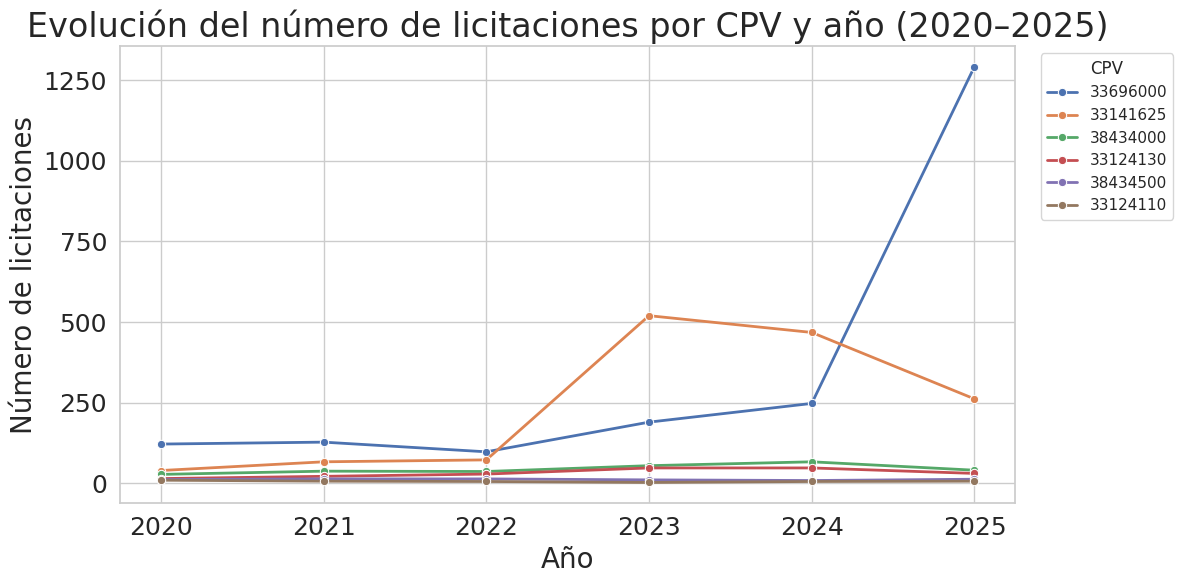

In [ ]:
import re
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

YEARS = list(range(2020, 2026))
sns.set_style("whitegrid")

# 1) Asegura 'Año'
df = df_ccaa_full.copy()
if "Año" not in df.columns:
    if "Fecha" in df.columns:
        df["Año"] = pd.to_datetime(df["Fecha"], errors="coerce", utc=True).dt.tz_convert(None).dt.year
    else:
        raise ValueError("No existe 'Año' ni 'Fecha' para derivarlo.")

# 2) CPV limpio a 8 dígitos
df["CPV_clean"] = df["CPV"].astype(str).str.extract(r"(\d{8})", expand=False)
df = df.dropna(subset=["CPV_clean"]).copy()

# 3) Volumen por Año×CPV (IDs únicos si hay 'ID')
if "ID" in df.columns:
    agg = (df.dropna(subset=["ID"])
             .groupby(["Año","CPV_clean"])["ID"].nunique()
             .rename("N_Licitaciones")
             .reset_index())
else:
    agg = (df.groupby(["Año","CPV_clean"])
             .size()
             .rename("N_Licitaciones")
             .reset_index())

# 4) Rellenar grid completo de años×CPV → 0 donde falte
cpv_list = sorted(agg["CPV_clean"].unique())
grid = pd.MultiIndex.from_product([YEARS, cpv_list], names=["Año","CPV_clean"]).to_frame(index=False)
agg_full = (grid.merge(agg, on=["Año","CPV_clean"], how="left")
                 .fillna({"N_Licitaciones": 0}))
agg_full["N_Licitaciones"] = agg_full["N_Licitaciones"].astype(int)

# 5) Orden opcional de leyenda: CPVs con mayor volumen total primero
order_cpv = (agg_full.groupby("CPV_clean")["N_Licitaciones"]
                      .sum()
                      .sort_values(ascending=False)
                      .index.tolist())

topN = 6
order_cpv = order_cpv[:topN]
agg_full = agg_full[agg_full["CPV_clean"].isin(order_cpv)]

# 6) Plot
plt.figure(figsize=(12, 6))
ax = sns.lineplot(
    data=agg_full.sort_values(["CPV_clean","Año"]),
    x="Año", y="N_Licitaciones",
    hue="CPV_clean", hue_order=order_cpv,
    marker="o", linewidth=2
)
ax.set_title("Evolución del número de licitaciones por CPV y año (2020–2025)")
ax.set_xlabel("Año")
ax.set_ylabel("Número de licitaciones")
ax.set_xticks(YEARS)
ax.yaxis.set_major_locator(MaxNLocator(nbins=6, integer=True))
ax.legend(title="CPV", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.show()



## 4.2.4. Indicadores agregados y comparativos

Ranking de gasto en IVD por habitante

% del gasto sanitario que corresponde a IVD

Clasificación de intensidad inversora en IVD



###Ranking de gasto en IVD por habitante

/tmp/ipython-input-763974511.py:88: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


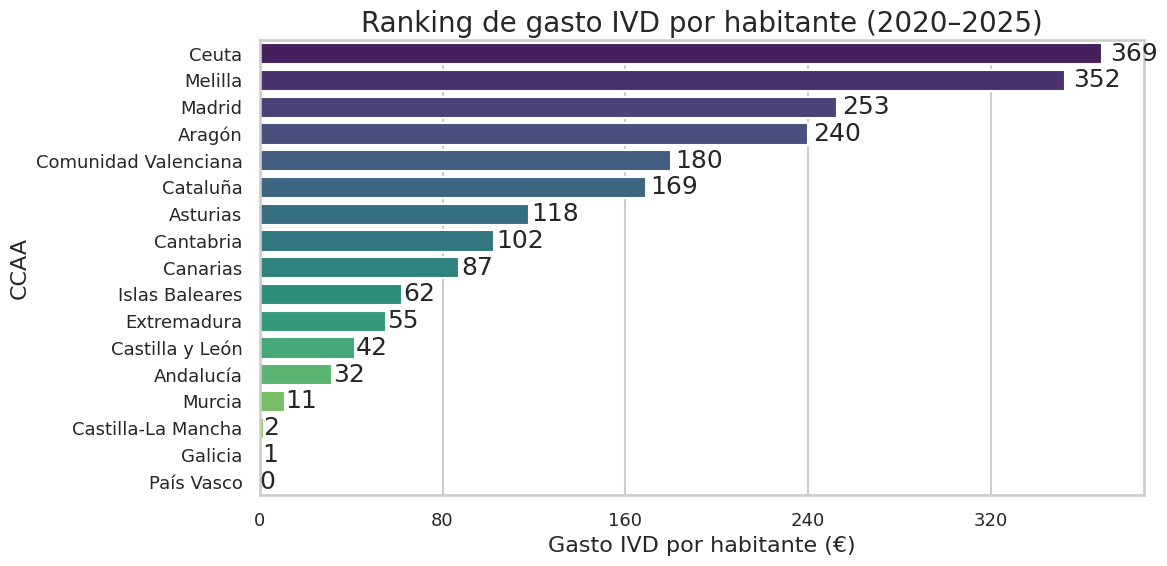

/tmp/ipython-input-763974511.py:88: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


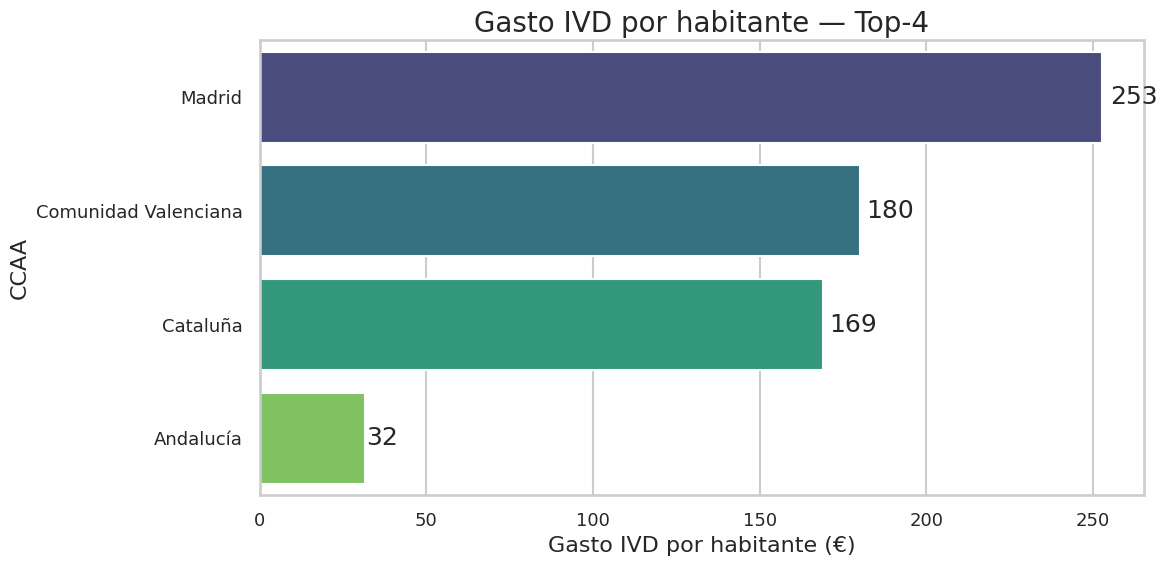

/tmp/ipython-input-763974511.py:88: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


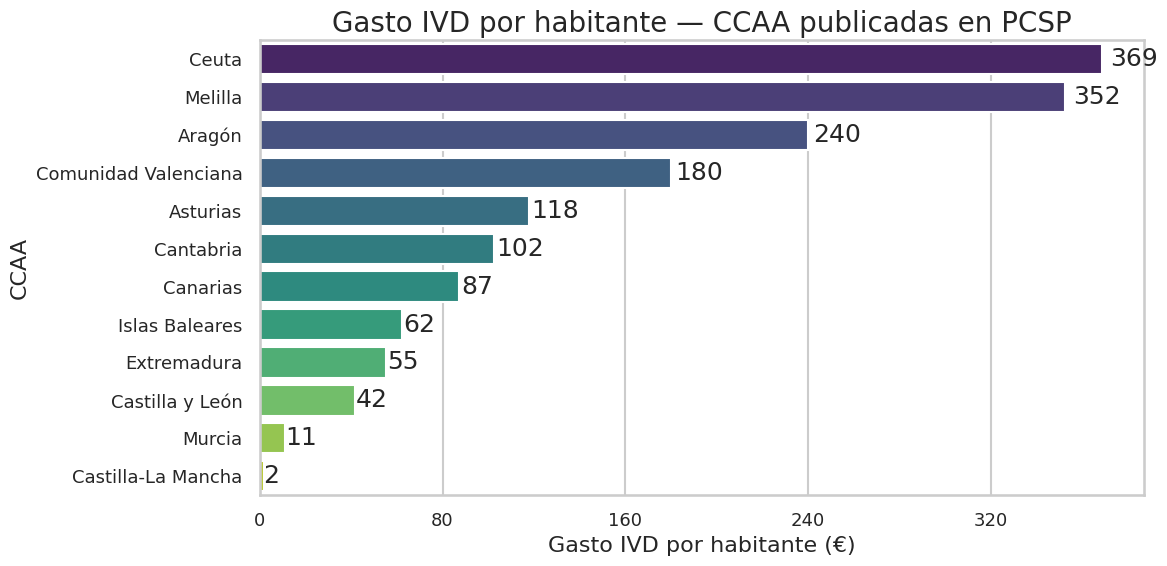

ℹ️ Para calcular el % del gasto sanitario destinado a IVD y el cuadrante, proporciona el diccionario 'salud_pc' con gasto sanitario público por habitante (media 2020–2025).


In [ ]:
# ================== 1) Datos de población (2020–2025) ==================
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

# Diccionario que nos diste (población por año 2020..2025)
pop_data = {
    "Andalucía": [8460261, 8465236, 8494155, 8600244, 8620120, 8663175],
    "Aragón": [1328753, 1325371, 1325342, 1354144, 1348918, 1352630],
    "Asturias": [1018706, 1011560, 1004499, 1006558, 1008876, 1014112],
    "Islas Baleares": [1171003, 1172333, 1176254, 1220739, 1231487, 1244394],
    "Canarias": [2174474, 2171364, 2176412, 2224343, 2236013, 2258219],
    "Cantabria": [582796, 574308, 585222, 589279, 591151, 593386],
    "Castilla y León": [2393285, 2381281, 2370064, 2383702, 2389959, 2397889],
    "Castilla-La Mancha": [2044408, 2047792, 2052193, 2089074, 2100523, 2120261],
    "Cataluña": [7778362, 7756928, 7783302, 7970295, 8021049, 8119550],
    "Comunidad Valenciana": [5054796, 5049415, 5090839, 5268012, 5316478, 5414296],
    "Extremadura": [1063575, 1058763, 1054245, 1053463, 1053423, 1052998],
    "Galicia": [2700268, 2694245, 2689152, 2699938, 2705877, 2715424],
    "Madrid": [6778382, 6745591, 6744456, 6917111, 7000621, 7125583],
    "Murcia": [1510951, 1517938, 1531439, 1560347, 1569164, 1584801],
    "Navarra": [660887, 661023, 663612, 674796, 678103, 683525],
    "País Vasco": [2219777, 2212561, 2207201, 2224072, 2227581, 2240113],
    "La Rioja": [319653, 319224, 319485, 323377, 324226, 327115],
    "Ceuta": [83842, 83517, 82566, 82831, 83284, 83512],
    "Melilla": [87076, 86199, 85159, 85622, 86056, 87001],
}

# Canon de nombres para asegurar coincidencia entre df_ccaa_full y el diccionario
canon_map = {
    "Comunidad de Madrid": "Madrid",
    "Valencia": "Comunidad Valenciana",
    "Región de Murcia": "Murcia",
    "Baleares": "Islas Baleares",
    "Illes Balears": "Islas Baleares",
    "Cataluna": "Cataluña",           # por si viniera sin tilde
    "Pais Vasco": "País Vasco",
}

def canon_ccaa(name: str) -> str:
    if pd.isna(name):
        return name
    n = str(name).strip()
    return canon_map.get(n, n)

# ================== 2) Agregado de gasto IVD por CCAA (2020–2025) ==================
# Partimos de df_ccaa_full (tu “single source of truth”)
df = df_ccaa_full.copy()
df["CCAA_canon"] = df["CCAA"].apply(canon_ccaa)

# Asegura gasto numérico
col_gasto = "Gasto (€)" if "Gasto (€)" in df.columns else "Presupuesto"
df[col_gasto] = pd.to_numeric(df[col_gasto], errors="coerce").fillna(0.0)

gasto_total = df.groupby("CCAA_canon", as_index=False)[col_gasto].sum().rename(columns={col_gasto:"Gasto_total"})

# ================== 3) Población media 2020–2025 ==================
pop_mean = pd.DataFrame({
    "CCAA_canon": list(pop_data.keys()),
    "Pobl_media": [float(np.mean(v)) for v in pop_data.values()],
})

# ================== 4) Gasto IVD por habitante ==================
df_pc = gasto_total.merge(pop_mean, on="CCAA_canon", how="left")
df_pc["Gasto_per_capita"] = df_pc["Gasto_total"] / df_pc["Pobl_media"]

# Rangos y orden
df_pc_rank = df_pc.sort_values("Gasto_per_capita", ascending=False).reset_index(drop=True)

# ================== 5) Gráficos: ranking general, Top-4 y resto ==================
TOP4 = ["Madrid","Andalucía","Cataluña","Comunidad Valenciana"]
PCSP_CCAA = [
    "Aragón","Asturias","Islas Baleares","Canarias","Cantabria",
    "Castilla-La Mancha","Castilla y León","Comunidad Valenciana",
    "Extremadura","Murcia","La Rioja","Ceuta","Melilla",
]

sns.set_style("whitegrid")
sns.set_context("talk", rc={"axes.titlesize":20, "axes.labelsize":16,
                            "xtick.labelsize":13, "ytick.labelsize":13})

fmt_eur = mticker.FuncFormatter(lambda x, _: f"{x:,.0f}".replace(",", "."))  # miles con punto

def plot_rank(data, title):
    plt.figure(figsize=(12,6))
    ax = sns.barplot(
        data=data, x="Gasto_per_capita", y="CCAA_canon",
        orient="h", palette="viridis"
    )
    ax.set_title(title)
    ax.set_xlabel("Gasto IVD por habitante (€)")
    ax.set_ylabel("CCAA")
    ax.xaxis.set_major_locator(mticker.MaxNLocator(nbins=6))
    ax.xaxis.set_major_formatter(fmt_eur)
    # anotaciones
    for p, v in zip(ax.patches, data["Gasto_per_capita"].values):
        ax.text(p.get_width()*1.01, p.get_y()+p.get_height()/2,
                f"{v:,.0f}".replace(",", "."), va="center", ha="left")
    plt.tight_layout(); plt.show()

# Ranking general
plot_rank(df_pc_rank, "Ranking de gasto IVD por habitante (2020–2025)")

# Top-4
plot_rank(df_pc[df_pc["CCAA_canon"].isin(TOP4)].sort_values("Gasto_per_capita", ascending=False),
          "Gasto IVD por habitante — Top-4")

# Resto (PCSP)
resto = [c for c in PCSP_CCAA if c in df_pc["CCAA_canon"].unique()]
plot_rank(df_pc[df_pc["CCAA_canon"].isin(resto)].sort_values("Gasto_per_capita", ascending=False),
          "Gasto IVD por habitante — CCAA publicadas en PCSP")

# ================== 6) (Opcional) % del gasto sanitario destinado a IVD ==================
# Proporciona, si quieres, un diccionario con el gasto sanitario público por habitante (media 2020–2025).
# Ejemplo de estructura (rellena valores reales):
salud_pc = {
    # "Madrid": 1800.0, "Cataluña": 1850.0, ...
}

if len(salud_pc) >= 5:  # solo calculo si hay datos suficientes
    gs = pd.DataFrame({"CCAA_canon": list(salud_pc.keys()),
                       "Gasto_sanit_pc": list(salud_pc.values())})
    comp = df_pc.merge(gs, on="CCAA_canon", how="inner")
    comp = comp[comp["Gasto_sanit_pc"] > 0].copy()
    comp["% IVD sobre gasto sanitario"] = 100.0 * comp["Gasto_per_capita"] / comp["Gasto_sanit_pc"]
    comp = comp.sort_values("% IVD sobre gasto sanitario", ascending=False)

    # gráfico
    plt.figure(figsize=(12,6))
    ax = sns.barplot(
        data=comp, x="% IVD sobre gasto sanitario", y="CCAA_canon",
        orient="h", palette="magma"
    )
    ax.set_title("% del gasto sanitario público destinado a IVD (2020–2025)")
    ax.set_xlabel("% sobre gasto sanitario por habitante")
    ax.set_ylabel("CCAA")
    ax.xaxis.set_major_locator(mticker.MaxNLocator(nbins=6))
    plt.tight_layout(); plt.show()

    # ================== 7) (Opcional) Cuadrante de intensidad inversora ==================
    # Líneas de corte: medianas (puedes cambiar a terciles o umbrales específicos)
    med_ivd_pc = comp["Gasto_per_capita"].median()
    med_pct    = comp["% IVD sobre gasto sanitario"].median()

    plt.figure(figsize=(10,7))
    ax = sns.scatterplot(
        data=comp, x="Gasto_per_capita", y="% IVD sobre gasto sanitario",
        hue="CCAA_canon", s=120, palette="Set2"
    )
    ax.axvline(med_ivd_pc, color="grey", linestyle="--")
    ax.axhline(med_pct,    color="grey", linestyle="--")
    ax.set_title("Intensidad inversora en IVD por CCAA (2020–2025)")
    ax.set_xlabel("Gasto IVD por habitante (€)")
    ax.set_ylabel("% IVD sobre gasto sanitario")
    ax.xaxis.set_major_formatter(fmt_eur)
    # etiquetas
    for _, r in comp.iterrows():
        ax.text(r["Gasto_per_capita"]*1.005, r["% IVD sobre gasto sanitario"]*1.005, r["CCAA_canon"])
    plt.tight_layout(); plt.show()
else:
    print("ℹ️ Para calcular el % del gasto sanitario destinado a IVD y el cuadrante, "
          "proporciona el diccionario 'salud_pc' con gasto sanitario público por habitante (media 2020–2025).")



/tmp/ipython-input-1345483522.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=data, x="Gasto_per_capita", y="CCAA_canon",


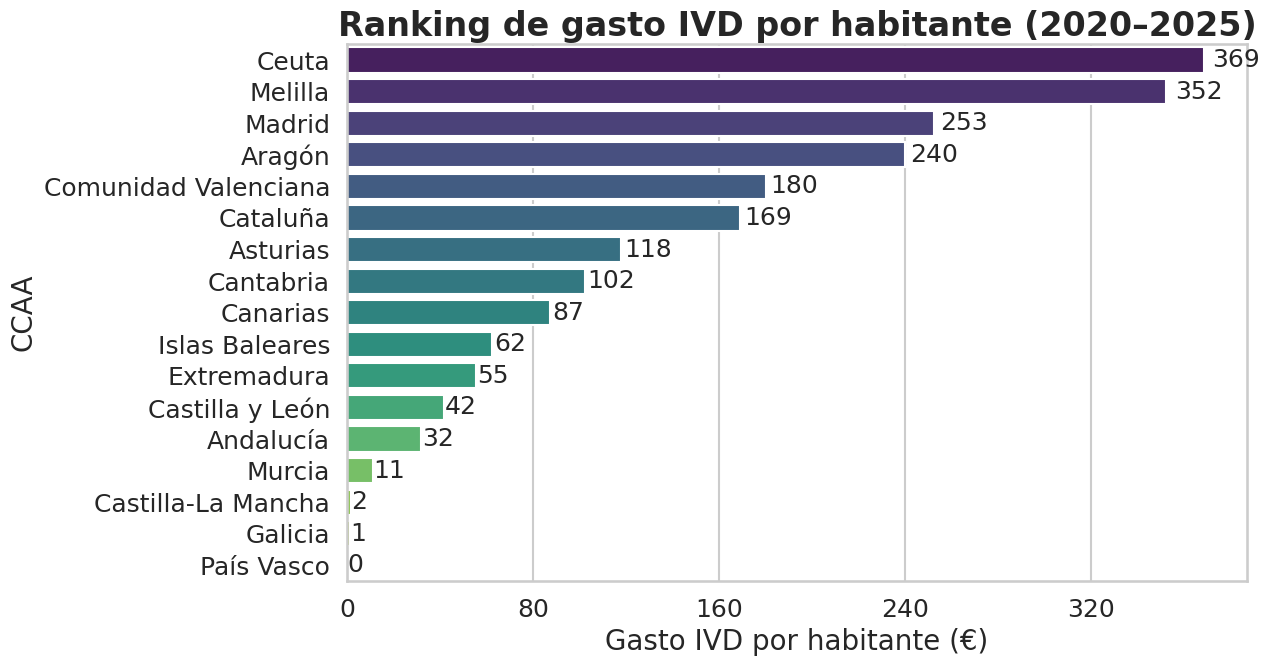

/tmp/ipython-input-1345483522.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=data, x="Gasto_per_capita", y="CCAA_canon",


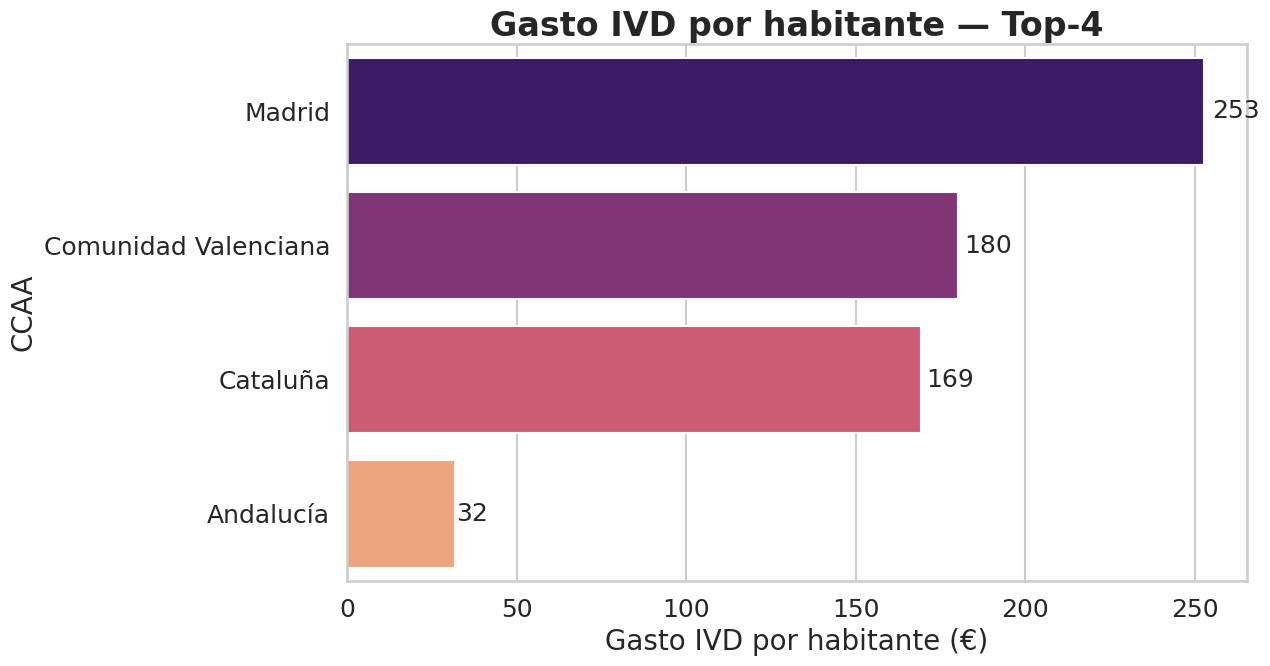

/tmp/ipython-input-1345483522.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=data, x="Gasto_per_capita", y="CCAA_canon",


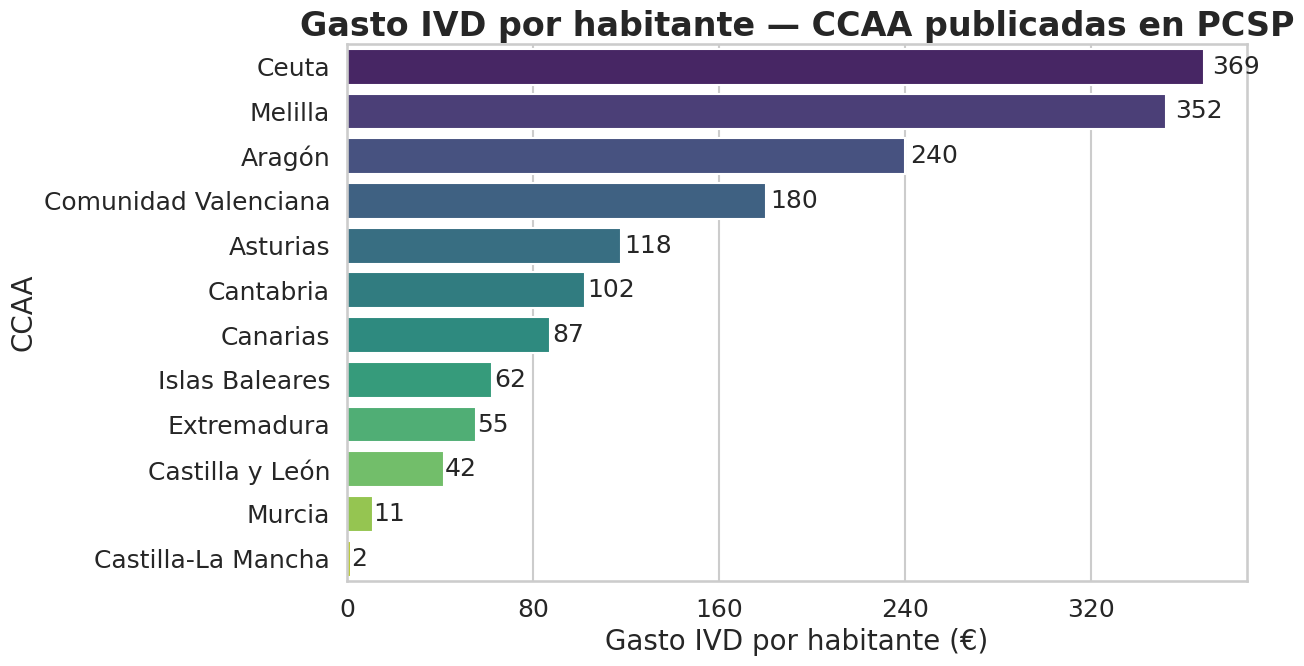

ℹ️ Proporciona 'salud_pc' para calcular el % IVD y el cuadrante.


In [ ]:
# ================== 5) Gráficos con formato TFM unificado ==================
import matplotlib.ticker as mticker
from matplotlib.ticker import MaxNLocator
from pathlib import Path

# ---- Config tipográfica global coherente con el TFM ----
FONT_TITLE = 24
FONT_LABEL = 20
FONT_TICKS = 18

plt.rcParams.update({
    "figure.figsize": (13, 7),
    "axes.grid": True,
    "axes.titlesize": FONT_TITLE,
    "axes.labelsize": FONT_LABEL,
    "xtick.labelsize": FONT_TICKS,
    "ytick.labelsize": FONT_TICKS,
    "legend.fontsize": 11,
})
sns.set_style("whitegrid")

def apply_axis_fonts(ax, title=None, xlabel=None, ylabel=None):
    if title is not None:
        ax.set_title(title, fontsize=FONT_TITLE, weight='bold')
    if xlabel is not None:
        ax.set_xlabel(xlabel, fontsize=FONT_LABEL)
    if ylabel is not None:
        ax.set_ylabel(ylabel, fontsize=FONT_LABEL)
    ax.tick_params(axis='both', labelsize=FONT_TICKS)

fmt_eur = mticker.FuncFormatter(lambda x, _: f"{x:,.0f}".replace(",", "."))
fmt_pct = mticker.FuncFormatter(lambda x, _: f"{x:.1f}%".replace(",", "."))

# Carpeta de salida y timestamp (si quieres guardar ficheros)
OUTPUT_DIR = Path("/content/drive/MyDrive/Data/Resultados_IVD")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
ts = pd.Timestamp.now(tz="Europe/Madrid").strftime("%Y%m%d_%H%M")

def plot_rank(data, title, filename_prefix=None, palette="viridis"):
    fig, ax = plt.subplots(figsize=(13, 7))
    sns.barplot(data=data, x="Gasto_per_capita", y="CCAA_canon",
                orient="h", palette=palette, ax=ax)
    apply_axis_fonts(ax, title=title,
                     xlabel="Gasto IVD por habitante (€)",
                     ylabel="CCAA")
    ax.xaxis.set_major_locator(MaxNLocator(nbins=6))
    ax.xaxis.set_major_formatter(fmt_eur)
    # Anotaciones al final de cada barra
    for p, v in zip(ax.patches, data["Gasto_per_capita"].values):
        ax.text(p.get_width()*1.01, p.get_y()+p.get_height()/2,
                f"{v:,.0f}".replace(",", "."), va="center", ha="left", fontsize=FONT_TICKS)
    plt.tight_layout()
    if filename_prefix:
        plt.savefig(OUTPUT_DIR / f"{filename_prefix}_{ts}.png", dpi=200, bbox_inches="tight")
        plt.savefig(OUTPUT_DIR / f"{filename_prefix}_{ts}.svg", bbox_inches="tight")
    plt.show()

# ----- Ranking general -----
plot_rank(df_pc_rank, "Ranking de gasto IVD por habitante (2020–2025)",
          filename_prefix="ranking_ivd_per_capita")

# ----- Top-4 -----
plot_rank(df_pc[df_pc["CCAA_canon"].isin(TOP4)]
          .sort_values("Gasto_per_capita", ascending=False),
          "Gasto IVD por habitante — Top-4",
          filename_prefix="ranking_ivd_per_capita_top4",
          palette="magma")

# ----- Resto (PCSP) -----
resto = [c for c in PCSP_CCAA if c in df_pc["CCAA_canon"].unique()]
plot_rank(df_pc[df_pc["CCAA_canon"].isin(resto)]
          .sort_values("Gasto_per_capita", ascending=False),
          "Gasto IVD por habitante — CCAA publicadas en PCSP",
          filename_prefix="ranking_ivd_per_capita_pcsp",
          palette="viridis")

# ================== 6) (Opcional) % del gasto sanitario destinado a IVD ==================
# Usa tu diccionario 'salud_pc' si lo tienes disponible.
if len(salud_pc) >= 5:
    gs = pd.DataFrame({"CCAA_canon": list(salud_pc.keys()),
                       "Gasto_sanit_pc": list(salud_pc.values())})
    comp = df_pc.merge(gs, on="CCAA_canon", how="inner")
    comp = comp[comp["Gasto_sanit_pc"] > 0].copy()
    comp["% IVD sobre gasto sanitario"] = 100.0 * comp["Gasto_per_capita"] / comp["Gasto_sanit_pc"]
    comp = comp.sort_values("% IVD sobre gasto sanitario", ascending=False)

    # Barra horizontal en %
    fig, ax = plt.subplots(figsize=(13, 7))
    sns.barplot(data=comp, x="% IVD sobre gasto sanitario", y="CCAA_canon",
                orient="h", palette="magma", ax=ax)
    apply_axis_fonts(ax, title="% del gasto sanitario público destinado a IVD (2020–2025)",
                     xlabel="% sobre gasto sanitario por habitante", ylabel="CCAA")
    ax.xaxis.set_major_locator(MaxNLocator(nbins=6))
    ax.xaxis.set_major_formatter(fmt_pct)
    for p, v in zip(ax.patches, comp["% IVD sobre gasto sanitario"].values):
        ax.text(p.get_width()*1.01, p.get_y()+p.get_height()/2,
                f"{v:.1f}%".replace(",", "."), va="center", ha="left", fontsize=FONT_TICKS)
    plt.tight_layout()
    plt.savefig(OUTPUT_DIR / f"intensidad_ivd_{ts}.png", dpi=200, bbox_inches="tight")
    plt.savefig(OUTPUT_DIR / f"intensidad_ivd_{ts}.svg", bbox_inches="tight")
    plt.show()

    # ---- (Opcional) Cuadrante de intensidad inversora ----
    med_ivd_pc = comp["Gasto_per_capita"].median()
    med_pct    = comp["% IVD sobre gasto sanitario"].median()

    fig, ax = plt.subplots(figsize=(13, 7))
    sns.scatterplot(data=comp, x="Gasto_per_capita", y="% IVD sobre gasto sanitario",
                    hue="CCAA_canon", s=120, palette="Set2", ax=ax, legend=False)
    ax.axvline(med_ivd_pc, color="grey", linestyle="--")
    ax.axhline(med_pct,    color="grey", linestyle="--")
    apply_axis_fonts(ax, title="Intensidad inversora en IVD por CCAA (2020–2025)",
                     xlabel="Gasto IVD por habitante (€)", ylabel="% IVD sobre gasto sanitario")
    ax.xaxis.set_major_formatter(fmt_eur)
    for _, r in comp.iterrows():
        ax.text(r["Gasto_per_capita"]*1.005, r["% IVD sobre gasto sanitario"]*1.005,
                r["CCAA_canon"], fontsize=FONT_TICKS-3)
    plt.tight_layout()
    plt.savefig(OUTPUT_DIR / f"cuadrante_intensidad_ivd_{ts}.png", dpi=200, bbox_inches="tight")
    plt.savefig(OUTPUT_DIR / f"cuadrante_intensidad_ivd_{ts}.svg", bbox_inches="tight")
    plt.show()
else:
    print("ℹ️ Proporciona 'salud_pc' para calcular el % IVD y el cuadrante.")


###% del gasto sanitario que corresponde a IVD

/tmp/ipython-input-1441189208.py:138: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=ranking, x="%PIB_IVD_medio", y="CCAA_canon",


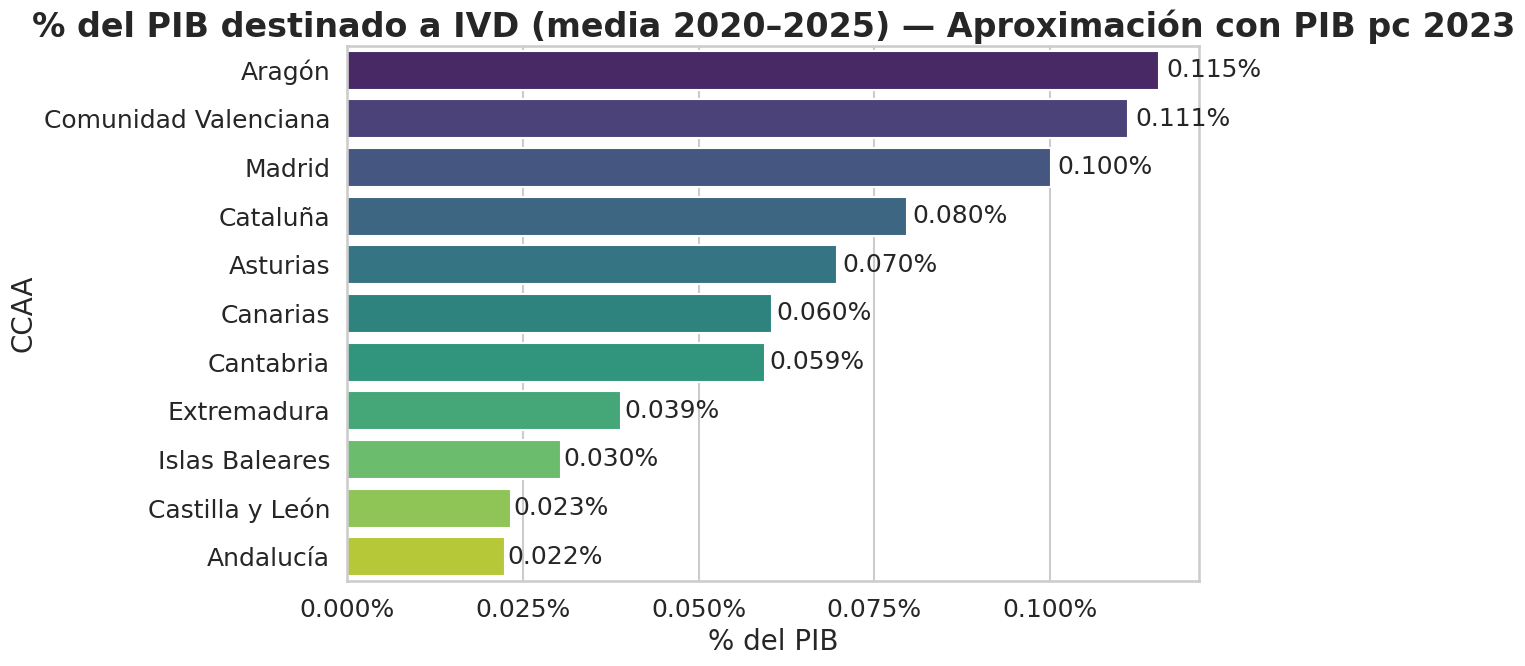

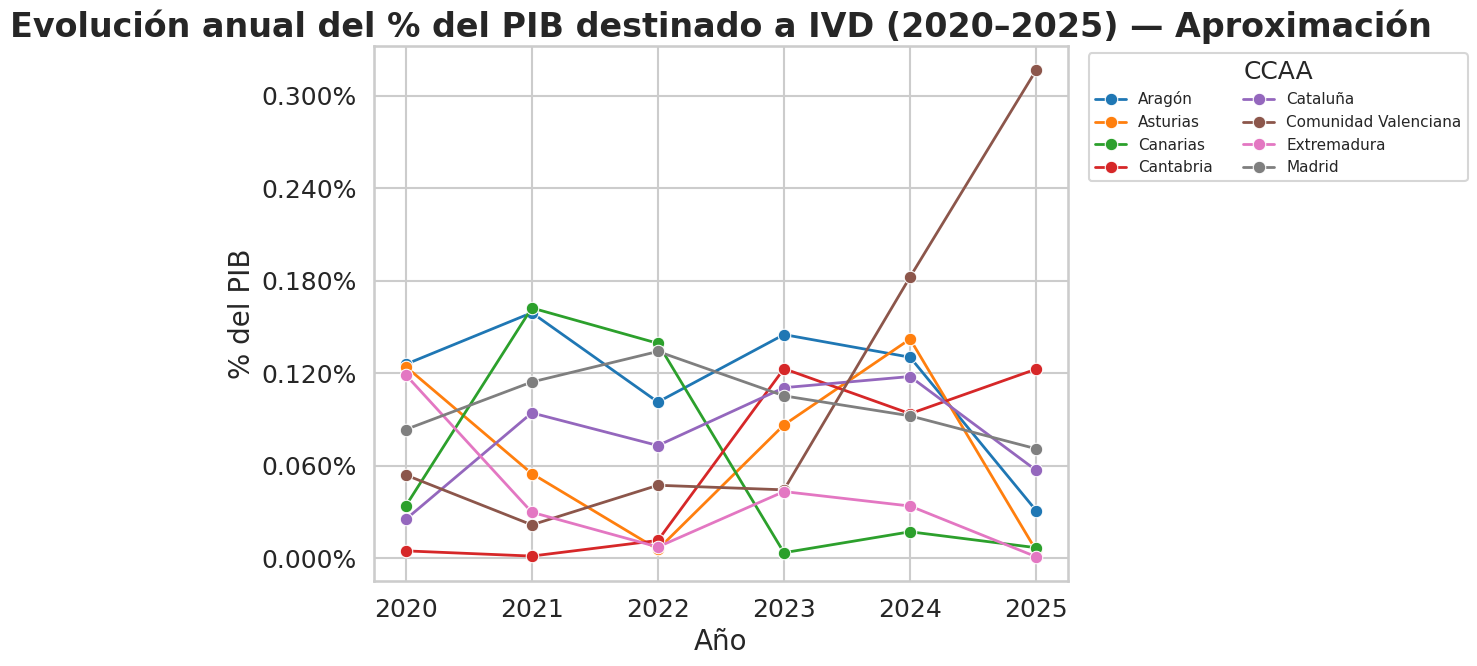

In [ ]:
# ===================== Indicador %PIB destinado a IVD (2020–2025) =====================
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib.ticker import MaxNLocator
from pathlib import Path

# ===================== Config global TFM (misma que el resto) =====================
FONT_TITLE = 24
FONT_LABEL = 20
FONT_TICKS = 18

plt.rcParams.update({
    "figure.figsize": (13, 7),
    "axes.grid": True,
    "axes.titlesize": FONT_TITLE,
    "axes.labelsize": FONT_LABEL,
    "xtick.labelsize": FONT_TICKS,
    "ytick.labelsize": FONT_TICKS,
    "legend.fontsize": 11,
})
sns.set_style("whitegrid")

def apply_axis_fonts(ax, title=None, xlabel=None, ylabel=None):
    if title is not None:
        ax.set_title(title, fontsize=FONT_TITLE, weight='bold')
    if xlabel is not None:
        ax.set_xlabel(xlabel, fontsize=FONT_LABEL)
    if ylabel is not None:
        ax.set_ylabel(ylabel, fontsize=FONT_LABEL)
    ax.tick_params(axis='both', labelsize=FONT_TICKS)

fmt_pct3 = mticker.FuncFormatter(lambda x, _: f"{x:.3f}%".replace(",", "."))

# Carpeta de salida + timestamp
OUTPUT_DIR = Path("/content/drive/MyDrive/Data/Resultados_IVD")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
ts = pd.Timestamp.now(tz="Europe/Madrid").strftime("%Y%m%d_%H%M")

# ===================== Config & datos base =====================
YEARS = list(range(2020, 2026))

# --- diccionarios aportados (poblaciones por año y PIB pc 2023) ---
pop_data = {
    "Andalucía": [8460261, 8465236, 8494155, 8600244, 8620120, 8663175],
    "Aragón": [1328753, 1325371, 1325342, 1354144, 1348918, 1352630],
    "Asturias": [1018706, 1011560, 1004499, 1006558, 1008876, 1014112],
    "Islas Baleares": [1171003, 1172333, 1176254, 1220739, 1231487, 1244394],
    "Canarias": [2174474, 2171364, 2176412, 2224343, 2236013, 2258219],
    "Cantabria": [582796, 574308, 585222, 589279, 591151, 593386],
    "Castilla y León": [2393285, 2381281, 2370064, 2383702, 2389959, 2397889],
    "Cataluña": [7778362, 7756928, 7783302, 7970295, 8021049, 8119550],
    "Comunidad Valenciana": [5054796, 5049415, 5090839, 5268012, 5316478, 5414296],
    "Extremadura": [1063575, 1058763, 1054245, 1053463, 1053423, 1052998],
    "Madrid": [6778382, 6745591, 6744456, 6917111, 7000621, 7125583],
    "Navarra": [660887, 661023, 663612, 674796, 678103, 683525],
    "La Rioja": [319653, 319224, 319485, 323377, 324226, 327115],
    # Ceuta/Melilla no incluidas aquí al no usarse en %PIB con tu diccionario.
}

pib_pc_2023 = {
    "Andalucía": 23218, "Aragón": 34658, "Asturias": 28130, "Islas Baleares": 34381,
    "Canarias": 24345, "Cantabria": 28461, "Castilla y León": 29698, "Castilla-La Mancha": 25758,
    "Cataluña": 35325, "Comunidad Valenciana": 26453, "Extremadura": 23604, "Galicia": 28644,
    "Madrid": 42198, "Murcia": 25887, "Comunidad Foral de Navarra": 37088,
    "País Vasco": 39547, "La Rioja": 32828
}

# --- normalización de nombres para casar df_ccaa_full con diccionarios ---
canon_map = {
    "Comunidad de Madrid": "Madrid",
    "Región de Murcia": "Murcia",
    "Illes Balears": "Islas Baleares",
    "Baleares": "Islas Baleares",
    "Valencia": "Comunidad Valenciana",
    "Navarra": "Comunidad Foral de Navarra",
    "Cataluna": "Cataluña",
    "Pais Vasco": "País Vasco",
}
def canon_ccaa(x: str) -> str:
    if pd.isna(x): return x
    x = str(x).strip()
    return canon_map.get(x, x)

# ===================== 1) Gasto IVD por CCAA y año (euros) =====================
df = df_ccaa_full.copy()

# Asegura 'Año'
if "Año" not in df.columns:
    if "Fecha" in df.columns:
        fechas = pd.to_datetime(df["Fecha"], errors="coerce", utc=True)
        df["Año"] = fechas.dt.tz_convert(None).dt.year
    else:
        raise ValueError("Falta 'Año' y no hay 'Fecha' para derivarlo.")

# Asegura gasto numérico
col_gasto = "Gasto (€)" if "Gasto (€)" in df.columns else "Presupuesto"
df[col_gasto] = pd.to_numeric(df[col_gasto], errors="coerce").fillna(0.0)

# Canoniza nombre CCAA
df["CCAA_canon"] = df["CCAA"].apply(canon_ccaa)

# Agrega gasto por Año×CCAA
gasto_anual = (df.groupby(["Año","CCAA_canon"], as_index=False)[col_gasto].sum()
                 .rename(columns={col_gasto: "Gasto_IVD_€"}))

# ===================== 2) Población por CCAA y año =====================
pop_rows = []
for ccaa, series in pop_data.items():
    for i, year in enumerate(YEARS):
        pop_rows.append({"CCAA_canon": ccaa, "Año": year, "Poblacion": series[i]})
pop_df = pd.DataFrame(pop_rows)

# ===================== 3) Une gasto + población y calcula IVD per cápita =====================
panel = gasto_anual.merge(pop_df, on=["CCAA_canon","Año"], how="inner")
panel["IVD_pc"] = panel["Gasto_IVD_€"] / panel["Poblacion"]  # euros por habitante

# ===================== 4) Añade PIB pc 2023 y calcula % del PIB =====================
pib_df = pd.DataFrame({"CCAA_canon": list(pib_pc_2023.keys()),
                       "PIB_pc_2023": list(pib_pc_2023.values())})
panel = panel.merge(pib_df, on="CCAA_canon", how="inner")
panel["%PIB_IVD"] = 100.0 * panel["IVD_pc"] / panel["PIB_pc_2023"]

# ===================== 5) Resultados: anual y ranking medio 2020–2025 =====================
ranking = (panel.groupby("CCAA_canon", as_index=False)
                 .agg(**{
                     "Gasto_IVD_total_€": ("Gasto_IVD_€","sum"),
                     "IVD_pc_medio": ("IVD_pc","mean"),
                     "%PIB_IVD_medio": ("%PIB_IVD","mean"),
                 })
          .sort_values("%PIB_IVD_medio", ascending=False))

# ===================== 6) Gráficas con formato TFM =====================
# (i) Barras: ranking %PIB_IVD medio (2020–2025)
fig, ax = plt.subplots(figsize=(13, 7))
sns.barplot(data=ranking, x="%PIB_IVD_medio", y="CCAA_canon",
            orient="h", palette="viridis", ax=ax)
apply_axis_fonts(ax,
                 title="% del PIB destinado a IVD (media 2020–2025) — Aproximación con PIB pc 2023",
                 xlabel="% del PIB", ylabel="CCAA")
ax.xaxis.set_major_locator(MaxNLocator(nbins=6))
ax.xaxis.set_major_formatter(fmt_pct3)
# Anotaciones
for p, v in zip(ax.patches, ranking["%PIB_IVD_medio"].values):
    ax.text(p.get_width()*1.01, p.get_y()+p.get_height()/2,
            f"{v:.3f}%".replace(",", "."), va="center", ha="left", fontsize=FONT_TICKS)
plt.tight_layout()
plt.savefig(OUTPUT_DIR / f"intensidad_ivd_ranking_{ts}.png", dpi=200, bbox_inches="tight")
plt.savefig(OUTPUT_DIR / f"intensidad_ivd_ranking_{ts}.svg", bbox_inches="tight")
plt.show()

# (ii) Líneas: evolución anual %PIB_IVD por CCAA (Top-8 por media)
ccaa_plot = ranking["CCAA_canon"].head(8).tolist()
panel_sub = panel[panel["CCAA_canon"].isin(ccaa_plot)].copy()

fig, ax = plt.subplots(figsize=(13, 7))
sns.lineplot(data=panel_sub, x="Año", y="%PIB_IVD",
             hue="CCAA_canon", marker="o", linewidth=2, ax=ax)
apply_axis_fonts(ax,
                 title="Evolución anual del % del PIB destinado a IVD (2020–2025) — Aproximación",
                 xlabel="Año", ylabel="% del PIB")
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.set_xticks(YEARS)
ax.yaxis.set_major_locator(MaxNLocator(nbins=6))
ax.yaxis.set_major_formatter(fmt_pct3)
ax.legend(title="CCAA", ncol=2, bbox_to_anchor=(1.02,1), loc="upper left")
plt.tight_layout()
plt.savefig(OUTPUT_DIR / f"intensidad_ivd_evolucion_top8_{ts}.png", dpi=200, bbox_inches="tight")
plt.savefig(OUTPUT_DIR / f"intensidad_ivd_evolucion_top8_{ts}.svg", bbox_inches="tight")
plt.show()



###Clasificación de intensidad inversora en IVD

CCAA  Cobertura Ofertas (%)
0                Melilla             100.000000
1              Cantabria              75.362319
2            Extremadura              59.322034
3        Castilla y León              57.894737
4               Canarias              51.546392
5     Castilla-La Mancha              50.000000
6                Galicia              50.000000
7                  Ceuta              47.826087
8                 Aragón              47.398844
9         Islas Baleares              44.696970
10                Madrid              40.000000
11  Comunidad Valenciana              28.571429
12             Andalucía              20.833333
13                Murcia              13.333333
14              Asturias              10.000000
15              Cataluña               0.064935
16            País Vasco               0.000000

CCAA  N_adjud  Ofertas_media  SingleBid_rate  SingleBid_rate_%
0  Madrid       32        1.84375          0.6875             68.75

Procedimiento_norm  N_adjud  Ofertas_media  SingleBid_rate  \
2             Negociado        1       1.000000        1.000000   
1  Abierto simplificado       19       1.473684        0.684211   
0               Abierto       12       2.500000        0.666667   

   SingleBid_rate_%  
2        100.000000  
1         68.421053  
0         66.666667

/tmp/ipython-input-1630106498.py:293: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=agg_ccaa, x="SingleBid_rate_%", y="CCAA", orient="h", palette="magma")


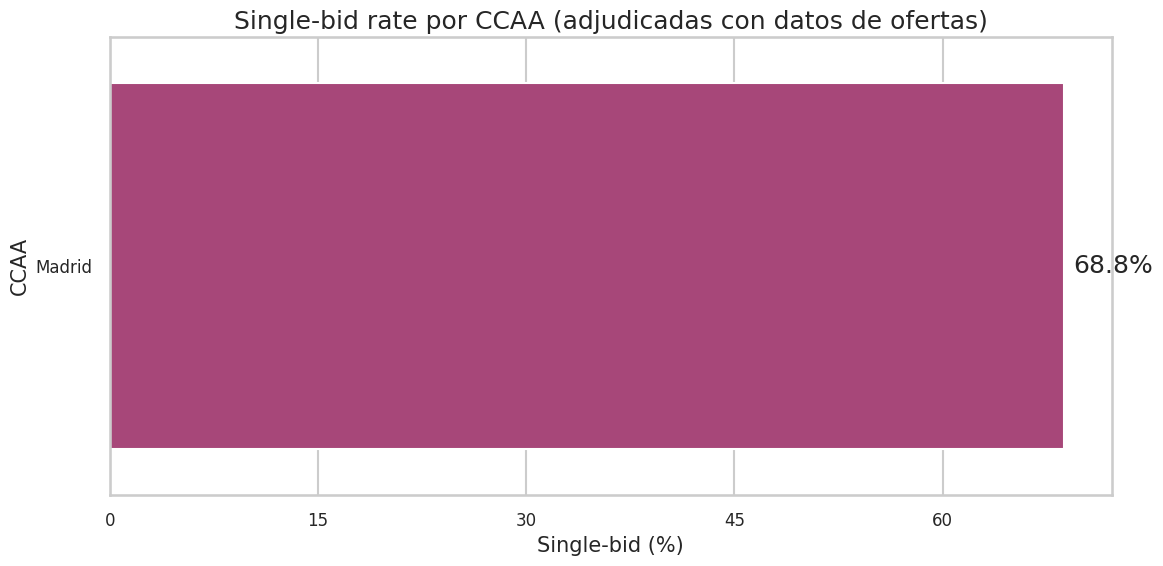

/tmp/ipython-input-1630106498.py:303: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=agg_proc, x="Ofertas_media", y="Procedimiento_norm", orient="h", palette="viridis")


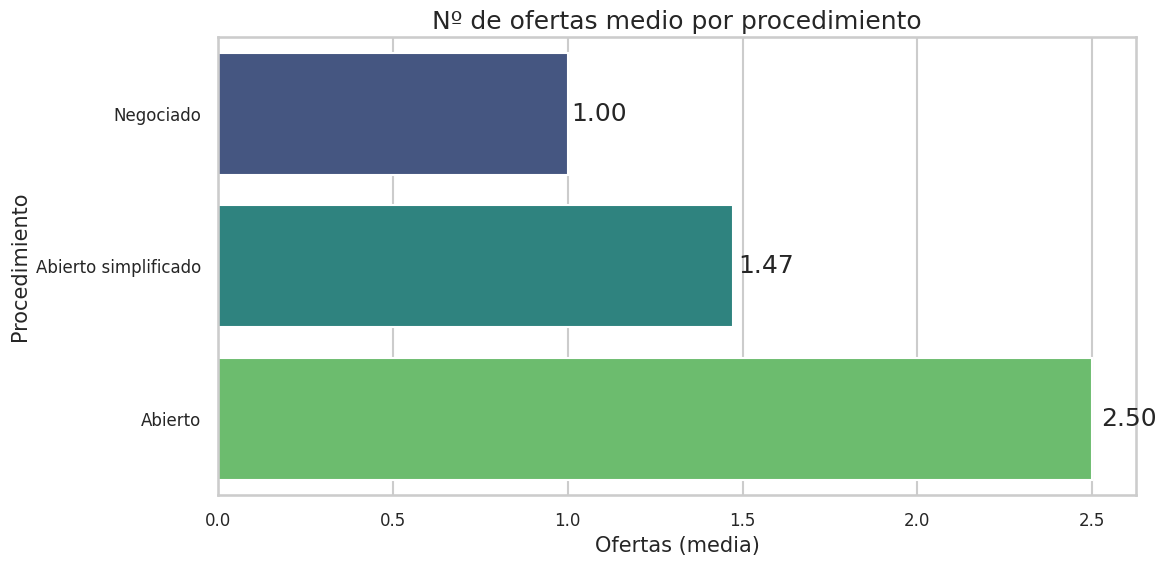

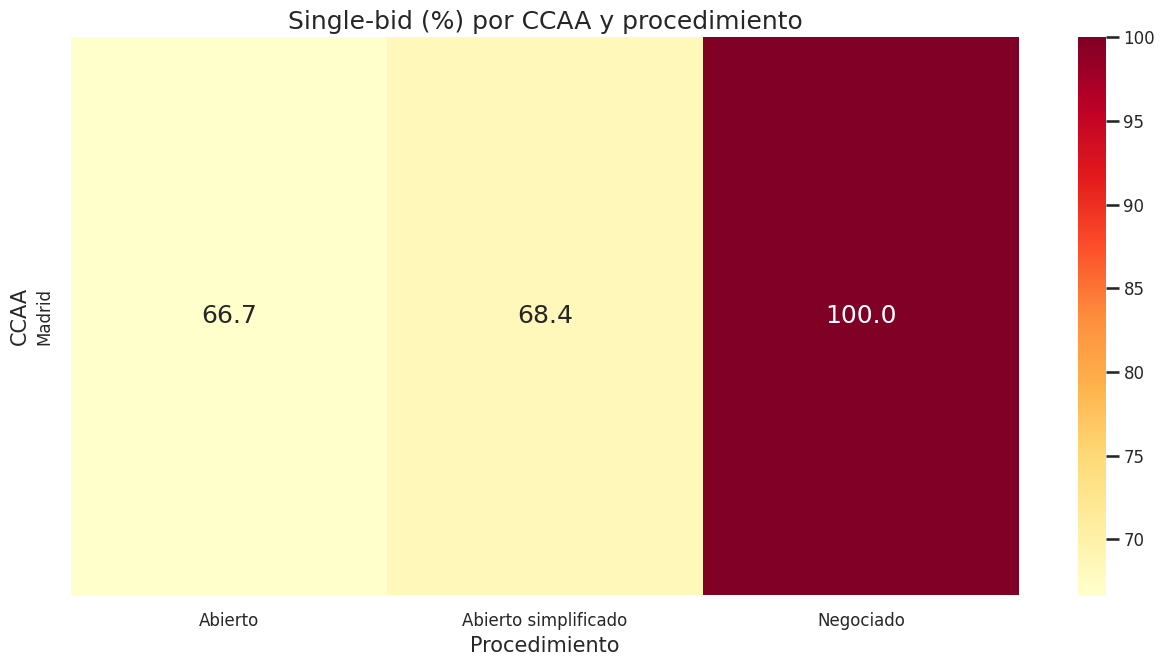

In [ ]:
# ==========================
# 0) Imports y helpers
# ==========================
import os, re, zipfile, xml.etree.ElementTree as ET
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

sns.set_style("whitegrid")
sns.set_context("talk", rc={"axes.titlesize":18, "axes.labelsize":15,
                            "xtick.labelsize":12, "ytick.labelsize":12})

# Tu “single source of truth” ya cargado:
# df_ccaa_full  => columnas estándar: ID, Título, Fecha, Enlace, CPV, Gasto (€) o Presupuesto, Región, CCAA
# Aseguramos nombres esperados:
df = df_ccaa_full.copy()
col_gasto = "Gasto (€)" if "Gasto (€)" in df.columns else "Presupuesto"
if col_gasto not in df.columns:
    raise ValueError("No encuentro columna de gasto ('Gasto (€)' o 'Presupuesto') en df_ccaa_full.")

# Año (si faltase)
if "Año" not in df.columns:
    fechas = pd.to_datetime(df["Fecha"], errors="coerce", utc=True)
    df["Año"] = fechas.dt.tz_convert(None).dt.year

# Normaliza CCAA (ajusta si tienes alias distintos)
canon_map = {
    "Comunidad de Madrid": "Madrid",
    "Illes Balears": "Islas Baleares",
    "Región de Murcia": "Murcia",
    "Valencia": "Comunidad Valenciana",
    "Pais Vasco": "País Vasco",
    "Cataluna": "Cataluña",
}
def canon_ccaa(x):
    if pd.isna(x): return x
    return canon_map.get(str(x).strip(), str(x).strip())

df["CCAA"] = df["CCAA"].apply(canon_ccaa)

# ==========================
# 1) Ofertas y procedimiento desde PCSP (.atom)
#    -> reparsea los zips anuales y saca ID, Ofertas, Procedimiento
# ==========================
NS = {
    'atom': 'http://www.w3.org/2005/Atom',
    'cbc':  'urn:dgpe:names:draft:codice:schema:xsd:CommonBasicComponents-2',
    'cac':  'urn:dgpe:names:draft:codice:schema:xsd:CommonAggregateComponents-2',
    'cac_ext': 'urn:dgpe:names:draft:codice-place-ext:schema:xsd:CommonAggregateComponents-2'
}

def extract_text_any(elem, suffixes):
    """Devuelve el primer texto encontrado cuyo tag acabe en alguno de suffixes."""
    for e in elem.iter():
        tag = e.tag.split('}')[-1].lower()
        if any(tag.endswith(suf.lower()) for suf in suffixes):
            txt = (e.text or "").strip()
            if txt:
                return txt
    return None

def parse_pcsp_zip(zip_path):
    """
    Devuelve DF con columnas:
    - ID (atom:id)    – coincide con tu ID en df_ccaa_full para PCSP
    - Ofertas (float) – ReceivedTenderQuantity si existe
    - Procedimiento   – ProcedureCode/Type si existe
    - Estado_hint     – pista textual (por si quieres filtrar adjudicadas)
    """
    rows = []
    if not os.path.exists(zip_path):
        print(f"⚠️ No existe: {zip_path}")
        return pd.DataFrame()
    with zipfile.ZipFile(zip_path, 'r') as z:
        for member in z.namelist():
            if not member.endswith('.atom'):
                continue
            with z.open(member) as f:
                try:
                    root = ET.parse(f).getroot()
                except ET.ParseError:
                    continue
                for entry in root.findall('atom:entry', NS):
                    cfs = entry.find('cac_ext:ContractFolderStatus', NS)
                    if cfs is None:
                        continue
                    # ID
                    atom_id = entry.findtext('atom:id', default='', namespaces=NS).strip()
                    if not atom_id:
                        continue
                    # Nº ofertas
                    ofertas_txt = None
                    # Busca 'ReceivedTenderQuantity' o similares
                    for e in cfs.iter():
                        tag = e.tag.split('}')[-1].lower()
                        if 'receivedtenderquantity' in tag or 'tendererquantity' in tag:
                            if e.text and e.text.strip():
                                ofertas_txt = e.text.strip()
                                break
                    try:
                        ofertas = float(ofertas_txt) if ofertas_txt is not None else np.nan
                    except:
                        ofertas = np.nan
                    # Procedimiento (muy heterogéneo -> pilla cualquier *procedure* code/text)
                    procedimiento = None
                    for e in cfs.iter():
                        tag = e.tag.split('}')[-1].lower()
                        if 'procedure' in tag and ('code' in tag or 'type' in tag or tag.endswith('procedure')):
                            if e.text and e.text.strip():
                                procedimiento = e.text.strip()
                                break
                    # Estado: pista desde summary (p.ej. "Estado: ADJ")
                    summary = entry.findtext('atom:summary', default='', namespaces=NS).strip()
                    estado_hint = None
                    m = re.search(r"Estado:\s*([A-ZÁÉÍÓÚa-záéíóú/ ]+)", summary)
                    if m:
                        estado_hint = m.group(1).strip()
                    rows.append({"ID": atom_id, "Ofertas": ofertas, "Procedimiento": procedimiento,
                                 "Estado_hint": estado_hint})
    return pd.DataFrame(rows)

# Rutas a tus zips PCSP (ajusta si cambia el nombre)
PCSP_ZIPS = [
    "/content/drive/MyDrive/Data/Tratado_Datos/licitacionesPerfilesContratanteCompleto3_2020.zip",
    "/content/drive/MyDrive/Data/Tratado_Datos/licitacionesPerfilesContratanteCompleto3_2021.zip",
    "/content/drive/MyDrive/Data/Tratado_Datos/licitacionesPerfilesContratanteCompleto3_2022.zip",
    "/content/drive/MyDrive/Data/Tratado_Datos/licitacionesPerfilesContratanteCompleto3_2023.zip",
    "/content/drive/MyDrive/Data/Tratado_Datos/licitacionesPerfilesContratanteCompleto3_2024.zip",
    "/content/drive/MyDrive/Data/Tratado_Datos/licitacionesPerfilesContratanteCompleto3_2025.zip",
]

pcsp_ofertas = pd.concat([parse_pcsp_zip(p) for p in PCSP_ZIPS], ignore_index=True)
pcsp_ofertas = pcsp_ofertas.drop_duplicates(subset=["ID"])

# ==========================
# 2) Ofertas y procedimiento desde MADRID (CSV crudos)
#    -> leemos los CSV originales y creamos mapping por ID
# ==========================
import csv, chardet

def smart_read_madrid(path):
    """Carga CSV crudo de Madrid (salta la primera línea 'licitaciones' si procede)."""
    with open(path, 'rb') as fh:
        enc = chardet.detect(fh.read(30000))['encoding'] or 'utf-8'
    # detecta separador con 2-3 primeras líneas
    with open(path, 'r', encoding=enc, newline='') as fh:
        sample = ''.join([fh.readline() for _ in range(3)])
        try:
            sep = csv.Sniffer().sniff(sample, delimiters=',;|\t').delimiter
        except csv.Error:
            sep = ','
    # lee saltando la primera fila si es 'licitaciones'
    with open(path, 'r', encoding=enc, newline='') as fh:
        first = fh.readline()
        skip = 1 if 'licitaciones' in first.lower() else 0
    dfm = pd.read_csv(path, sep=sep, encoding=enc, header=0 if skip==0 else None, skiprows=skip, engine='python')
    # Si no hay cabecera “real”, crea genéricas
    if skip==1:
        dfm.columns = [f"col{i}" for i in range(dfm.shape[1])]
    return dfm

def extract_id_title(dfm):
    """Devuelve (ID, Título) a partir de columnas conocidas en Madrid."""
    cols = [c for c in dfm.columns]
    # casos: "Nº Expediente", "Nº de expediente y título"
    cand_id = [c for c in cols if "expediente" in str(c).lower() and "título" not in str(c).lower()]
    if cand_id:
        ID = dfm[cand_id[0]].astype(str).str.strip()
        # Título: busca columna con 'título'
        cand_t = [c for c in cols if "título" in str(c).lower()]
        T = dfm[cand_t[0]].astype(str).str.strip() if cand_t else pd.Series([""]*len(dfm))
        return ID, T
    # combinado "Nº de expediente y título"
    comb = [c for c in cols if "expediente" in str(c).lower() and "título" in str(c).lower()]
    if comb:
        parts = dfm[comb[0]].astype(str).str.split('-', n=1, expand=True)
        ID = parts[0].str.strip()
        T  = parts[1].str.strip() if parts.shape[1]>1 else ""
        return ID, T
    # fallback
    return pd.Series([""]*len(dfm)), pd.Series([""]*len(dfm))

def extract_offers_proc(dfm):
    """Devuelve DF con columnas ID, Ofertas, Procedimiento, Estado."""
    # ID y Título
    ID, _ = extract_id_title(dfm)
    # Ofertas: busca columna con 'oferta'
    col_of = [c for c in dfm.columns if "oferta" in str(c).lower()]
    ofertas = pd.to_numeric(dfm[col_of[0]].astype(str).str.replace(',', '.'),
                            errors='coerce') if col_of else np.nan
    # Procedimiento
    col_pr = [c for c in dfm.columns if "procedimiento" in str(c).lower()]
    proc = dfm[col_pr[0]].astype(str).str.strip() if col_pr else ""
    # Estado/Resultado
    col_es = [c for c in dfm.columns if "estado" in str(c).lower() or "resultado" in str(c).lower()]
    est = dfm[col_es[0]].astype(str).str.strip() if col_es else ""
    out = pd.DataFrame({"ID": ID, "Ofertas": ofertas, "Procedimiento": proc, "Estado_hint": est})
    out = out[out["ID"].astype(str).str.len()>0]
    return out

MADRID_RAW_DIR = "/content/drive/MyDrive/Data/PSCP_Madrid"
madrid_files = [os.path.join(MADRID_RAW_DIR, f)
                for f in os.listdir(MADRID_RAW_DIR) if f.lower().endswith(".csv")]

madrid_maps = []
for fp in madrid_files:
    try:
        dfm = smart_read_madrid(fp)
        madrid_maps.append(extract_offers_proc(dfm))
    except Exception as e:
        print("⚠️ Error leyendo", os.path.basename(fp), "→", e)
madrid_ofertas = pd.concat(madrid_maps, ignore_index=True).drop_duplicates(subset=["ID"])

# ==========================
# 3) Unimos “Ofertas/Procedimiento” a tu dataset maestro
# ==========================
# prioridad: si Madrid aporta Ofertas, prevalece para CCAA=Madrid; si no, usa PCSP
enri = df.merge(pcsp_ofertas[["ID","Ofertas","Procedimiento","Estado_hint"]], on="ID", how="left",
                suffixes=("", "_pcsp"))
# completa con Madrid
enri = enri.merge(madrid_ofertas[["ID","Ofertas","Procedimiento","Estado_hint"]]
                  .rename(columns={"Ofertas":"Ofertas_mad","Procedimiento":"Procedimiento_mad","Estado_hint":"Estado_mad"}),
                  on="ID", how="left")

# Consolidación: si hay dato Madrid, úsalo; si no, el de PCSP
enri["Ofertas_final"] = enri["Ofertas_mad"].combine_first(enri["Ofertas"])
enri["Proc_final"]    = enri["Procedimiento_mad"].combine_first(enri["Procedimiento"])
enri["Estado_final"]  = enri["Estado_mad"].combine_first(enri["Estado_hint"])

# Filtrado: consideramos solo adjudicadas/resueltas/formalizadas (si tenemos pista)
def is_awarded(s):
    if pd.isna(s):
        return True  # si no hay info, no excluimos (opcional)
    t = str(s).lower()
    return any(k in t for k in ["adjudic", "resuelt", "formaliz"])

enri["Adjudicada_flag"] = enri["Estado_final"].apply(is_awarded)

# ==========================
# 4) Cobertura y métricas
# ==========================
# cobertura: % de registros con Ofertas_final no nulo
cov = (enri.groupby("CCAA")["Ofertas_final"]
           .apply(lambda s: s.notna().mean()*100)
           .sort_values(ascending=False)
           .rename("Cobertura Ofertas (%)")
           .reset_index())
display(cov)

# Filtramos adjudicadas y con nº ofertas disponible
base = enri[(enri["Adjudicada_flag"]) & (enri["Ofertas_final"].notna())].copy()
base["Ofertas_final"] = pd.to_numeric(base["Ofertas_final"], errors="coerce")

# Single-bid (1 oferta) y ofertas medias por CCAA
agg_ccaa = (base.assign(SingleBid=lambda x: (x["Ofertas_final"]==1).astype(int))
                 .groupby("CCAA", as_index=False)
                 .agg(N_adjud=("ID","nunique"),
                      Ofertas_media=("Ofertas_final","mean"),
                      SingleBid_rate=("SingleBid","mean")))
agg_ccaa["SingleBid_rate_%"] = 100*agg_ccaa["SingleBid_rate"]
agg_ccaa = agg_ccaa.sort_values("SingleBid_rate_%", ascending=False)
display(agg_ccaa)

# Por procedimiento (normaliza nombre de procedimiento)
def norm_proc(p):
    if pd.isna(p): return "Desconocido"
    t = str(p).lower()
    if "simplific" in t: return "Abierto simplificado"
    if "abierto" in t:   return "Abierto"
    if "negoci" in t:    return "Negociado"
    if "sara" in t:      return "SARA"
    if "derivado" in t or "acuerdo marco" in t: return "Derivado/AM"
    return p.strip().title()

base["Procedimiento_norm"] = base["Proc_final"].apply(norm_proc)

agg_proc = (base.assign(SingleBid=lambda x: (x["Ofertas_final"]==1).astype(int))
                 .groupby("Procedimiento_norm", as_index=False)
                 .agg(N_adjud=("ID","nunique"),
                      Ofertas_media=("Ofertas_final","mean"),
                      SingleBid_rate=("SingleBid","mean")))
agg_proc["SingleBid_rate_%"] = 100*agg_proc["SingleBid_rate"]
agg_proc = agg_proc.sort_values("SingleBid_rate_%", ascending=False)
display(agg_proc)

# ==========================
# 5) Gráficos (opcionales)
# ==========================
# A) Single-bid % por CCAA
plt.figure(figsize=(12,6))
ax = sns.barplot(data=agg_ccaa, x="SingleBid_rate_%", y="CCAA", orient="h", palette="magma")
ax.set_title("Single-bid rate por CCAA (adjudicadas con datos de ofertas)")
ax.set_xlabel("Single-bid (%)"); ax.set_ylabel("CCAA")
ax.xaxis.set_major_locator(MaxNLocator(integer=True, nbins=6))
for p,v in zip(ax.patches, agg_ccaa["SingleBid_rate_%"].values):
    ax.text(p.get_width()*1.01, p.get_y()+p.get_height()/2, f"{v:.1f}%", va="center", ha="left")
plt.tight_layout(); plt.show()

# B) Ofertas medias por procedimiento
plt.figure(figsize=(12,6))
ax = sns.barplot(data=agg_proc, x="Ofertas_media", y="Procedimiento_norm", orient="h", palette="viridis")
ax.set_title("Nº de ofertas medio por procedimiento")
ax.set_xlabel("Ofertas (media)"); ax.set_ylabel("Procedimiento")
ax.xaxis.set_major_locator(MaxNLocator(nbins=6))
for p,v in zip(ax.patches, agg_proc["Ofertas_media"].values):
    ax.text(p.get_width()*1.01, p.get_y()+p.get_height()/2, f"{v:.2f}", va="center", ha="left")
plt.tight_layout(); plt.show()

# (Opcional) C) Mapa calor CCAA × Procedimiento (single-bid %)
tb = (base.assign(SingleBid=lambda x: (x["Ofertas_final"]==1).astype(int))
          .groupby(["CCAA","Procedimiento_norm"])["SingleBid"].mean()
          .mul(100).unstack(fill_value=np.nan))
plt.figure(figsize=(13,7))
sns.heatmap(tb, annot=True, fmt=".1f", cmap="YlOrRd")
plt.title("Single-bid (%) por CCAA y procedimiento")
plt.xlabel("Procedimiento"); plt.ylabel("CCAA")
plt.tight_layout(); plt.show()


In [ ]:
 Ahora con todas las CCAA

In [ ]:
# ==========================
# 0) Imports y setup
# ==========================
import os, re, zipfile, xml.etree.ElementTree as ET
import pandas as pd
import numpy as np

# Carpeta/archivo de salida
OUT_DIR = "/content/drive/MyDrive/Data/outputs_ivd"
os.makedirs(OUT_DIR, exist_ok=True)
OUT_PATH = os.path.join(OUT_DIR, "ofertas_ccaa_enriquecido_pscp.csv")

# ==========================
# 1) Fuente maestra (df_ccaa_full) y normalización
#    df_ccaa_full debe existir en el entorno con columnas:
#    ID, Título, Fecha, Enlace, CPV, Gasto (€)/Presupuesto, Región, CCAA
# ==========================
df = df_ccaa_full.copy()

col_gasto = "Gasto (€)" if "Gasto (€)" in df.columns else "Presupuesto"
if col_gasto not in df.columns:
    raise ValueError("No encuentro columna de gasto ('Gasto (€)' o 'Presupuesto') en df_ccaa_full.")

# Año si falta
if "Año" not in df.columns:
    fechas = pd.to_datetime(df["Fecha"], errors="coerce", utc=True)
    df["Año"] = fechas.dt.tz_convert(None).dt.year

# Normaliza CCAA
canon_map = {

    # Andalucía
    "Sevilla": "Andalucía", "Málaga": "Andalucía", "Córdoba": "Andalucía", "Granada": "Andalucía",
    "Huelva": "Andalucía", "Almería": "Andalucía", "Jaén": "Andalucía", "Chiclana de la Frontera": "Andalucía",
    "Benalmádena": "Andalucía", "San Fernando": "Andalucía", "Marbella": "Andalucía",
    "Torremolinos": "Andalucía", "Cádiz": "Andalucía", "Rota (Cádiz)": "Andalucía",

    # Aragón
    "Zaragoza": "Aragón", "Teruel": "Aragón", "Calatayud": "Aragón", "ALCAÑIZ": "Aragón",

    # Asturias
    "Oviedo": "Asturias", "Langreo": "Asturias",

    # Baleares
    "Palma": "Islas Baleares", "Palma de Mallorca": "Islas Baleares", "La Palma": "Islas Baleares",

    # Canarias
    "Santa Cruz de Tenerife": "Canarias", "Las Palmas de Gran Canaria": "Canarias",
    "Arona": "Canarias", "Puerto del Rosario": "Canarias", "Arrecife": "Canarias",
    "San Sebastián de la Gomera": "Canarias", "Valverde": "Canarias", "Gáldar": "Canarias",
    "San Cristóbal de la Laguna": "Canarias",

    # Cantabria
    "Santander": "Cantabria", "Torrelavega": "Cantabria",

    # Castilla y León
    "León": "Castilla y León", "Salamanca": "Castilla y León", "Segovia": "Castilla y León",
    "Soria": "Castilla y León", "Valladolid": "Castilla y León", "Zamora": "Castilla y León",
    "Cubillos del Sil (León)": "Castilla y León", "Arroyo de la Encomienda": "Castilla y León",
    "Palencia": "Castilla y León",

    # Castilla-La Mancha
    "Ciudad Real": "Castilla-La Mancha", "Toledo": "Castilla-La Mancha", "Albacete": "Castilla-La Mancha",
    "Puertollano": "Castilla-La Mancha",

    # Cataluña
    "Barcelona": "Cataluña", "Lleida": "Cataluña", "Girona": "Cataluña", "Tarragona": "Cataluña",
    "Vinaròs": "Cataluña",

    # Ceuta y Melilla
    "Ceuta": "Ceuta", "Melilla": "Melilla",

    # Comunidad Valenciana
    "Valencia": "Comunidad Valenciana", "Castellón": "Comunidad Valenciana", "Alicante": "Comunidad Valenciana",
    "San Vicente Raspeig (Alicante)": "Comunidad Valenciana", "Santa Pola": "Comunidad Valenciana",
    "Burjassot": "Comunidad Valenciana", "Elda (Alicante)": "Comunidad Valenciana", "Orihuela": "Comunidad Valenciana",
    "Alcoy": "Comunidad Valenciana",

    # Extremadura
    "Badajoz": "Extremadura", "Cáceres": "Extremadura", "Mérida": "Extremadura", "Navalmoral de la Mata": "Extremadura",
    "Don Benito": "Extremadura",

    # Galicia
    "Vigo": "Galicia",

    # Comunidad de Madrid
    "Madrid": "Madrid", "Pozuelo de Alarcón": "Madrid", "Móstoles": "Madrid", "Getafe": "Madrid",
    "Alcorcón": "Madrid", "Torrejón de Ardoz, Madrid": "Madrid", "Rivas-Vaciamadrid": "Madrid",
    "Majadahonda": "Madrid", "Alcalá de Henares": "Madrid",

    # Murcia
    "Murcia": "Murcia", "Cartagena (Murcia)": "Murcia", "Cartagena": "Murcia",
    "Espinardo": "Murcia", "El Palmar (Murcia)": "Murcia", "Lorca": "Murcia",

    # País Vasco
    "Loiu": "País Vasco",
        "Estepona": "Andalucía",
    "Fuengirola": "Andalucía",
    "Gines": "Andalucía",
    "Mijas": "Andalucía",
    "Ubrique": "Andalucía",
    "Écija": "Andalucía",

    # ––– Aragón –––––––––––––
    "Caspe": "Aragón",
    "Canfranc Estación": "Aragón",

    # ––– Asturias –––––––––––
    "Castrillón": "Asturias",

    # ––– Illes Balears ––––––
    "Santa Ponça(Calviá)": "Islas Baleares",

    # ––– Canarias –––––––––––
    "Santa Úrsula": "Canarias",
    "Telde": "Canarias",

    # ––– Castilla-La Mancha –
    "Tomelloso": "Castilla-La Mancha",
    "Alcázar de San Juan": "Castilla-La Mancha",

    # ––– Castilla y León ––––
    "Aranda de Duero": "Castilla y León",

    # ––– Comunidad de Madrid –
    "Collado Villalba (Madrid)": "Madrid",

    # ––– Comunidad Valenciana –
    "Sagunto": "Comunidad Valenciana",
    "Moncada": "Comunidad Valenciana",
    "Elche": "Comunidad Valenciana",
    "Paterna": "Comunidad Valenciana",
    "Xátiva": "Comunidad Valenciana",
    "Algemesí": "Comunidad Valenciana",
    "Monóvar": "Comunidad Valenciana",
    "Requena": "Comunidad Valenciana",
    "Sant Joan d'Alacant": "Comunidad Valenciana",
    "València": "Comunidad Valenciana",   # variante con ‘à’
    "Alicante": "Comunidad Valenciana",   # por si aún no estaba

    # ––– Extremadura ––––––––
    "Coria": "Extremadura",

    # ––– Galicia ––––––––––––
    "A Coruña": "Galicia",
    "Las Torres de Cotillas": "Murcia",
}
def canon_ccaa(x):
    if pd.isna(x): return x
    return canon_map.get(str(x).strip(), str(x).strip())

df["CCAA"] = df["CCAA"].apply(canon_ccaa)

# ==========================
# 2) Parser de ZIPs PSCP (.atom) → ID, Ofertas, Procedimiento, Estado_hint
# ==========================
NS = {
    'atom': 'http://www.w3.org/2005/Atom',
    'cbc':  'urn:dgpe:names:draft:codice:schema:xsd:CommonBasicComponents-2',
    'cac':  'urn:dgpe:names:draft:codice:schema:xsd:CommonAggregateComponents-2',
    'cac_ext': 'urn:dgpe:names:draft:codice-place-ext:schema:xsd:CommonAggregateComponents-2'
}

def parse_pcsp_zip(zip_path):
    rows = []
    if not os.path.exists(zip_path):
        print(f"⚠️ No existe: {zip_path}")
        return pd.DataFrame()
    with zipfile.ZipFile(zip_path, 'r') as z:
        for member in z.namelist():
            if not member.endswith('.atom'):
                continue
            with z.open(member) as f:
                try:
                    root = ET.parse(f).getroot()
                except ET.ParseError:
                    continue
                for entry in root.findall('atom:entry', NS):
                    cfs = entry.find('cac_ext:ContractFolderStatus', NS)
                    if cfs is None:
                        continue
                    # ID
                    atom_id = entry.findtext('atom:id', default='', namespaces=NS).strip()
                    if not atom_id:
                        continue
                    # Nº ofertas
                    ofertas_txt = None
                    for e in cfs.iter():
                        tag = e.tag.split('}')[-1].lower()
                        if 'receivedtenderquantity' in tag or 'tendererquantity' in tag:
                            if e.text and e.text.strip():
                                ofertas_txt = e.text.strip()
                                break
                    try:
                        ofertas = float(ofertas_txt) if ofertas_txt is not None else np.nan
                    except:
                        ofertas = np.nan
                    # Procedimiento (cualquier *procedure* code/text)
                    procedimiento = None
                    for e in cfs.iter():
                        tag = e.tag.split('}')[-1].lower()
                        if 'procedure' in tag and ('code' in tag or 'type' in tag or tag.endswith('procedure')):
                            if e.text and e.text.strip():
                                procedimiento = e.text.strip()
                                break
                    # Estado (pista desde summary)
                    summary = entry.findtext('atom:summary', default='', namespaces=NS).strip()
                    estado_hint = None
                    m = re.search(r"Estado:\s*([A-ZÁÉÍÓÚa-záéíóú/ ]+)", summary)
                    if m:
                        estado_hint = m.group(1).strip()
                    rows.append({
                        "ID": atom_id,
                        "Ofertas": ofertas,
                        "Procedimiento": procedimiento,
                        "Estado_hint": estado_hint
                    })
    return pd.DataFrame(rows)

# ZIPs PSCP a parsear
PCSP_ZIPS = [
    "/content/drive/MyDrive/Data/Tratado_Datos/licitacionesPerfilesContratanteCompleto3_2020.zip",
    "/content/drive/MyDrive/Data/Tratado_Datos/licitacionesPerfilesContratanteCompleto3_2021.zip",
    "/content/drive/MyDrive/Data/Tratado_Datos/licitacionesPerfilesContratanteCompleto3_2022.zip",
    "/content/drive/MyDrive/Data/Tratado_Datos/licitacionesPerfilesContratanteCompleto3_2023.zip",
    "/content/drive/MyDrive/Data/Tratado_Datos/licitacionesPerfilesContratanteCompleto3_2024.zip",
    "/content/drive/MyDrive/Data/Tratado_Datos/licitacionesPerfilesContratanteCompleto3_2025.zip",
]

pcsp_ofertas = pd.concat([parse_pcsp_zip(p) for p in PCSP_ZIPS], ignore_index=True)
pcsp_ofertas = pcsp_ofertas.drop_duplicates(subset=["ID"])

# ==========================
# 3) Merge con maestro y flags
# ==========================
enri = df.merge(
    pcsp_ofertas[["ID","Ofertas","Procedimiento","Estado_hint"]],
    on="ID", how="left"
)

# Renombrados finales (solo PSCP, así que Ofertas_final=Ofertas)
enri = enri.rename(columns={
    "Ofertas": "Ofertas_final",
    "Procedimiento": "Proc_final",
    "Estado_hint": "Estado_final"  # mantenemos el nombre por compatibilidad
})

def is_awarded(s):
    if pd.isna(s):
        return True  # si no hay info, no excluimos (ajústalo si prefieres)
    t = str(s).lower()
    return any(k in t for k in ["adjudic", "resuelt", "formaliz"])

enri["Adjudicada_flag"] = enri["Estado_final"].apply(is_awarded)

# Asegura numérico en Ofertas_final
enri["Ofertas_final"] = pd.to_numeric(enri["Ofertas_final"], errors="coerce")

# ==========================
# 4) Guardado ÚNICO CSV (todas las CCAA)
# ==========================
cols_out = [
    "ID","Título","Año","Enlace","CPV",col_gasto,"Región","CCAA",
    "Ofertas_final","Proc_final","Estado_final","Adjudicada_flag"
]
# Solo conserva las columnas que existan
cols_out = [c for c in cols_out if c in enri.columns]
enri_out = enri[cols_out].copy()

enri_out.to_csv(OUT_PATH, index=False, encoding="utf-8")
print(f"✅ Guardado CSV (todas las CCAA, solo PSCP) en:\n{OUT_PATH}")
print(f"Filas totales: {len(enri_out):,} | CCAA distintas: {enri_out['CCAA'].nunique()}")


✅ Guardado CSV (todas las CCAA, solo PSCP) en:
/content/drive/MyDrive/Data/outputs_ivd/ofertas_ccaa_enriquecido_pscp.csv
Filas totales: 4,386 | CCAA distintas: 17


Seleccionamos CCAA para representar

CCAA disponibles:
1. Andalucía
2. Aragón
3. Asturias
4. Canarias
5. Cantabria
6. Castilla y León
7. Castilla-La Mancha
8. Cataluña
9. Ceuta
10. Comunidad Valenciana
11. Extremadura
12. Galicia
13. Islas Baleares
14. Madrid
15. Melilla
16. Murcia
17. País Vasco
Elige el número de la CCAA que quieres reportar: 2
[Aragón] N adjudicadas=63 | Single-bid=61.0% | Ofertas media=1.78


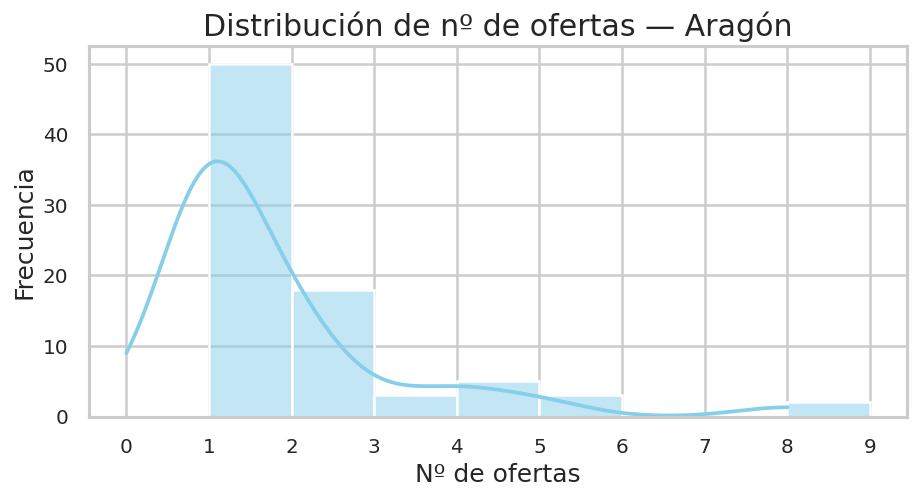

/tmp/ipython-input-3362495655.py:81: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=tmp, x="SingleBid_%", y="Procedimiento_norm", orient="h", palette="viridis")


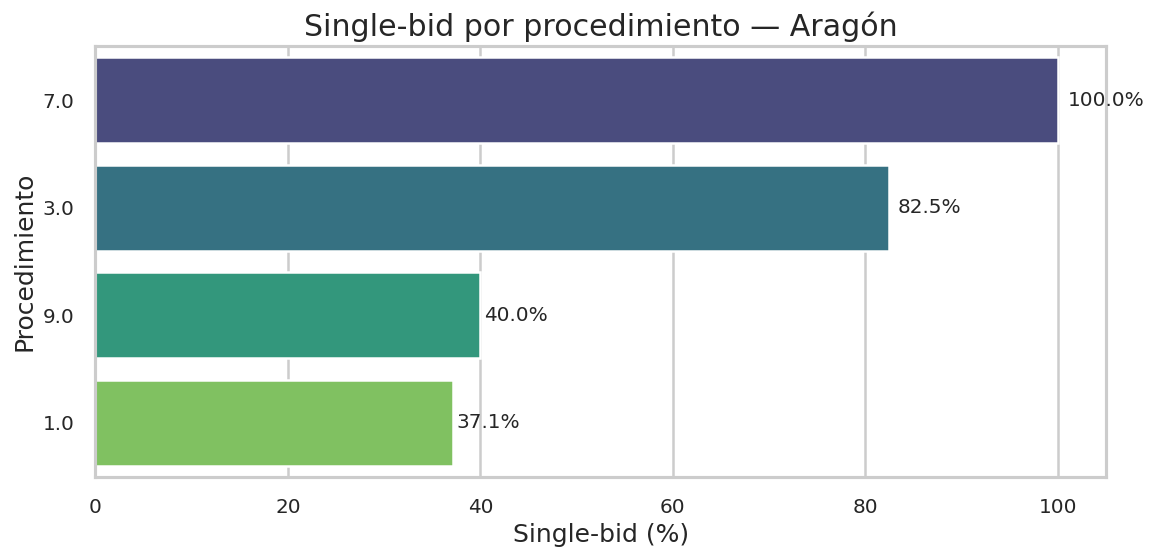

In [ ]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

# Estilo visual
sns.set_style("whitegrid")
sns.set_context("talk", rc={"axes.titlesize":18, "axes.labelsize":15,
                            "xtick.labelsize":12, "ytick.labelsize":12})

OUT_DIR = "/content/drive/MyDrive/Data/outputs_ivd/"
csv_path = os.path.join(OUT_DIR, "ofertas_ccaa_enriquecido_pscp.csv")

# ==========================
# 1) Cargar el dataset y verificar columnas necesarias
# ==========================
base = pd.read_csv(csv_path)

# Validación de columnas esenciales
required_columns = ["ID", "CCAA", "Ofertas_final", "Proc_final"]
missing_columns = [col for col in required_columns if col not in base.columns]
if missing_columns:
    raise ValueError(f"Faltan las siguientes columnas en el dataset: {', '.join(missing_columns)}")

# Asegurar tipos y normalizar procedimientos
base["Ofertas_final"] = pd.to_numeric(base["Ofertas_final"], errors="coerce")

# Normalizar procedimientos (si no existe la columna)
if "Procedimiento_norm" not in base.columns:
    def norm_proc(p):
        if pd.isna(p): return "Desconocido"
        t = str(p).lower()
        if "simplific" in t: return "Abierto simplificado"
        if "abierto"   in t: return "Abierto"
        if "negoci"    in t: return "Negociado"
        if "sara"      in t: return "SARA"
        if "derivado" in t or "acuerdo marco" in t: return "Derivado/AM"
        return str(p).strip().title()
    base["Procedimiento_norm"] = base["Proc_final"].apply(norm_proc)

# ==========================
# 2) Función de reporte por CCAA
# ==========================
def report_ccaa(ccaa):
    """Genera reportes de distribución de ofertas y single-bid por procedimiento para una CCAA dada."""

    # Filtrar por la CCAA deseada
    dfc = base[(base["CCAA"] == ccaa) & base["Ofertas_final"].notna()].copy()

    if dfc.empty:
        print(f"No hay adjudicadas con nº de ofertas para: {ccaa}")
        return

    # KPIs básicos
    singlebid = (dfc["Ofertas_final"] == 1).mean() * 100
    n_adjud = dfc["ID"].nunique()
    ofertas_media = dfc["Ofertas_final"].mean()
    print(f"[{ccaa}] N adjudicadas={n_adjud} | Single-bid={singlebid:.1f}% | Ofertas media={ofertas_media:.2f}")

    # A) Distribución de nº de ofertas
    plt.figure(figsize=(8,4.5))
    ax = sns.histplot(dfc["Ofertas_final"].dropna(), bins=range(1, int(dfc["Ofertas_final"].max())+2), color="skyblue", kde=True)
    ax.set_title(f"Distribución de nº de ofertas — {ccaa}")
    ax.set_xlabel("Nº de ofertas"); ax.set_ylabel("Frecuencia")
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.tight_layout(); plt.show()

    # B) Single-bid por procedimiento
    tmp = (dfc.assign(SingleBid=(dfc["Ofertas_final"] == 1).astype(int))
               .groupby("Procedimiento_norm", as_index=False)
               .agg(N_adjud=("ID","nunique"),
                    Ofertas_media=("Ofertas_final","mean"),
                    SingleBid_rate=("SingleBid","mean")))
    if not tmp.empty:
        tmp["SingleBid_%"] = 100*tmp["SingleBid_rate"]
        tmp = tmp.sort_values("SingleBid_%", ascending=False)

        plt.figure(figsize=(10,5))
        ax = sns.barplot(data=tmp, x="SingleBid_%", y="Procedimiento_norm", orient="h", palette="viridis")
        ax.set_title(f"Single-bid por procedimiento — {ccaa}")
        ax.set_xlabel("Single-bid (%)"); ax.set_ylabel("Procedimiento")
        ax.xaxis.set_major_locator(MaxNLocator(nbins=6))

        # Añadir anotaciones en cada barra
        for p, v in zip(ax.patches, tmp["SingleBid_%"].values):
            ax.text(p.get_width()*1.01, p.get_y()+p.get_height()/2, f"{v:.1f}%", va="center", ha="left", fontsize=12)
        plt.tight_layout(); plt.show()

# ==========================
# 3) Entrada interactiva para la CCAA
# ==========================
def choose_ccaa():
    """Permite al usuario elegir la CCAA para generar el reporte"""
    ccas = sorted(base["CCAA"].dropna().unique().tolist())
    print("CCAA disponibles:")
    for idx, ccaa in enumerate(ccas, 1):
        print(f"{idx}. {ccaa}")

    try:
        choice = int(input("Elige el número de la CCAA que quieres reportar: "))
        if 1 <= choice <= len(ccas):
            report_ccaa(ccas[choice-1])
        else:
            print("Opción no válida. Intenta de nuevo.")
    except ValueError:
        print("Entrada inválida, por favor ingresa un número.")

# ==========================
# 4) Ejecutar la función interactiva
# ==========================
choose_ccaa()



Opciones disponibles:
0. Promedio global nacional
1. Andalucía
2. Aragón
3. Asturias
4. Canarias
5. Cantabria
6. Castilla y León
7. Castilla-La Mancha
8. Cataluña
9. Ceuta
10. Comunidad Valenciana
11. Extremadura
12. Galicia
13. Islas Baleares
14. Madrid
15. Melilla
16. Murcia
17. País Vasco
Elige el número de la opción que quieres reportar: 0


/tmp/ipython-input-2869484488.py:127: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=tmp, x="SingleBid_%", y="Procedimiento_norm",


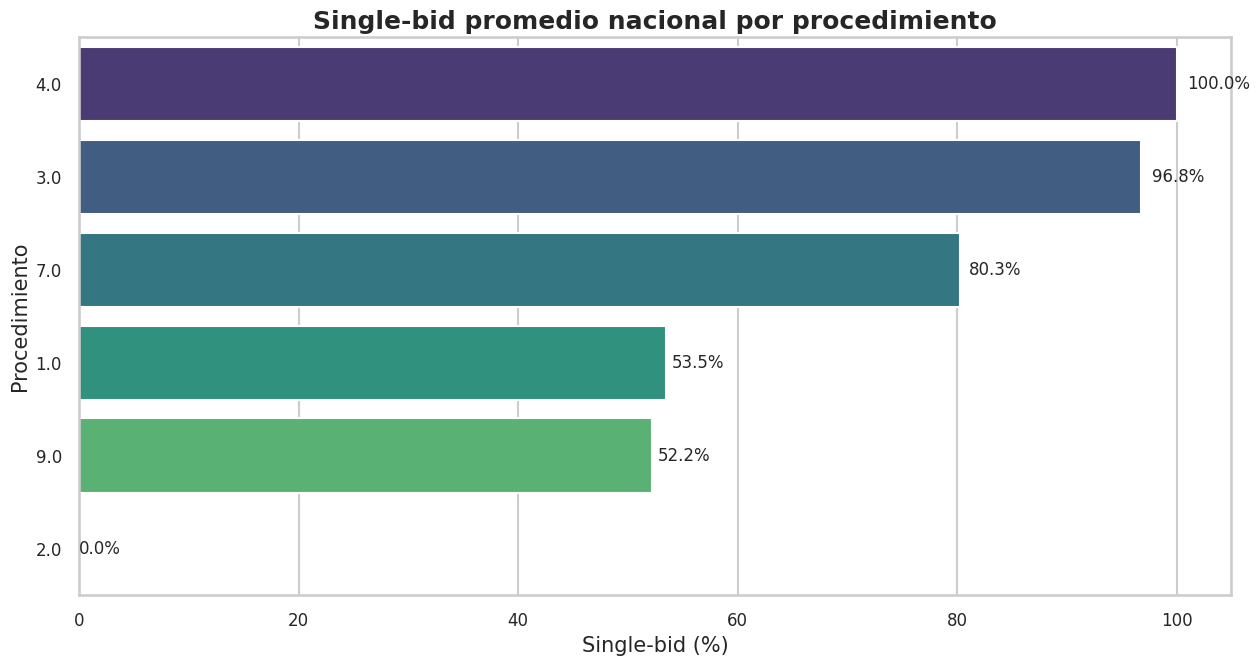

  Procedimiento_norm  N_adjud  Ofertas_media  SingleBid_rate  SingleBid_%
3                4.0        1       1.000000        1.000000   100.000000
2                3.0      283       1.067308        0.967949    96.794872
4                7.0       69       1.408451        0.802817    80.281690
0                1.0      102       3.271318        0.534884    53.488372
5                9.0       19       1.565217        0.521739    52.173913
1                2.0        3       8.333333        0.000000     0.000000


In [ ]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

# ==========================
# Estilo visual
# ==========================
sns.set_style("whitegrid")
sns.set_context("talk", rc={"axes.titlesize":18, "axes.labelsize":15,
                            "xtick.labelsize":12, "ytick.labelsize":12})

OUT_DIR = "/content/drive/MyDrive/Data/outputs_ivd/"
csv_path = os.path.join(OUT_DIR, "ofertas_ccaa_enriquecido_pscp.csv")

# ==========================
# Función auxiliar para aplicar fuentes y títulos (como tus gráficas anteriores)
# ==========================
def apply_axis_fonts(ax, title="", xlabel="", ylabel=""):
    ax.set_title(title, fontsize=18, weight='bold')
    ax.set_xlabel(xlabel, fontsize=15)
    ax.set_ylabel(ylabel, fontsize=15)
    ax.tick_params(axis='x', labelsize=12)
    ax.tick_params(axis='y', labelsize=12)

# ==========================
# 1) Cargar el dataset y verificar columnas necesarias
# ==========================
base = pd.read_csv(csv_path)

required_columns = ["ID", "CCAA", "Ofertas_final", "Proc_final"]
missing_columns = [col for col in required_columns if col not in base.columns]
if missing_columns:
    raise ValueError(f"Faltan las siguientes columnas en el dataset: {', '.join(missing_columns)}")

base["Ofertas_final"] = pd.to_numeric(base["Ofertas_final"], errors="coerce")

# Normalización de procedimientos
if "Procedimiento_norm" not in base.columns:
    def norm_proc(p):
        if pd.isna(p): return "Desconocido"
        t = str(p).lower()
        if "simplific" in t: return "Abierto simplificado"
        if "abierto"   in t: return "Abierto"
        if "negoci"    in t: return "Negociado"
        if "sara"      in t: return "SARA"
        if "derivado" in t or "acuerdo marco" in t: return "Derivado/AM"
        return str(p).strip().title()
    base["Procedimiento_norm"] = base["Proc_final"].apply(norm_proc)

# ==========================
# 2) Función de reporte por CCAA
# ==========================
def report_ccaa(ccaa):
    dfc = base[(base["CCAA"] == ccaa) & base["Ofertas_final"].notna()].copy()
    if dfc.empty:
        print(f"No hay adjudicadas con nº de ofertas para: {ccaa}")
        return

    singlebid = (dfc["Ofertas_final"] == 1).mean() * 100
    n_adjud = dfc["ID"].nunique()
    ofertas_media = dfc["Ofertas_final"].mean()
    print(f"[{ccaa}] N adjudicadas={n_adjud} | Single-bid={singlebid:.1f}% | Ofertas media={ofertas_media:.2f}")

    # A) Distribución de nº de ofertas (histograma)
    fig, ax = plt.subplots(figsize=(13,7))
    sns.histplot(dfc["Ofertas_final"].dropna(),
                 bins=range(1, int(dfc["Ofertas_final"].max())+2),
                 color="skyblue", kde=True, ax=ax)
    apply_axis_fonts(ax,
                     title=f"Distribución de nº de ofertas — {ccaa}",
                     xlabel="Nº de ofertas",
                     ylabel="Frecuencia")
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.tight_layout()
    plt.savefig(os.path.join(OUT_DIR, f"hist_ofertas_{ccaa}.png"), dpi=200, bbox_inches="tight")
    plt.savefig(os.path.join(OUT_DIR, f"hist_ofertas_{ccaa}.svg"), bbox_inches="tight")
    plt.show()

    # B) Single-bid por procedimiento
    tmp = (dfc.assign(SingleBid=(dfc["Ofertas_final"]==1).astype(int))
               .groupby("Procedimiento_norm", as_index=False)
               .agg(N_adjud=("ID","nunique"),
                    Ofertas_media=("Ofertas_final","mean"),
                    SingleBid_rate=("SingleBid","mean")))
    if not tmp.empty:
        tmp["SingleBid_%"] = 100*tmp["SingleBid_rate"]
        tmp = tmp.sort_values("SingleBid_%", ascending=False)

        fig, ax = plt.subplots(figsize=(13,7))
        sns.barplot(data=tmp, x="SingleBid_%", y="Procedimiento_norm",
                    orient="h", palette="viridis", ax=ax)
        apply_axis_fonts(ax,
                         title=f"Single-bid por procedimiento — {ccaa}",
                         xlabel="Single-bid (%)",
                         ylabel="Procedimiento")
        ax.xaxis.set_major_locator(MaxNLocator(nbins=6))

        for p, v in zip(ax.patches, tmp["SingleBid_%"].values):
            ax.text(p.get_width()*1.01, p.get_y()+p.get_height()/2, f"{v:.1f}%", va="center", ha="left", fontsize=12)

        plt.tight_layout()
        plt.savefig(os.path.join(OUT_DIR, f"singlebid_{ccaa}.png"), dpi=200, bbox_inches="tight")
        plt.savefig(os.path.join(OUT_DIR, f"singlebid_{ccaa}.svg"), bbox_inches="tight")
        plt.show()

# ==========================
# 3) Función de reporte global
# ==========================
def global_report():
    dfc = base[base["Ofertas_final"].notna()].copy()
    if dfc.empty:
        print("No hay adjudicadas con nº de ofertas en ninguna CCAA")
        return

    tmp = (dfc.assign(SingleBid=(dfc["Ofertas_final"]==1).astype(int))
               .groupby("Procedimiento_norm", as_index=False)
               .agg(N_adjud=("ID","nunique"),
                    Ofertas_media=("Ofertas_final","mean"),
                    SingleBid_rate=("SingleBid","mean")))
    tmp["SingleBid_%"] = 100*tmp["SingleBid_rate"]
    tmp = tmp.sort_values("SingleBid_%", ascending=False)

    fig, ax = plt.subplots(figsize=(13,7))
    sns.barplot(data=tmp, x="SingleBid_%", y="Procedimiento_norm",
                orient="h", palette="viridis", ax=ax)
    apply_axis_fonts(ax,
                     title="Single-bid promedio nacional por procedimiento",
                     xlabel="Single-bid (%)",
                     ylabel="Procedimiento")
    ax.xaxis.set_major_locator(MaxNLocator(nbins=6))

    for p, v in zip(ax.patches, tmp["SingleBid_%"].values):
        ax.text(p.get_width()*1.01, p.get_y()+p.get_height()/2, f"{v:.1f}%", va="center", ha="left", fontsize=12)

    plt.tight_layout()
    plt.savefig(os.path.join(OUT_DIR, "singlebid_global.png"), dpi=200, bbox_inches="tight")
    plt.savefig(os.path.join(OUT_DIR, "singlebid_global.svg"), bbox_inches="tight")
    plt.show()
    return tmp

# ==========================
# 4) Entrada interactiva
# ==========================
def choose_report():
    ccas = sorted(base["CCAA"].dropna().unique().tolist())
    print("Opciones disponibles:")
    print("0. Promedio global nacional")
    for idx, ccaa in enumerate(ccas, 1):
        print(f"{idx}. {ccaa}")

    try:
        choice = int(input("Elige el número de la opción que quieres reportar: "))
        if choice == 0:
            global_df = global_report()
            print(global_df)
        elif 1 <= choice <= len(ccas):
            report_ccaa(ccas[choice-1])
        else:
            print("Opción no válida. Intenta de nuevo.")
    except ValueError:
        print("Entrada inválida, por favor ingresa un número.")

# ==========================
# 5) Ejecutar
# ==========================
choose_report()

